In [1]:
import numpy as np
import pandas as pd
import jinja2
import zlib

from IPython.display import display, Markdown, HTML, SVG

In [2]:
(np.array([352.1, 452.2, 552.31]).view(np.uint8))

array([154, 153, 153, 153, 153,   1, 118,  64,  51,  51,  51,  51,  51,
        67, 124,  64,  20, 174,  71, 225, 122,  66, 129,  64], dtype=uint8)

In [37]:
float_buffer = np.array([549.1, 552.22, 552.29])
byte_buffer = float_buffer.view(np.uint8)
shuffled_byte_buffer = byte_buffer.reshape((-1, float_buffer.itemsize)).T.flatten()
shuffled_byte_buffer, byte_buffer

(array([205, 246, 184, 204,  40,  30, 204,  92, 133, 204, 143, 235, 204,
        194,  81,  40,  65,  66, 129, 129, 129,  64,  64,  64], dtype=uint8),
 array([205, 204, 204, 204, 204,  40, 129,  64, 246,  40,  92, 143, 194,
         65, 129,  64, 184,  30, 133, 235,  81,  66, 129,  64], dtype=uint8))

In [43]:
byte_buffer.reshape((4, -1)).flatten().view(np.float64)

array([549.1 , 552.22, 552.29])

In [4]:
import numpy as np
import struct

bytes_views = {
        8: np.uint64,
        4: np.uint32,
        2: np.uint16,
        1: np.uint8,
    }
index_widths = [
    (2**8, np.uint8),
    (2**16, np.uint16),
    (2**32, np.uint32),
    (2**64, np.uint64),
]

def dict_encode(data: np.typing.ArrayLike) -> bytes:
    byte_view_tp = bytes_views[data.itemsize]
    view = data.view(byte_view_tp)
    keys = np.sort(np.unique(view))

    index_tp = None
    for size, idx_type in index_widths:
        if len(keys) < size:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {len(keys)} values")

    encoded = np.zeros(len(view), dtype=index_tp)
    for i, k in enumerate(keys):
        encoded[view == k] = i
    n_keys = np.uint64(len(keys))
    total_size = 16 + keys.nbytes + encoded.nbytes
    buffer = np.empty(total_size, dtype=np.uint8)
    buffer[:8] = memoryview(struct.pack("<Q", np.uint64(16 + keys.nbytes)))
    buffer[8:16] = memoryview(struct.pack("<Q", np.uint64(len(keys))))
    buffer[16 : keys.nbytes + 16] = keys.view(np.uint8)
    buffer[(16 + keys.nbytes) :] = encoded.view(np.uint8)
    return buffer


def dict_decode(buffer: np.typing.ArrayLike, dtype: np.dtype) -> bytes:
    

    index_tp = None
    byte_view_tp = bytes_views[dtype().itemsize]

    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_keys,) = struct.unpack("<Q", buffer[8:16])
    for size, idx_type in index_widths:
        if size > n_keys:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {n_keys} values")
    keys = buffer[16:offset_to_data].view(byte_view_tp)
    values = buffer[offset_to_data:].view(index_tp)
    return keys[values].view(dtype)

In [5]:
def dict_encoding_to_block(buffer: bytes, dtype):
    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_keys,) = struct.unpack("<Q", buffer[8:16])
    bytes_views = {
        8: np.uint64,
        4: np.uint32,
        2: np.uint16,
        1: np.uint8,
    }
    index_widths = [
        (2**8, np.uint8),
        (2**16, np.uint16),
        (2**32, np.uint32),
        (2**64, np.uint64),
    ]
    index_tp = None
    byte_view_tp = bytes_views[dtype().itemsize]

    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_keys,) = struct.unpack("<Q", buffer[8:16])
    for size, idx_type in index_widths:
        if size > n_keys:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {n_keys} values")

    keys = buffer[16:offset_to_data].view(byte_view_tp)
    values = buffer[offset_to_data:].view(index_tp)
    
    return {
        "data_offset": [offset_to_data, ' '.join(hexify(buffer[:8]))],
        "keys_in_dictionary": [n_keys, ' '.join(hexify(buffer[8:16]))],
        "keys": [
            list(map(float, keys.view(dtype))),
            segment_by(hexify(buffer[16:offset_to_data]), 8)[:20] + '...'
        ]
   }

def present_codec(data_buffer, dtype):
    return pd.DataFrame(dict_encoding_to_block(dict_encode(data_buffer), dtype)).to_markdown(index=False, )

In [6]:
import tabulate

In [7]:
dict_encode(np.array([1, 2, 3, 3, 4, 5, 4, 10]))

array([64,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  3,  0,
        0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,
        0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2,
        3,  4,  3,  5], dtype=uint8)

In [8]:
dict_decode(dict_encode(np.array([1, 2, 3, 3, 4, 5, 4, 10], dtype=np.int32)), np.int32)

array([ 1,  2,  3,  3,  4,  5,  4, 10], dtype=int32)

In [9]:
def segment_by(x: list, size: int) -> str:
    tokens = ['[ ']
    i = 0
    while i < len(x):
        tokens.append(', '.join(map(str, x[i:i + size])))
        tokens.append(' | ')
        i += size
    tokens = tokens[:-1]
    tokens.append(' ]')
    return ''.join(tokens)

In [10]:
def hexify(data: list[int]) -> list[str]:
    return list(map(hex, data))

In [77]:
def byte_shuffle_encode(x: np.array):
    byte_buffer = x.view(np.uint8)
    return byte_buffer.reshape((-1, x.itemsize)).T.flatten()

def byte_shuffle_decode(byte_buffer: np.array, dtype: np.dtype):
    return byte_buffer.reshape((dtype().itemsize, -1)).T.flatten().view(dtype)

In [59]:
byte_buffer = float_buffer.view(np.uint8)
shuffled_byte_buffer = byte_buffer.reshape((-1, float_buffer.itemsize)).T.flatten()
shuffled_byte_buffer, byte_buffer

(array([205, 246, 184, 204,  40,  30, 204,  92, 133, 204, 143, 235, 204,
        194,  81,  40,  65,  66, 129, 129, 129,  64,  64,  64], dtype=uint8),
 array([205, 204, 204, 204, 204,  40, 129,  64, 246,  40,  92, 143, 194,
         65, 129,  64, 184,  30, 133, 235,  81,  66, 129,  64], dtype=uint8))

In [75]:
shuffled_byte_buffer.reshape((8, -1)).T.flatten().view(np.float64)

array([549.1 , 552.22, 552.29])

In [61]:
float_buffer

array([549.1 , 552.22, 552.29])

In [78]:
byte_shuffle_decode(
    byte_shuffle_encode(float_buffer),
    np.float64
).view()

array([549.1 , 552.22, 552.29])

In [58]:
float_buffer

array([549.1 , 552.22, 552.29])

In [54]:
np.float64().itemsize

8

In [86]:
schemata = open("DictionaryByteSchemata.svg").read()
combined_schemata = open("DictionaryByteSchemataWithShuffle.svg").read()

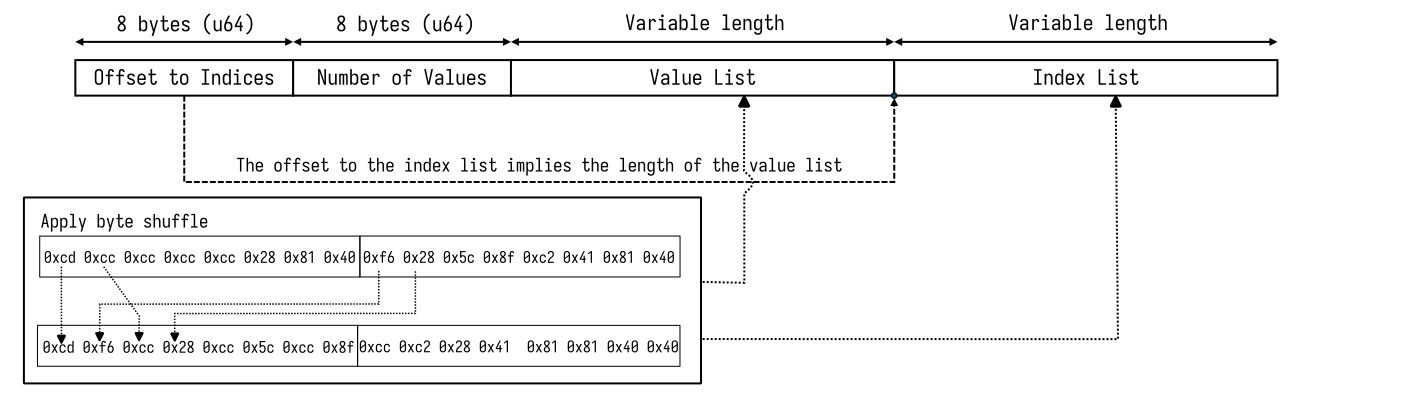

In [87]:
SVG(combined_schemata)

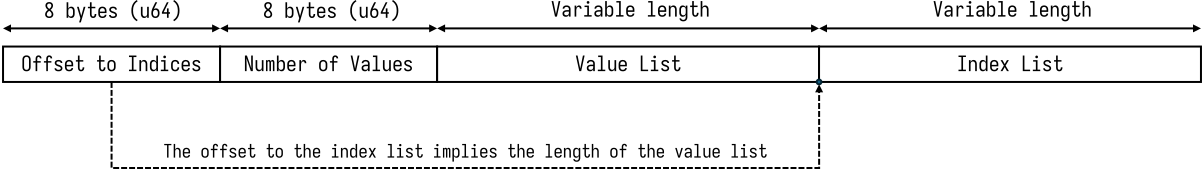

In [13]:
SVG(schemata)

In [17]:
env = jinja2.Environment()

In [19]:
env.filters['hexify'] = hexify

In [136]:
template = env.from_string(('''
# Compression with byte shuffling

For some numerical data, it is possible to achieve (much) better compression performance by
re-arranging the bytes (or bits) of the elements of the data array prior to compressing them.
This has to do with how numbers are laid out in memory, and mileage may vary as to whether shuffling
always improves compression ratios. Also, as a note to some readers, while we use the term "shuffle",
*this is not a random operation* analogous to shuffling a deck of cards is supposed to be, but closer
in execution to a structured re-arrangement of bytes in multi-byte data types.
```
{{float_buffer[:-1]}}
```
We can view these double-precision floats (64 bits) as contiguous blocks of 8 bytes (8 bits) each
These bytes are what a compression algorithm will see when it tries to compact your data. 
Byte-shuffling re-arranges your data so that the $i$th byte of each element is stored contiguously:

![](byte_shuffle.png)

See also [https://parquet.apache.org/docs/file-format/data-pages/encodings/#byte-stream-split-byte_stream_split--9](BYTE_STREAM_SPLIT) encoding

Below is some idiomatic Python code to implement this concept:

```python
import numpy as np

def byte_shuffle_encode(x: np.ndarray):
    byte_buffer = x.view(np.uint8)
    return byte_buffer.reshape((-1, x.itemsize)).T.flatten()

def byte_shuffle_decode(byte_buffer: np.ndarray, dtype: np.dtype):
    return byte_buffer.reshape((dtype().itemsize, -1)).T.flatten().view(dtype)
```


Also, a more explicit C++ implementation that handles endianess:

```c++
#include <vector>
#include <cstdint>
#include <bit>

using byte_t = std::uint8_t;
using buffer_t = std::vector<byte_t>;

constexpr bool is_big_endian(void)
{
    return std::endian::native == std::endian::big;
}

/// @brief Shuffle the bytes of `data` into `buffer`. Also enforces little-endian ordering
/// @tparam T
/// @param data The data to transpose
/// @param buffer Where to transpose the data into
template <typename T>
void transpose(const std::vector<T> &data, buffer_t &buffer)
{
    auto nData = data.size();
    auto nBytes = nData * sizeof(T);

    buffer.clear();
    buffer.reserve(nBytes);
    for (size_t i = 0; i < sizeof(T); i++)
    {
        for (size_t j = 0; j < data.size(); j++)
        {
            auto value = data[j];
            auto byteView = reinterpret_cast<uint8_t *>(&value);
            if (is_big_endian()) {
                buffer.push_back(byteView[(sizeof(T) - 1) - i]);
            } else {
                buffer.push_back(byteView[i]);
            }
        }
    }
    return;
}

template <typename T>
void reverse_transpose(const buffer_t &buffer, std::vector<T> &data)
{
    auto nBytes = buffer.size();
    auto nData = nBytes / sizeof(T);
    data.resize(nData);
    for (size_t i = 0; i < buffer.size(); i++)
    {
        auto datum = &data[i % nData];
        auto byteView = reinterpret_cast<uint8_t *>(datum);
        if (is_big_endian()) {
            byteView[(sizeof(T) - 1) - (i / nData)] = buffer[i];
        } else {
            byteView[i / nData] = buffer[i];
        }
    }
    return;
}
```


# Dictionary Encoding
## Motivation

Some data arrays are hard to compress simply because their data spans a wide range of possible values but lacks
structures or patterns that make compression possible despite many repetitions of the same value, simply
because of how they are organized.

A good example of this is ion mobility, where the values span an instrument-specific domain with varying levels
of precision, and these points are repeated out-of-order because ion mobility arrays are sorted along the m/z axis.

One thing a compression algorithm does is finds repeated patterns and encodes the pattern in a lookup table or "dictionary"
and associates a unique token or placeholder that uses less space than the original pattern. How big patterns may be, what
criteria they must satisfy, and other things, depend upon the algorithm, but these algorithms generally don't know much about
the data they compress, which prevents them from making simplifying assumptions.

Since **we** know the context in which we are working, we can pre-construct a dictionary to encode the data with, and apply
the general purpose compression algorithm on that the encoding instead, assuming it is simpler than the original. At the same
time, we recognize that being *very, very clever* to shave 5% off the total size of our data but produce an algorithm so convoluted
nobody but the creator could implement in multiple languages is a recipe for a waste of time so we hope to make the algorithm simple
enough that other people can understand it if the portfolio of reference implementations aren't sufficient for their needs.

## Method

### Encoding

We construct a lookup table by first collecting all the unique values in a data array $V$, called $V^*$, and sort $V^*$ so adjacent values are
close together to hopefully make them easier to compress later. Based upon the number of unique items, we can determine the largest bit width
"index" or "key" type we need to address them all. For ion mobility data at the time of this writing, there are fewer than 1,000 unique values
recorded by instruments today, which fits tidily in use 2<sup>16</sup> bits. Next, we build a mapping from value to its index in $V^*$ using the
smallest standard integer type $I^*$, and create a new array $K = [ \\text{map}(v_j) : v \\in V ]$.

We can then write the following structure in bytes:

{{schemata}}

![](./DictionaryByteSchemata.png)

We prefix the dictionary encoding with two 8 byte unsigned integers in little endian order. The first is the distance, in bytes, from the begining
of the buffer to the begining of the region encoding $K$, $i_{\\text{offset}}$. The second is the number of unique values in $V^*$. Next, we encode
the bytes of $V^*$ in the buffer in little endian byte order, followed by the bytes of $K$ in little endian byte order.

### Decoding

To decode, we first read the first 16 bytes and interpret it as two 64 bit unsigned integers which tells us the offset $i_{\\text{offset}}$ to the index list $K$ and
the number of values in $V^*$, $|V^*|$. We assume we know the type of value we want to decode $V^*$ into, so we can validate that $\\frac{i_{\\text{offset}} - 16}{|V^*|}$
matches the size of that type in bytes. It is then straight-forwards to reconstruct $V^*$ from byte 16 to the index offset, reinterpreting the bytes
as needed to build a native representation of $V^*$ in the correct type. Next, we infer the $I^*$ from $|V^*|$ using the same logic as during
encoding. Finally, we reconstruct the original data array $V$ using $V = [ V^*[k_i] : k_i \\in K ]$.

`zstd.compress(dict_encode(V))` is reversed by `dict_decode(zstd.decompress(buffer), type_of_V)`

Below is Python code implementing this method:

```python
import numpy as np
import struct

bytes_views = {
    8: np.uint64,
    4: np.uint32,
    2: np.uint16,
    1: np.uint8,
}
index_widths = [
    (2**8, np.uint8),
    (2**16, np.uint16),
    (2**32, np.uint32),
    (2**64, np.uint64),
]

def dict_encode(data: np.ndarray) -> np.ndarray:
    byte_view_tp = bytes_views[data.itemsize]
    view = data.view(byte_view_tp)
    values = np.sort(np.unique(view))

    index_tp = None
    for size, idx_type in index_widths:
        if len(values) < size:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {len(values)} values")

    indices = np.zeros(len(view), dtype=index_tp)
    for i, k in enumerate(values):
        indices[view == k] = i

    n_values = np.uint64(len(values))
    total_size = 16 + values.nbytes + indices.nbytes
    buffer = np.empty(total_size, dtype=np.uint8)
    buffer[:8] = memoryview(struct.pack("<Q", np.uint64(16 + values.nbytes)))
    buffer[8:16] = memoryview(struct.pack("<Q", np.uint64(len(values))))
    buffer[16 : values.nbytes + 16] = values.view(np.uint8)
    buffer[(16 + values.nbytes) :] = indices.view(np.uint8)
    return buffer


def dict_decode(buffer: np.ndarray, dtype: np.dtype) -> np.ndarray:
    index_tp = None
    byte_view_tp = bytes_views[dtype().itemsize]

    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_values,) = struct.unpack("<Q", buffer[8:16])
    for size, idx_type in index_widths:
        if size > n_values:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {n_values} indices")
    values = buffer[16:offset_to_data].view(byte_view_tp)
    indices = buffer[offset_to_data:].view(index_tp)
    return values[indices].view(dtype)
```

# Combining dictionaries and byte shuffling

When the dictionary is large, and especially when the values are large, it can be advantageous
to apply byte shuffling to the values list and the index list separately. This works in two ways.
The first is that the sorted value array $V^*$ is more likely to compress better when shuffled
for the same reason byte shuffling works well on an m/z array. The second is that the larger,
repetitive index array $K$, being an integer type, is more compressable than a floating point
type when shuffled, even unsorted.

{{combined_schemata}}
![](./DictionaryByteSchemataWithShuffle.png)

This is relatively straight-forwards to do by injecting the shuffling step immediately prior to
encoding the dictionary buffers and decoding them prior to using them as an index map. 

```python
def dict_encode_with_shuffle(data: np.ndarray) -> np.ndarray:
    byte_view_tp = bytes_views[data.itemsize]
    view = data.view(byte_view_tp)
    values = np.sort(np.unique(view))

    index_tp = None
    for size, idx_type in index_widths:
        if len(values) < size:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {len(values)} values")

    indices = np.zeros(len(view), dtype=index_tp)
    for i, k in enumerate(values):
        indices[view == k] = i

    values = byte_shuffle_encode(values)
    indices = byte_shuffle_encode(indices)

    n_values = np.uint64(len(values))
    total_size = 16 + values.nbytes + indices.nbytes
    buffer = np.empty(total_size, dtype=np.uint8)
    buffer[:8] = memoryview(struct.pack("<Q", np.uint64(16 + values.nbytes)))
    buffer[8:16] = memoryview(struct.pack("<Q", np.uint64(len(values))))
    buffer[16 : values.nbytes + 16] = values.view(np.uint8)
    buffer[(16 + values.nbytes) :] = indices.view(np.uint8)
    return buffer


def dict_decode_with_shuffle(buffer: np.ndarray, dtype: np.dtype) -> np.ndarray:
    index_tp = None
    byte_view_tp = bytes_views[dtype().itemsize]

    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_values,) = struct.unpack("<Q", buffer[8:16])
    for size, idx_type in index_widths:
        if size > n_values:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {n_values} indices")
    values = buffer[16:offset_to_data].view(byte_view_tp)
    indices = buffer[offset_to_data:].view(index_tp)
    
    indices = byte_shuffle_decode(indices.view(np.uint8), index_tp)
    values = byte_shuffle_decode(values.view(np.uint8), byte_view_tp)
    return values[indices].view(dtype)
```
'''))
content = template.render(**globals())

Markdown(content)


# Compression with byte shuffling

For some numerical data, it is possible to achieve (much) better compression performance by
re-arranging the bytes (or bits) of the elements of the data array prior to compressing them.
This has to do with how numbers are laid out in memory, and mileage may vary as to whether shuffling
always improves compression ratios. Also, as a note to some readers, while we use the term "shuffle",
*this is not a random operation* analogous to shuffling a deck of cards is supposed to be, but closer
in execution to a structured re-arrangement of bytes in multi-byte data types.
```
[549.1  552.22]
```
We can view these double-precision floats (64 bits) as contiguous blocks of 8 bytes (8 bits) each
These bytes are what a compression algorithm will see when it tries to compact your data. 
Byte-shuffling re-arranges your data so that the $i$th byte of each element is stored contiguously:

![](byte_shuffle.png)

Below is some idiomatic Python code to implement this concept:

```python
import numpy as np

def byte_shuffle_encode(x: np.ndarray):
    byte_buffer = x.view(np.uint8)
    return byte_buffer.reshape((-1, x.itemsize)).T.flatten()

def byte_shuffle_decode(byte_buffer: np.ndarray, dtype: np.dtype):
    return byte_buffer.reshape((dtype().itemsize, -1)).T.flatten().view(dtype)
```

Also, a more explicit C++ implementation that handles endianess:

```c++
#include <vector>
#include <cstdint>
#include <bit>

using byte_t = std::uint8_t;
using buffer_t = std::vector<byte_t>;

constexpr bool is_big_endian(void)
{
    return std::endian::native == std::endian::big;
}

/// @brief Shuffle the bytes of `data` into `buffer`. Also enforces little-endian ordering
/// @tparam T
/// @param data The data to transpose
/// @param buffer Where to transpose the data into
template <typename T>
void transpose(const std::vector<T> &data, buffer_t &buffer)
{
    auto nData = data.size();
    auto nBytes = nData * sizeof(T);

    buffer.clear();
    buffer.reserve(nBytes);
    for (size_t i = 0; i < sizeof(T); i++)
    {
        for (size_t j = 0; j < data.size(); j++)
        {
            auto value = data[j];
            auto byteView = reinterpret_cast<uint8_t *>(&value);
            if (is_big_endian()) {
                buffer.push_back(byteView[(sizeof(T) - 1) - i]);
            } else {
                buffer.push_back(byteView[i]);
            }
        }
    }
    return;
}

template <typename T>
void reverse_transpose(const buffer_t &buffer, std::vector<T> &data)
{
    auto nBytes = buffer.size();
    auto nData = nBytes / sizeof(T);
    data.resize(nData);
    for (size_t i = 0; i < buffer.size(); i++)
    {
        auto datum = &data[i % nData];
        auto byteView = reinterpret_cast<uint8_t *>(datum);
        if (is_big_endian()) {
            byteView[(sizeof(T) - 1) - (i / nData)] = buffer[i];
        } else {
            byteView[i / nData] = buffer[i];
        }
    }
    return;
}
```


# Dictionary Encoding
## Motivation

Some data arrays are hard to compress simply because their data spans a wide range of possible values but lacks
structures or patterns that make compression possible despite many repetitions of the same value, simply
because of how they are organized.

A good example of this is ion mobility, where the values span an instrument-specific domain with varying levels
of precision, and these points are repeated out-of-order because ion mobility arrays are sorted along the m/z axis.

One thing a compression algorithm does is finds repeated patterns and encodes the pattern in a lookup table or "dictionary"
and associates a unique token or placeholder that uses less space than the original pattern. How big patterns may be, what
criteria they must satisfy, and other things, depend upon the algorithm, but these algorithms generally don't know much about
the data they compress, which prevents them from making simplifying assumptions.

Since **we** know the context in which we are working, we can pre-construct a dictionary to encode the data with, and apply
the general purpose compression algorithm on that the encoding instead, assuming it is simpler than the original. At the same
time, we recognize that being *very, very clever* to shave 5% off the total size of our data but produce an algorithm so convoluted
nobody but the creator could implement in multiple languages is a recipe for a waste of time so we hope to make the algorithm simple
enough that other people can understand it if the portfolio of reference implementations aren't sufficient for their needs.

## Method

### Encoding

We construct a lookup table by first collecting all the unique values in a data array $V$, called $V^*$, and sort $V^*$ so adjacent values are
close together to hopefully make them easier to compress later. Based upon the number of unique items, we can determine the largest bit width
"index" or "key" type we need to address them all. For ion mobility data at the time of this writing, there are fewer than 1,000 unique values
recorded by instruments today, which fits tidily in use 2<sup>16</sup> bits. Next, we build a mapping from value to its index in $V^*$ using the
smallest standard integer type $I^*$, and create a new array $K = [ \text{map}(v_j) : v \in V ]$.

We can then write the following structure in bytes:

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   width="1204.7506"
   height="169.68083"
   viewBox="0 0 1204.7506 169.68083"
   sodipodi:docname="DictionaryByteSchemata.pdf"
   inkscape:version="1.4.2 (f4327f4, 2025-05-13)"
   inkscape:dataloss="true"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg">
  <defs
     id="defs1">
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath5">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-42.672001,438.19001)"
         clip-rule="evenodd"
         id="path5" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath7">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-210.1,438.19001)"
         clip-rule="evenodd"
         id="path7" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath9">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-82.680002,478.06001)"
         clip-rule="evenodd"
         id="path9" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath11">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-246.14001,478.06001)"
         clip-rule="evenodd"
         id="path11" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath13">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-459.62001,438.19001)"
         clip-rule="evenodd"
         id="path13" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath15">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-441.34001,478.06001)"
         clip-rule="evenodd"
         id="path15" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath17">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-747.26002,438.19001)"
         clip-rule="evenodd"
         id="path17" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath19">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-728.98002,478.06001)"
         clip-rule="evenodd"
         id="path19" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath22">
      <path
         d="M -7.629e-6,540 H 960 V 1.8311e-4 H -7.629e-6"
         clip-rule="evenodd"
         id="path22" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath23">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-149.52,373.06001)"
         clip-rule="evenodd"
         id="path23" />
    </clipPath>
  </defs>
  <sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#000000"
     borderopacity="0.25"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1"
     inkscape:zoom="1.1291667"
     inkscape:cx="528.26568"
     inkscape:cy="142.14022"
     inkscape:window-width="2880"
     inkscape:window-height="1514"
     inkscape:window-x="2869"
     inkscape:window-y="-11"
     inkscape:window-maximized="1"
     inkscape:current-layer="g1">
    <inkscape:page
       x="0"
       y="0"
       width="1204.7506"
       height="169.68083"
       id="page2"
       margin="0"
       bleed="0" />
  </sodipodi:namedview>
  <g
     id="g1"
     inkscape:groupmode="layer"
     inkscape:label="1"
     transform="translate(-37.622665,-64.332521)">
    <g
       id="g3"
       inkscape:export-filename="g3.svg"
       inkscape:export-xdpi="96"
       inkscape:export-ydpi="96">
      <path
         id="path4"
         d="m 28.967,430.04 h 163.44 v 26.658 H 28.967 Z"
         style="fill:#ffffff;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g4">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 3.99,0.12768 q -0.43092,0 -0.86184,-0.0798 Q 2.7132,-0.03192 2.34612,-0.22344 1.97904,-0.43092 1.6758,-0.75012 1.38852,-1.06932 1.21296,-1.45236 1.0374,-1.8354 0.9576,-2.25036 0.89376,-2.68128 0.89376,-3.1122 v -5.5062 q 0,-0.43092 0.06384,-0.84588 0.0798,-0.43092 0.25536,-0.81396 0.17556,-0.38304 0.46284,-0.70224 0.30324,-0.3192 0.67032,-0.51072 0.36708,-0.20748 0.78204,-0.28728 0.43092,-0.0798 0.86184,-0.0798 0.43092,0 0.84588,0.0798 0.43092,0.0798 0.798,0.28728 0.36708,0.19152 0.65436,0.51072 0.30324,0.3192 0.4788,0.70224 0.17556,0.38304 0.2394,0.81396 0.0798,0.41496 0.0798,0.84588 v 5.5062 q 0,0.43092 -0.0798,0.86184 -0.06384,0.41496 -0.2394,0.798 -0.17556,0.38304 -0.4788,0.70224 -0.28728,0.3192 -0.65436,0.52668 Q 5.2668,-0.03192 4.83588,0.04788 4.42092,0.12768 3.99,0.12768 Z m 0,-1.1172 q 0.27132,0 0.52668,-0.04788 Q 4.788,-1.10124 5.01144,-1.24488 5.23488,-1.38852 5.39448,-1.596 5.57004,-1.81944 5.6658,-2.05884 5.77752,-2.3142 5.80944,-2.56956 5.84136,-2.84088 5.84136,-3.1122 v -5.5062 q 0,-0.27132 -0.03192,-0.52668 Q 5.77752,-9.4164 5.6658,-9.6558 5.57004,-9.91116 5.39448,-10.11864 5.23488,-10.34208 5.01144,-10.48572 4.788,-10.62936 4.51668,-10.67724 4.26132,-10.74108 3.99,-10.74108 q -0.27132,0 -0.54264,0.06384 -0.25536,0.04788 -0.4788,0.19152 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.20748 -0.27132,0.46284 -0.09576,0.2394 -0.12768,0.51072 -0.03192,0.25536 -0.03192,0.52668 v 5.5062 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.12768,0.51072 0.11172,0.2394 0.27132,0.46284 0.17556,0.20748 0.399,0.35112 0.22344,0.14364 0.4788,0.20748 0.27132,0.04788 0.54264,0.04788 z M 10.82088,0 V -6.43188 H 9.0493197 v -1.1172 H 10.82088 v -1.69176 q 0,-0.3192 0.03192,-0.6384 0.04788,-0.33516 0.1596,-0.6384 0.12768,-0.30324 0.3192,-0.5586 0.20748,-0.27132 0.46284,-0.44688 0.27132,-0.19152 0.59052,-0.25536 0.33516,-0.0798 0.65436,-0.0798 0.44688,0 0.8778,0.14364 0.43092,0.14364 0.73416,0.46284 0.3192,0.3192 0.46284,0.75012 0.14364,0.43092 0.14364,0.8778 V -9.576 h -1.24488 v -0.01596 q 0,-0.22344 -0.06384,-0.43092 -0.04788,-0.20748 -0.17556,-0.36708 -0.12768,-0.17556 -0.33516,-0.25536 -0.19152,-0.09576 -0.399,-0.09576 -0.25536,0 -0.4788,0.14364 -0.20748,0.14364 -0.3192,0.38304 -0.11172,0.22344 -0.1596,0.4788 -0.03192,0.2394 -0.03192,0.49476 v 1.69176 h 2.6334 v 1.1172 H 12.0498 V 0 Z m 8.027879,0 v -6.43188 h -1.77156 v -1.1172 h 1.77156 v -1.69176 q 0,-0.3192 0.03192,-0.6384 0.04788,-0.33516 0.1596,-0.6384 0.12768,-0.30324 0.3192,-0.5586 0.20748,-0.27132 0.46284,-0.44688 0.27132,-0.19152 0.59052,-0.25536 0.33516,-0.0798 0.65436,-0.0798 0.44688,0 0.8778,0.14364 0.43092,0.14364 0.73416,0.46284 0.3192,0.3192 0.46284,0.75012 0.14364,0.43092 0.14364,0.8778 V -9.576 h -1.24488 v -0.01596 q 0,-0.22344 -0.06384,-0.43092 -0.04788,-0.20748 -0.17556,-0.36708 -0.12768,-0.17556 -0.33516,-0.25536 -0.19152,-0.09576 -0.399,-0.09576 -0.25536,0 -0.4788,0.14364 -0.20748,0.14364 -0.3192,0.38304 -0.11172,0.22344 -0.1596,0.4788 -0.03192,0.2394 -0.03192,0.49476 v 1.69176 h 2.6334 v 1.1172 h -2.6334 V 0 Z m 9.20892,0.12768 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 7.932121,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z m 7.229879,4.83588 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z m 15.944043,0 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z m 6.974517,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.9152 q 0,0.43092 -0.06384,0.86184 -0.06384,0.43092 -0.2394,0.82992 -0.17556,0.38304 -0.4788,0.7182 -0.28728,0.3192 -0.67032,0.52668 -0.36708,0.20748 -0.798,0.28728 -0.41496,0.09576 -0.84588,0.09576 z m 0,-1.1172 q 0.27132,0 0.54264,-0.06384 0.27132,-0.06384 0.49476,-0.20748 0.22344,-0.1596 0.38304,-0.38304 0.17556,-0.22344 0.27132,-0.4788 0.09576,-0.25536 0.12768,-0.52668 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 z M 81.140642,0 v -1.1172 h 2.17056 v -9.4962 h -2.17056 v -1.1172 h 5.586 v 1.1172 h -2.17056 v 9.4962 h 2.17056 V 0 Z m 7.852317,0 v -8.2992 h 1.24488 v 1.5162 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.03192,0.25536 -0.03192,0.52668 V 0 Z m 10.437838,0.12768 q -0.399,0 -0.78204,-0.11172 -0.38304,-0.11172 -0.70224,-0.35112 -0.30324,-0.25536 -0.51072,-0.59052 -0.20748,-0.33516 -0.33516,-0.70224 -0.12768,-0.38304 -0.17556,-0.76608 -0.03192,-0.399 -0.03192,-0.798 v -1.9152 q 0,-0.399 0.03192,-0.78204 0.04788,-0.399 0.17556,-0.76608 0.12768,-0.38304 0.33516,-0.7182 0.20748,-0.33516 0.51072,-0.57456 0.3192,-0.25536 0.70224,-0.36708 0.38304,-0.11172 0.78204,-0.11172 0.38304,0 0.750123,0.11172 0.36708,0.09576 0.67032,0.3192 0.30324,0.22344 0.51072,0.54264 0.22344,0.3192 0.35112,0.68628 v -4.96356 h 1.24488 V 0 h -1.24488 v -1.53216 q -0.12768,0.36708 -0.35112,0.68628 -0.20748,0.3192 -0.51072,0.54264 -0.30324,0.22344 -0.67032,0.3192 -0.367083,0.11172 -0.750123,0.11172 z m 0.49476,-1.1172 q 0.271323,0 0.526683,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.51072 0.0319,-0.27132 0.0319,-0.54264 v -1.9152 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.526683,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z M 105.11256,0 v -1.1172 h 2.28228 V -7.182 H 105.336 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.0479,-0.19152 -0.0479,-0.399 0,-0.20748 0.0479,-0.399 0.0638,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.0638,0.19152 0.0638,0.399 0,0.20748 -0.0638,0.399 -0.0638,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.9002,9.83136 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.78204,-0.28728 -0.36708,-0.22344 -0.65436,-0.54264 -0.27132,-0.33516 -0.44688,-0.7182 -0.17556,-0.399 -0.2394,-0.81396 -0.0638,-0.43092 -0.0638,-0.86184 v -1.9152 q 0,-0.43092 0.0638,-0.84588 0.0638,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.44688,-0.7182 0.28728,-0.33516 0.65436,-0.54264 0.36708,-0.22344 0.78204,-0.30324 0.43092,-0.09576 0.86184,-0.09576 0.399,0 0.798,0.06384 0.399,0.06384 0.75012,0.2394 0.35112,0.17556 0.6384,0.46284 0.30324,0.27132 0.49476,0.62244 0.19152,0.35112 0.27132,0.75012 0.0958,0.38304 0.0958,0.78204 v 0.0798 h -1.24488 v -0.04788 q 0,-0.36708 -0.11172,-0.7182 -0.11172,-0.35112 -0.36708,-0.60648 -0.25536,-0.27132 -0.60648,-0.38304 -0.35112,-0.12768 -0.7182,-0.12768 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.22344,0.1596 -0.38304,0.38304 -0.14364,0.22344 -0.2394,0.4788 -0.0958,0.2394 -0.12768,0.51072 -0.0319,0.27132 -0.0319,0.54264 v 1.9152 q 0,0.27132 0.0319,0.54264 0.0319,0.27132 0.12768,0.52668 0.0958,0.2394 0.2394,0.46284 0.1596,0.22344 0.38304,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 0.36708,0 0.7182,-0.11172 0.35112,-0.12768 0.60648,-0.38304 0.25536,-0.27132 0.36708,-0.62244 0.11172,-0.35112 0.11172,-0.7182 V -2.8728 h 1.24488 v 0.0798 q 0,0.399 -0.0958,0.798 -0.0798,0.38304 -0.27132,0.73416 -0.19152,0.35112 -0.49476,0.6384 -0.28728,0.27132 -0.6384,0.44688 -0.35112,0.17556 -0.75012,0.2394 -0.399,0.06384 -0.798,0.06384 z m 7.96404,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.0638,-0.43092 -0.0638,-0.86184 v -1.9152 q 0,-0.43092 0.0638,-0.86184 0.0638,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.0638,0.43092 0.0638,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.0319,0.54264 0.0319,0.27132 0.12768,0.52668 0.0958,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.0319,-0.54264 -0.0319,-0.27132 -0.12768,-0.52668 -0.0958,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.0958,0.25536 -0.12768,0.52668 -0.0319,0.27132 -0.0319,0.54264 v 0.399 z m 6.16056,4.83588 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 Q 128.877,-1.72368 128.877,-2.0748 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.0638,-0.27132 -0.0638,-0.54264 0,-0.33516 0.0958,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z"
         id="text4"
         clip-path="url(#clipPath5)"
         transform="matrix(1.3333333,0,0,1.3333333,56.896,135.74667)"
         aria-label="Offset to Indices" />
    </g>
    <g
       id="g5">
      <path
         id="path6"
         d="m 192.41,430.04 h 163.44 v 26.658 H 192.41 Z"
         style="fill:#ffffff;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g6">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 1.02144,0 v -11.7306 h 1.50024 l 2.01096,5.80944 1.34064,3.94212 Q 5.84136,-3.25584 5.77752,-4.51668 5.71368,-5.77752 5.71368,-7.03836 V -11.7306 H 6.95856 V 0 H 5.45832 l -3.3516,-9.75156 q 0.03192,1.2768 0.09576,2.53764 0.06384,1.26084 0.06384,2.52168 V 0 Z m 10.50168,0.12768 q -0.399,0 -0.78204,-0.11172 -0.36708,-0.11172 -0.67032,-0.36708 -0.3032403,-0.25536 -0.5107203,-0.59052 -0.19152,-0.33516 -0.3192,-0.70224 -0.11172,-0.38304 -0.1596,-0.76608 -0.03192,-0.399 -0.03192,-0.78204 V -8.2992 H 10.2942 v 5.1072 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z M 16.869719,0 v -8.2992 h 1.14912 v 0.73416 q 0.0798,-0.17556 0.19152,-0.33516 0.11172,-0.17556 0.25536,-0.28728 0.1596,-0.12768 0.35112,-0.17556 0.19152,-0.06384 0.399,-0.06384 0.2394,0 0.46284,0.09576 0.22344,0.0798 0.38304,0.25536 0.17556,0.1596 0.28728,0.38304 0.11172,0.22344 0.17556,0.44688 0.04788,-0.22344 0.14364,-0.44688 0.11172,-0.22344 0.27132,-0.38304 0.17556,-0.17556 0.399,-0.25536 0.2394,-0.09576 0.4788,-0.09576 0.2394,0 0.46284,0.09576 0.22344,0.0798 0.399,0.25536 0.17556,0.1596 0.27132,0.38304 0.11172,0.22344 0.17556,0.46284 0.06384,0.22344 0.0798,0.46284 0.01596,0.2394 0.01596,0.4788 V 0 h -1.14912 v -6.28824 q 0,-0.17556 -0.03192,-0.36708 -0.03192,-0.19152 -0.11172,-0.35112 -0.0798,-0.1596 -0.2394,-0.27132 -0.1596,-0.11172 -0.33516,-0.11172 -0.19152,0 -0.35112,0.11172 -0.1596,0.11172 -0.2394,0.27132 -0.0798,0.1596 -0.11172,0.35112 -0.03192,0.19152 -0.03192,0.36708 V 0 h -1.14912 v -6.28824 q 0,-0.17556 -0.03192,-0.36708 -0.03192,-0.19152 -0.11172,-0.35112 -0.0798,-0.1596 -0.2394,-0.27132 -0.1596,-0.11172 -0.35112,-0.11172 -0.17556,0 -0.33516,0.11172 -0.1596,0.11172 -0.2394,0.27132 -0.0798,0.1596 -0.11172,0.35112 -0.03192,0.19152 -0.03192,0.36708 V 0 Z m 11.76252,0.12768 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 7.852321,1.1172 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 42.006719,0 v -8.2992 h 1.24488 v 1.78752 q 0.09576,-0.35112 0.25536,-0.70224 0.17556,-0.35112 0.43092,-0.62244 0.25536,-0.28728 0.60648,-0.43092 0.36708,-0.1596 0.75012,-0.1596 0.28728,0 0.57456,0.0798 0.30324,0.06384 0.54264,0.2394 0.2394,0.17556 0.399,0.43092 0.17556,0.2394 0.25536,0.52668 0.09576,0.27132 0.12768,0.57456 0.03192,0.28728 0.03192,0.59052 h -1.24488 q 0,-0.2394 -0.04788,-0.46284 -0.03192,-0.2394 -0.1596,-0.44688 -0.11172,-0.20748 -0.33516,-0.30324 -0.20748,-0.11172 -0.44688,-0.11172 -0.3192,0 -0.62244,0.14364 -0.28728,0.12768 -0.49476,0.36708 -0.19152,0.2394 -0.3192,0.54264 -0.12768,0.28728 -0.19152,0.60648 -0.06384,0.30324 -0.09576,0.62244 -0.01596,0.3192 -0.01596,0.62244 V 0 Z m 17.955003,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.9152 q 0,0.43092 -0.06384,0.86184 -0.06384,0.43092 -0.2394,0.82992 -0.17556,0.38304 -0.4788,0.7182 -0.28728,0.3192 -0.67032,0.52668 -0.36708,0.20748 -0.798,0.28728 -0.41496,0.09576 -0.84588,0.09576 z m 0,-1.1172 q 0.27132,0 0.54264,-0.06384 0.27132,-0.06384 0.49476,-0.20748 0.22344,-0.1596 0.38304,-0.38304 0.17556,-0.22344 0.27132,-0.4788 0.09576,-0.25536 0.12768,-0.52668 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 z M 66.792599,0 v -6.43188 h -1.77156 v -1.1172 h 1.77156 v -1.69176 q 0,-0.3192 0.03192,-0.6384 0.04788,-0.33516 0.1596,-0.6384 0.12768,-0.30324 0.3192,-0.5586 0.20748,-0.27132 0.46284,-0.44688 0.27132,-0.19152 0.59052,-0.25536 0.33516,-0.0798 0.65436,-0.0798 0.44688,0 0.8778,0.14364 0.43092,0.14364 0.73416,0.46284 0.3192,0.3192 0.46284,0.75012 0.14364,0.43092 0.14364,0.8778 V -9.576 h -1.24488 v -0.01596 q 0,-0.22344 -0.06384,-0.43092 -0.04788,-0.20748 -0.17556,-0.36708 -0.12768,-0.17556 -0.33516,-0.25536 -0.19152,-0.09576 -0.399,-0.09576 -0.25536,0 -0.4788,0.14364 -0.20748,0.14364 -0.3192,0.38304 -0.11172,0.22344 -0.1596,0.4788 -0.03192,0.2394 -0.03192,0.49476 v 1.69176 h 2.6334 v 1.1172 h -2.6334 V 0 Z m 16.422843,0 -2.56956,-11.7306 h 1.2768 l 1.596,7.8204 q 0.11172,0.51072 0.20748,1.02144 0.11172,0.51072 0.20748,1.02144 0.09576,-0.51072 0.19152,-1.02144 0.11172,-0.51072 0.22344,-1.02144 l 1.596,-7.8204 h 1.2768 L 84.651842,0 Z m 8.171517,0.12768 q -0.49476,0 -0.98952,-0.12768 -0.4788,-0.14364 -0.84588,-0.4788 -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.35112,-0.22344 0.73416,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 h -1.24488 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.30324,-0.20748 0.6384,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z M 97.196397,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.303723 v 10.6134 h 2.05884 V 0 Z M 107.4108,0.12768 q -0.399,0 -0.78204,-0.11172 -0.36708,-0.11172 -0.67032,-0.36708 -0.30324,-0.25536 -0.51072,-0.59052 -0.19152,-0.33516 -0.3192,-0.70224 -0.11172,-0.38304 -0.1596,-0.76608 -0.0319,-0.399 -0.0319,-0.78204 v -5.1072 h 1.24488 v 5.1072 q 0,0.27132 0.0319,0.54264 0.0319,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.0319,-0.27132 0.0319,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z m 8.52264,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.0638,-0.43092 -0.0638,-0.86184 v -1.9152 q 0,-0.43092 0.0638,-0.86184 0.0638,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.0638,0.43092 0.0638,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.0319,0.54264 0.0319,0.27132 0.12768,0.52668 0.0958,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.0319,-0.54264 -0.0319,-0.27132 -0.12768,-0.52668 -0.0958,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.0958,0.25536 -0.12768,0.52668 -0.0319,0.27132 -0.0319,0.54264 v 0.399 z m 6.04884,4.83588 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.0638,-0.27132 -0.0638,-0.54264 0,-0.33516 0.0958,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z"
         id="text6"
         clip-path="url(#clipPath7)"
         transform="matrix(1.3333333,0,0,1.3333333,280.13333,135.74667)"
         aria-label="Number of Values" />
    </g>
    <g
       id="g7">
      <path
         id="path8"
         d="M 33.967,471.12 H 187.41 v -1.5 H 33.967 Z m 1,-3.75 -6,3 6,3 z m 151.443,6 6,-3 -6,-3 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g8"
       transform="translate(-30.553506,-0.35767031)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 3.99,0.12768 q -0.38304,0 -0.78204,-0.06384 Q 2.82492,0.01596 2.45784,-0.14364 2.10672,-0.30324 1.80348,-0.5586 1.50024,-0.81396 1.29276,-1.14912 1.08528,-1.48428 0.98952,-1.85136 0.89376,-2.2344 0.89376,-2.6334 q 0,-0.51072 0.17556,-1.00548 Q 1.24488,-4.1496 1.53216,-4.56456 1.8354,-4.99548 2.21844,-5.3466 2.60148,-5.69772 3.01644,-6.01692 2.6334,-6.32016 2.28228,-6.65532 1.94712,-6.99048 1.69176,-7.38948 1.4364,-7.80444 1.2768,-8.26728 1.13316,-8.73012 1.13316,-9.20892 q 0,-0.36708 0.0798,-0.7182 0.09576,-0.36708 0.27132,-0.68628 0.19152,-0.3192 0.46284,-0.5586 0.28728,-0.25536 0.60648,-0.41496 0.33516,-0.1596 0.70224,-0.20748 0.36708,-0.06384 0.73416,-0.06384 0.36708,0 0.73416,0.06384 0.36708,0.04788 0.68628,0.20748 0.33516,0.1596 0.60648,0.41496 0.28728,0.2394 0.46284,0.5586 0.19152,0.3192 0.27132,0.68628 0.09576,0.35112 0.09576,0.7182 0,0.4788 -0.1596,0.94164 -0.14364,0.46284 -0.399,0.8778 -0.25536,0.399 -0.60648,0.73416 -0.33516,0.33516 -0.7182,0.6384 0.41496,0.3192 0.798,0.67032 0.38304,0.35112 0.67032,0.78204 0.30324,0.41496 0.4788,0.92568 0.17556,0.49476 0.17556,1.00548 0,0.399 -0.09576,0.78204 Q 6.89472,-1.48428 6.68724,-1.14912 6.47976,-0.81396 6.17652,-0.5586 5.87328,-0.30324 5.5062,-0.14364 5.15508,0.01596 4.75608,0.06384 4.37304,0.12768 3.99,0.12768 Z m 0,-6.84684 q 0.30324,-0.2394 0.59052,-0.49476 0.28728,-0.25536 0.51072,-0.5586 0.22344,-0.30324 0.36708,-0.67032 0.14364,-0.36708 0.14364,-0.75012 0,-0.30324 -0.11172,-0.60648 -0.11172,-0.3192 -0.33516,-0.52668 -0.22344,-0.22344 -0.54264,-0.3192 -0.30324,-0.09576 -0.62244,-0.09576 -0.3192,0 -0.6384,0.09576 -0.30324,0.09576 -0.52668,0.3192 -0.22344,0.20748 -0.33516,0.52668 -0.11172,0.30324 -0.11172,0.60648 0,0.38304 0.14364,0.75012 0.14364,0.36708 0.36708,0.67032 0.22344,0.30324 0.51072,0.5586 0.28728,0.25536 0.59052,0.49476 z m 0,5.72964 q 0.35112,0 0.70224,-0.0798 0.35112,-0.09576 0.60648,-0.3192 0.27132,-0.2394 0.399,-0.57456 0.14364,-0.33516 0.14364,-0.68628 0,-0.43092 -0.17556,-0.81396 -0.1596,-0.399 -0.43092,-0.7182 Q 4.97952,-4.51668 4.64436,-4.788 4.32516,-5.05932 3.99,-5.29872 3.65484,-5.05932 3.31968,-4.788 q -0.3192,0.27132 -0.59052,0.60648 -0.25536,0.3192 -0.43092,0.7182 -0.1596,0.38304 -0.1596,0.81396 0,0.35112 0.12768,0.68628 0.14364,0.33516 0.399,0.57456 0.27132,0.22344 0.62244,0.3192 0.35112,0.0798 0.70224,0.0798 z m 16.614359,1.1172 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 6.384,4.42092 q 0.14364,-0.4788 0.28728,-0.97356 0.14364,-0.4788 0.28728,-0.9576 l 0.36708,-1.26084 -2.53764,-8.5386 h 1.29276 l 1.89924,6.8628 1.86732,-6.8628 h 1.29276 L 27.786359,3.4314 Z M 37.04316,0.12768 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 H 33.117 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 H 38.703 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z m 6.974519,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z m 6.160562,4.83588 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 17.923083,2.44188 q -0.68628,-0.38304 -1.29276,-0.90972 -0.59052,-0.51072 -1.06932,-1.14912 -0.4788,-0.62244 -0.81396,-1.34064 -0.33516,-0.7182 -0.54264,-1.46832 -0.20748,-0.76608 -0.30324,-1.54812 -0.0798,-0.798 -0.0798,-1.58004 0,-0.78204 0.0798,-1.56408 0.09576,-0.798 0.30324,-1.54812 0.20748,-0.76608 0.54264,-1.48428 0.33516,-0.7182 0.81396,-1.34064 0.4788,-0.6384 1.06932,-1.14912 0.60648,-0.52668 1.29276,-0.90972 l 0.60648,0.97356 q -0.8778,0.51072 -1.58004,1.29276 -0.68628,0.78204 -1.1172,1.72368 -0.43092,0.92568 -0.60648,1.96308 -0.1596,1.02144 -0.1596,2.04288 0,1.02144 0.1596,2.05884 0.17556,1.02144 0.60648,1.96308 0.43092,0.92568 1.1172,1.70772 0.70224,0.78204 1.58004,1.29276 z M 75.4908,0.12768 q -0.399,0 -0.78204,-0.11172 Q 74.34168,-0.09576 74.03844,-0.35112 73.7352,-0.60648 73.52772,-0.94164 73.3362,-1.2768 73.20852,-1.64388 73.0968,-2.02692 73.04892,-2.40996 73.017,-2.80896 73.017,-3.192 v -5.1072 h 1.24488 v 5.1072 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z m 8.474763,0 q -0.44688,0 -0.89376,-0.11172 -0.44688,-0.09576 -0.82992,-0.33516 -0.36708,-0.25536 -0.65436,-0.62244 -0.27132,-0.36708 -0.43092,-0.78204 -0.1596,-0.43092 -0.22344,-0.8778 -0.06384,-0.44688 -0.06384,-0.90972 0,-0.7182 0.12768,-1.4364 0.14364,-0.7182 0.38304,-1.40448 0.2394,-0.68628 0.54264,-1.34064 0.3192,-0.67032 0.65436,-1.30872 l 1.3566,-2.72916 h 1.37256 l -1.62792,3.22392 q -0.25536,0.52668 -0.51072,1.05336 -0.25536,0.52668 -0.46284,1.06932 0.1596,-0.19152 0.35112,-0.33516 0.20748,-0.14364 0.43092,-0.2394 0.2394,-0.09576 0.4788,-0.12768 0.25536,-0.04788 0.49476,-0.04788 0.41496,0 0.82992,0.12768 0.41496,0.12768 0.7182,0.41496 0.3192,0.27132 0.52668,0.65436 0.20748,0.36708 0.3192,0.76608 0.12768,0.399 0.1596,0.82992 0.04788,0.41496 0.04788,0.82992 0,0.46284 -0.06384,0.90972 -0.06384,0.44688 -0.22344,0.8778 -0.1596,0.41496 -0.44688,0.78204 -0.27132,0.36708 -0.65436,0.62244 -0.36708,0.2394 -0.81396,0.33516 -0.44688,0.11172 -0.89376,0.11172 z m 0,-1.1172 q 0.28728,0 0.57456,-0.0798 0.28728,-0.09576 0.51072,-0.28728 0.2394,-0.19152 0.38304,-0.44688 0.1596,-0.25536 0.2394,-0.52668 0.0798,-0.28728 0.11172,-0.57456 0.03192,-0.30324 0.03192,-0.60648 0,-0.28728 -0.03192,-0.57456 -0.03192,-0.30324 -0.11172,-0.57456 -0.0798,-0.28728 -0.2394,-0.54264 -0.14364,-0.25536 -0.38304,-0.44688 -0.22344,-0.19152 -0.51072,-0.27132 -0.28728,-0.09576 -0.57456,-0.09576 -0.27132,0 -0.52668,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.27132,0.4788 -0.09576,0.2394 -0.14364,0.51072 -0.04788,0.25536 -0.06384,0.51072 v 0.33516 q 0,0.30324 0.03192,0.60648 0.03192,0.28728 0.11172,0.57456 0.0798,0.27132 0.22344,0.52668 0.1596,0.25536 0.38304,0.44688 0.2394,0.19152 0.52668,0.28728 0.28728,0.0798 0.57456,0.0798 z M 92.647799,0 v -3.09624 h -3.79848 v -1.1172 l 3.73464,-7.51716 h 1.29276 l -3.73464,7.51716 h 2.50572 v -2.8728 h 1.24488 v 2.8728 h 1.02144 v 1.1172 h -1.02144 V 0 Z M 97.978442,2.56956 97.371962,1.596 q 0.8778,-0.51072 1.56408,-1.29276 0.70224,-0.78204 1.133158,-1.70772 0.43092,-0.94164 0.59052,-1.96308 0.17556,-1.0374 0.17556,-2.05884 0,-1.02144 -0.17556,-2.04288 -0.1596,-1.0374 -0.59052,-1.96308 -0.430918,-0.94164 -1.133158,-1.72368 -0.68628,-0.78204 -1.56408,-1.29276 l 0.60648,-0.97356 q 0.68628,0.38304 1.2768,0.90972 0.60648,0.51072 1.085278,1.14912 0.4788,0.62244 0.81396,1.34064 0.33516,0.7182 0.54264,1.48428 0.20748,0.75012 0.28728,1.54812 0.0958,0.78204 0.0958,1.56408 0,0.78204 -0.0958,1.58004 -0.0798,0.78204 -0.28728,1.54812 -0.20748,0.75012 -0.54264,1.46832 -0.33516,0.7182 -0.81396,1.34064 -0.478798,0.6384 -1.085278,1.14912 -0.59052,0.52668 -1.2768,0.90972 z"
         id="text8"
         clip-path="url(#clipPath9)"
         transform="matrix(1.3333333,0,0,1.3333333,110.24,82.586667)"
         aria-label="8 bytes (u64)" />
    </g>
    <g
       id="g9">
      <path
         id="path10"
         d="m 197.41,471.12 h 153.44 v -1.5 H 197.41 Z m 1,-3.75 -6,3 6,3 z m 151.44,6 6,-3 -6,-3 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g10"
       transform="translate(0,-0.13626831)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 3.99,0.12768 q -0.38304,0 -0.78204,-0.06384 Q 2.82492,0.01596 2.45784,-0.14364 2.10672,-0.30324 1.80348,-0.5586 1.50024,-0.81396 1.29276,-1.14912 1.08528,-1.48428 0.98952,-1.85136 0.89376,-2.2344 0.89376,-2.6334 q 0,-0.51072 0.17556,-1.00548 Q 1.24488,-4.1496 1.53216,-4.56456 1.8354,-4.99548 2.21844,-5.3466 2.60148,-5.69772 3.01644,-6.01692 2.6334,-6.32016 2.28228,-6.65532 1.94712,-6.99048 1.69176,-7.38948 1.4364,-7.80444 1.2768,-8.26728 1.13316,-8.73012 1.13316,-9.20892 q 0,-0.36708 0.0798,-0.7182 0.09576,-0.36708 0.27132,-0.68628 0.19152,-0.3192 0.46284,-0.5586 0.28728,-0.25536 0.60648,-0.41496 0.33516,-0.1596 0.70224,-0.20748 0.36708,-0.06384 0.73416,-0.06384 0.36708,0 0.73416,0.06384 0.36708,0.04788 0.68628,0.20748 0.33516,0.1596 0.60648,0.41496 0.28728,0.2394 0.46284,0.5586 0.19152,0.3192 0.27132,0.68628 0.09576,0.35112 0.09576,0.7182 0,0.4788 -0.1596,0.94164 -0.14364,0.46284 -0.399,0.8778 -0.25536,0.399 -0.60648,0.73416 -0.33516,0.33516 -0.7182,0.6384 0.41496,0.3192 0.798,0.67032 0.38304,0.35112 0.67032,0.78204 0.30324,0.41496 0.4788,0.92568 0.17556,0.49476 0.17556,1.00548 0,0.399 -0.09576,0.78204 Q 6.89472,-1.48428 6.68724,-1.14912 6.47976,-0.81396 6.17652,-0.5586 5.87328,-0.30324 5.5062,-0.14364 5.15508,0.01596 4.75608,0.06384 4.37304,0.12768 3.99,0.12768 Z m 0,-6.84684 q 0.30324,-0.2394 0.59052,-0.49476 0.28728,-0.25536 0.51072,-0.5586 0.22344,-0.30324 0.36708,-0.67032 0.14364,-0.36708 0.14364,-0.75012 0,-0.30324 -0.11172,-0.60648 -0.11172,-0.3192 -0.33516,-0.52668 -0.22344,-0.22344 -0.54264,-0.3192 -0.30324,-0.09576 -0.62244,-0.09576 -0.3192,0 -0.6384,0.09576 -0.30324,0.09576 -0.52668,0.3192 -0.22344,0.20748 -0.33516,0.52668 -0.11172,0.30324 -0.11172,0.60648 0,0.38304 0.14364,0.75012 0.14364,0.36708 0.36708,0.67032 0.22344,0.30324 0.51072,0.5586 0.28728,0.25536 0.59052,0.49476 z m 0,5.72964 q 0.35112,0 0.70224,-0.0798 0.35112,-0.09576 0.60648,-0.3192 0.27132,-0.2394 0.399,-0.57456 0.14364,-0.33516 0.14364,-0.68628 0,-0.43092 -0.17556,-0.81396 -0.1596,-0.399 -0.43092,-0.7182 Q 4.97952,-4.51668 4.64436,-4.788 4.32516,-5.05932 3.99,-5.29872 3.65484,-5.05932 3.31968,-4.788 q -0.3192,0.27132 -0.59052,0.60648 -0.25536,0.3192 -0.43092,0.7182 -0.1596,0.38304 -0.1596,0.81396 0,0.35112 0.12768,0.68628 0.14364,0.33516 0.399,0.57456 0.27132,0.22344 0.62244,0.3192 0.35112,0.0798 0.70224,0.0798 z m 16.614359,1.1172 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 6.384,4.42092 q 0.14364,-0.4788 0.28728,-0.97356 0.14364,-0.4788 0.28728,-0.9576 l 0.36708,-1.26084 -2.53764,-8.5386 h 1.29276 l 1.89924,6.8628 1.86732,-6.8628 h 1.29276 L 27.786359,3.4314 Z M 37.04316,0.12768 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 H 33.117 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 H 38.703 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z m 6.974519,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z m 6.160562,4.83588 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 17.923083,2.44188 q -0.68628,-0.38304 -1.29276,-0.90972 -0.59052,-0.51072 -1.06932,-1.14912 -0.4788,-0.62244 -0.81396,-1.34064 -0.33516,-0.7182 -0.54264,-1.46832 -0.20748,-0.76608 -0.30324,-1.54812 -0.0798,-0.798 -0.0798,-1.58004 0,-0.78204 0.0798,-1.56408 0.09576,-0.798 0.30324,-1.54812 0.20748,-0.76608 0.54264,-1.48428 0.33516,-0.7182 0.81396,-1.34064 0.4788,-0.6384 1.06932,-1.14912 0.60648,-0.52668 1.29276,-0.90972 l 0.60648,0.97356 q -0.8778,0.51072 -1.58004,1.29276 -0.68628,0.78204 -1.1172,1.72368 -0.43092,0.92568 -0.60648,1.96308 -0.1596,1.02144 -0.1596,2.04288 0,1.02144 0.1596,2.05884 0.17556,1.02144 0.60648,1.96308 0.43092,0.92568 1.1172,1.70772 0.70224,0.78204 1.58004,1.29276 z M 75.4908,0.12768 q -0.399,0 -0.78204,-0.11172 Q 74.34168,-0.09576 74.03844,-0.35112 73.7352,-0.60648 73.52772,-0.94164 73.3362,-1.2768 73.20852,-1.64388 73.0968,-2.02692 73.04892,-2.40996 73.017,-2.80896 73.017,-3.192 v -5.1072 h 1.24488 v 5.1072 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z m 8.474763,0 q -0.44688,0 -0.89376,-0.11172 -0.44688,-0.09576 -0.82992,-0.33516 -0.36708,-0.25536 -0.65436,-0.62244 -0.27132,-0.36708 -0.43092,-0.78204 -0.1596,-0.43092 -0.22344,-0.8778 -0.06384,-0.44688 -0.06384,-0.90972 0,-0.7182 0.12768,-1.4364 0.14364,-0.7182 0.38304,-1.40448 0.2394,-0.68628 0.54264,-1.34064 0.3192,-0.67032 0.65436,-1.30872 l 1.3566,-2.72916 h 1.37256 l -1.62792,3.22392 q -0.25536,0.52668 -0.51072,1.05336 -0.25536,0.52668 -0.46284,1.06932 0.1596,-0.19152 0.35112,-0.33516 0.20748,-0.14364 0.43092,-0.2394 0.2394,-0.09576 0.4788,-0.12768 0.25536,-0.04788 0.49476,-0.04788 0.41496,0 0.82992,0.12768 0.41496,0.12768 0.7182,0.41496 0.3192,0.27132 0.52668,0.65436 0.20748,0.36708 0.3192,0.76608 0.12768,0.399 0.1596,0.82992 0.04788,0.41496 0.04788,0.82992 0,0.46284 -0.06384,0.90972 -0.06384,0.44688 -0.22344,0.8778 -0.1596,0.41496 -0.44688,0.78204 -0.27132,0.36708 -0.65436,0.62244 -0.36708,0.2394 -0.81396,0.33516 -0.44688,0.11172 -0.89376,0.11172 z m 0,-1.1172 q 0.28728,0 0.57456,-0.0798 0.28728,-0.09576 0.51072,-0.28728 0.2394,-0.19152 0.38304,-0.44688 0.1596,-0.25536 0.2394,-0.52668 0.0798,-0.28728 0.11172,-0.57456 0.03192,-0.30324 0.03192,-0.60648 0,-0.28728 -0.03192,-0.57456 -0.03192,-0.30324 -0.11172,-0.57456 -0.0798,-0.28728 -0.2394,-0.54264 -0.14364,-0.25536 -0.38304,-0.44688 -0.22344,-0.19152 -0.51072,-0.27132 -0.28728,-0.09576 -0.57456,-0.09576 -0.27132,0 -0.52668,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.27132,0.4788 -0.09576,0.2394 -0.14364,0.51072 -0.04788,0.25536 -0.06384,0.51072 v 0.33516 q 0,0.30324 0.03192,0.60648 0.03192,0.28728 0.11172,0.57456 0.0798,0.27132 0.22344,0.52668 0.1596,0.25536 0.38304,0.44688 0.2394,0.19152 0.52668,0.28728 0.28728,0.0798 0.57456,0.0798 z M 92.647799,0 v -3.09624 h -3.79848 v -1.1172 l 3.73464,-7.51716 h 1.29276 l -3.73464,7.51716 h 2.50572 v -2.8728 h 1.24488 v 2.8728 h 1.02144 v 1.1172 h -1.02144 V 0 Z M 97.978442,2.56956 97.371962,1.596 q 0.8778,-0.51072 1.56408,-1.29276 0.70224,-0.78204 1.133158,-1.70772 0.43092,-0.94164 0.59052,-1.96308 0.17556,-1.0374 0.17556,-2.05884 0,-1.02144 -0.17556,-2.04288 -0.1596,-1.0374 -0.59052,-1.96308 -0.430918,-0.94164 -1.133158,-1.72368 -0.68628,-0.78204 -1.56408,-1.29276 l 0.60648,-0.97356 q 0.68628,0.38304 1.2768,0.90972 0.60648,0.51072 1.085278,1.14912 0.4788,0.62244 0.81396,1.34064 0.33516,0.7182 0.54264,1.48428 0.20748,0.75012 0.28728,1.54812 0.0958,0.78204 0.0958,1.56408 0,0.78204 -0.0958,1.58004 -0.0798,0.78204 -0.28728,1.54812 -0.20748,0.75012 -0.54264,1.46832 -0.33516,0.7182 -0.81396,1.34064 -0.478798,0.6384 -1.085278,1.14912 -0.59052,0.52668 -1.2768,0.90972 z"
         id="text10"
         clip-path="url(#clipPath11)"
         transform="matrix(1.3333333,0,0,1.3333333,299.40438,82.365265)"
         aria-label="8 bytes (u64)" />
    </g>
    <g
       id="g11">
      <path
         id="path12"
         d="m 355.85,430.04 h 287.59 v 26.658 H 355.85 Z"
         style="fill:#ffffff;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g12">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="M 3.2718,0 0.70224,-11.7306 h 1.2768 l 1.596,7.8204 q 0.11172,0.51072 0.20748,1.02144 0.11172,0.51072 0.20748,1.02144 0.09576,-0.51072 0.19152,-1.02144 0.11172,-0.51072 0.22344,-1.02144 l 1.596,-7.8204 h 1.2768 L 4.7082,0 Z m 8.17152,0.12768 Q 10.94856,0.12768 10.4538,0 9.9749997,-0.14364 9.6079197,-0.4788 q -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.3511203,-0.22344 0.7341603,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 H 9.0173997 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.3032403,-0.20748 0.6384003,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z M 17.252759,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.32612,0.12768 q -0.399,0 -0.78204,-0.11172 -0.36708,-0.11172 -0.67032,-0.36708 -0.30324,-0.25536 -0.51072,-0.59052 -0.19152,-0.33516 -0.3192,-0.70224 -0.11172,-0.38304 -0.1596,-0.76608 -0.03192,-0.399 -0.03192,-0.78204 v -5.1072 h 1.24488 v 5.1072 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z m 8.410921,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 49.587721,0 v -11.7306 h 1.24488 v 10.6134 h 4.27728 V 0 Z m 7.581001,0 v -1.1172 h 2.28228 V -7.182 h -2.05884 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.04788,-0.19152 -0.04788,-0.399 0,-0.20748 0.04788,-0.399 0.06384,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.06384,0.19152 0.06384,0.399 0,0.20748 -0.06384,0.399 -0.06384,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.932117,9.83136 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 9.097202,0 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z"
         id="text12"
         clip-path="url(#clipPath13)"
         transform="matrix(1.3333333,0,0,1.3333333,612.82667,135.74667)"
         aria-label="Value List" />
    </g>
    <g
       id="g13">
      <path
         id="path14"
         d="m 360.85,471.12 h 277.59 v -1.5 H 360.85 Z m 1,-3.75 -6,3 6,3 z m 275.59,6 6,-3 -6,-3 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g14"
       transform="translate(0,-1.570654)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="M 3.2718,0 0.70224,-11.7306 h 1.2768 l 1.596,7.8204 q 0.11172,0.51072 0.20748,1.02144 0.11172,0.51072 0.20748,1.02144 0.09576,-0.51072 0.19152,-1.02144 0.11172,-0.51072 0.22344,-1.02144 l 1.596,-7.8204 h 1.2768 L 4.7082,0 Z m 8.17152,0.12768 Q 10.94856,0.12768 10.4538,0 9.9749997,-0.14364 9.6079197,-0.4788 q -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.3511203,-0.22344 0.7341603,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 H 9.0173997 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.3032403,-0.20748 0.6384003,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z M 18.034799,0 v -8.2992 h 1.24488 v 1.78752 q 0.09576,-0.35112 0.25536,-0.70224 0.17556,-0.35112 0.43092,-0.62244 0.25536,-0.28728 0.60648,-0.43092 0.36708,-0.1596 0.75012,-0.1596 0.28728,0 0.57456,0.0798 0.30324,0.06384 0.54264,0.2394 0.2394,0.17556 0.399,0.43092 0.17556,0.2394 0.25536,0.52668 0.09576,0.27132 0.12768,0.57456 0.03192,0.28728 0.03192,0.59052 h -1.24488 q 0,-0.2394 -0.04788,-0.46284 -0.03192,-0.2394 -0.1596,-0.44688 -0.11172,-0.20748 -0.33516,-0.30324 -0.20748,-0.11172 -0.44688,-0.11172 -0.3192,0 -0.62244,0.14364 -0.28728,0.12768 -0.49476,0.36708 -0.19152,0.2394 -0.3192,0.54264 -0.12768,0.28728 -0.19152,0.60648 -0.06384,0.30324 -0.09576,0.62244 -0.01596,0.3192 -0.01596,0.62244 V 0 Z m 7.24584,0 v -1.1172 h 2.28228 V -7.182 h -2.05884 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.04788,-0.19152 -0.04788,-0.399 0,-0.20748 0.04788,-0.399 0.06384,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.06384,0.19152 0.06384,0.399 0,0.20748 -0.06384,0.399 -0.06384,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.261801,9.83136 q -0.49476,0 -0.98952,-0.12768 -0.4788,-0.14364 -0.84588,-0.4788 -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.35112,-0.22344 0.73416,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 h -1.24488 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.30324,-0.20748 0.6384,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z m 8.650319,1.1172 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z M 49.252561,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.709161,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 73.224481,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.709161,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 88.992959,0 v -8.2992 h 1.24488 v 1.5162 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.03192,0.25536 -0.03192,0.52668 V 0 Z m 10.964518,3.55908 q -0.35112,0 -0.70224,-0.04788 -0.35112,-0.03192 -0.68628,-0.1596 -0.3192,-0.11172 -0.62244,-0.3192 -0.28728,-0.19152 -0.51072,-0.46284 -0.20748,-0.27132 -0.3192,-0.60648 -0.11172,-0.33516 -0.12768,-0.68628 h 1.24488 q 0,0.28728 0.17556,0.52668 0.17556,0.25536 0.41496,0.399 0.25536,0.14364 0.54264,0.19152 0.28728,0.04788 0.59052,0.04788 0.255363,0 0.510723,-0.0798 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.14364 0.36708,-0.36708 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.52668 0.0319,-0.25536 0.0319,-0.52668 v -1.77156 q -0.12768,0.36708 -0.35112,0.68628 -0.20748,0.3192 -0.51072,0.54264 -0.30324,0.22344 -0.67032,0.3192 -0.367083,0.11172 -0.750123,0.11172 -0.399,0 -0.78204,-0.11172 -0.38304,-0.11172 -0.70224,-0.35112 -0.30324,-0.25536 -0.51072,-0.59052 -0.20748,-0.33516 -0.33516,-0.70224 -0.12768,-0.38304 -0.17556,-0.76608 -0.03192,-0.399 -0.03192,-0.798 v -1.9152 q 0,-0.399 0.03192,-0.78204 0.04788,-0.399 0.17556,-0.76608 0.12768,-0.38304 0.33516,-0.7182 0.20748,-0.33516 0.51072,-0.57456 0.3192,-0.25536 0.70224,-0.36708 0.38304,-0.11172 0.78204,-0.11172 0.38304,0 0.750123,0.11172 0.36708,0.09576 0.67032,0.3192 0.30324,0.22344 0.51072,0.54264 0.22344,0.3192 0.35112,0.68628 V -8.2992 h 1.24488 v 8.5386 q 0,0.43092 -0.0638,0.84588 -0.0638,0.43092 -0.2394,0.81396 -0.1596,0.38304 -0.43092,0.7182 -0.27132,0.33516 -0.6384,0.54264 -0.36708,0.22344 -0.798,0.30324 -0.41496,0.09576 -0.829923,0.09576 z m -0.03192,-4.5486 q 0.271323,0 0.526683,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.51072 0.0319,-0.27132 0.0319,-0.54264 v -1.9152 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.526683,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 9.033363,1.1172 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.0479,-0.36708 -0.0479,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.016,0.41496 0.016,0.20748 0.0638,0.41496 0.0479,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.0958,-0.19152 0.14364,-0.38304 0.0479,-0.19152 0.0638,-0.38304 0.0319,-0.20748 0.0319,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.0638,0.70224 -0.0638,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z M 112.96488,0 v -11.7306 h 1.24488 v 4.9476 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.0479,0.38304 0.0479,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.0319,0.25536 -0.0319,0.52668 V 0 Z"
         id="text14"
         clip-path="url(#clipPath15)"
         transform="matrix(1.3333333,0,0,1.3333333,588.45333,82.586667)"
         aria-label="Variable length" />
    </g>
    <g
       id="g15">
      <path
         id="path16"
         d="m 643.44,430.04 h 287.59 v 26.658 H 643.44 Z"
         style="fill:#ffffff;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g16">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 1.197,0 v -1.1172 h 2.17056 v -9.4962 H 1.197 v -1.1172 h 5.586 v 1.1172 H 4.61244 v 9.4962 H 6.783 V 0 Z M 9.0493197,0 V -8.2992 H 10.2942 v 1.5162 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.03192,0.25536 -0.03192,0.52668 V 0 Z M 19.487159,0.12768 q -0.399,0 -0.78204,-0.11172 -0.38304,-0.11172 -0.70224,-0.35112 -0.30324,-0.25536 -0.51072,-0.59052 -0.20748,-0.33516 -0.33516,-0.70224 -0.12768,-0.38304 -0.17556,-0.76608 -0.03192,-0.399 -0.03192,-0.798 v -1.9152 q 0,-0.399 0.03192,-0.78204 0.04788,-0.399 0.17556,-0.76608 0.12768,-0.38304 0.33516,-0.7182 0.20748,-0.33516 0.51072,-0.57456 0.3192,-0.25536 0.70224,-0.36708 0.38304,-0.11172 0.78204,-0.11172 0.38304,0 0.75012,0.11172 0.36708,0.09576 0.67032,0.3192 0.30324,0.22344 0.51072,0.54264 0.22344,0.3192 0.35112,0.68628 v -4.96356 h 1.24488 V 0 h -1.24488 v -1.53216 q -0.12768,0.36708 -0.35112,0.68628 -0.20748,0.3192 -0.51072,0.54264 -0.30324,0.22344 -0.67032,0.3192 -0.36708,0.11172 -0.75012,0.11172 z m 0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 8.09172,1.1172 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 32.84568,0 35.33544,-4.1496 32.84568,-8.2992 h 1.45236 l 1.69176,3.00048 1.69176,-3.00048 h 1.45236 L 36.64416,-4.1496 39.13392,0 H 37.68156 L 35.9898,-3.00048 34.29804,0 Z m 16.742041,0 v -11.7306 h 1.24488 v 10.6134 h 4.27728 V 0 Z m 7.581001,0 v -1.1172 h 2.28228 V -7.182 h -2.05884 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.04788,-0.19152 -0.04788,-0.399 0,-0.20748 0.04788,-0.399 0.06384,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.06384,0.19152 0.06384,0.399 0,0.20748 -0.06384,0.399 -0.06384,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.932117,9.83136 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 9.097202,0 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z"
         id="text16"
         clip-path="url(#clipPath17)"
         transform="matrix(1.3333333,0,0,1.3333333,996.34667,135.74667)"
         aria-label="Index List" />
    </g>
    <g
       id="g17">
      <path
         id="path18"
         d="m 648.44,471.12 h 277.59 v -1.5 H 648.44 Z m 1,-3.75 -6,3 6,3 z m 275.59,6 6,-3 -6,-3 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g18"
       transform="translate(0,-1.570654)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="M 3.2718,0 0.70224,-11.7306 h 1.2768 l 1.596,7.8204 q 0.11172,0.51072 0.20748,1.02144 0.11172,0.51072 0.20748,1.02144 0.09576,-0.51072 0.19152,-1.02144 0.11172,-0.51072 0.22344,-1.02144 l 1.596,-7.8204 h 1.2768 L 4.7082,0 Z m 8.17152,0.12768 Q 10.94856,0.12768 10.4538,0 9.9749997,-0.14364 9.6079197,-0.4788 q -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.3511203,-0.22344 0.7341603,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 H 9.0173997 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.3032403,-0.20748 0.6384003,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z M 18.034799,0 v -8.2992 h 1.24488 v 1.78752 q 0.09576,-0.35112 0.25536,-0.70224 0.17556,-0.35112 0.43092,-0.62244 0.25536,-0.28728 0.60648,-0.43092 0.36708,-0.1596 0.75012,-0.1596 0.28728,0 0.57456,0.0798 0.30324,0.06384 0.54264,0.2394 0.2394,0.17556 0.399,0.43092 0.17556,0.2394 0.25536,0.52668 0.09576,0.27132 0.12768,0.57456 0.03192,0.28728 0.03192,0.59052 h -1.24488 q 0,-0.2394 -0.04788,-0.46284 -0.03192,-0.2394 -0.1596,-0.44688 -0.11172,-0.20748 -0.33516,-0.30324 -0.20748,-0.11172 -0.44688,-0.11172 -0.3192,0 -0.62244,0.14364 -0.28728,0.12768 -0.49476,0.36708 -0.19152,0.2394 -0.3192,0.54264 -0.12768,0.28728 -0.19152,0.60648 -0.06384,0.30324 -0.09576,0.62244 -0.01596,0.3192 -0.01596,0.62244 V 0 Z m 7.24584,0 v -1.1172 h 2.28228 V -7.182 h -2.05884 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.04788,-0.19152 -0.04788,-0.399 0,-0.20748 0.04788,-0.399 0.06384,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.06384,0.19152 0.06384,0.399 0,0.20748 -0.06384,0.399 -0.06384,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.261801,9.83136 q -0.49476,0 -0.98952,-0.12768 -0.4788,-0.14364 -0.84588,-0.4788 -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.35112,-0.22344 0.73416,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 h -1.24488 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.30324,-0.20748 0.6384,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z m 8.650319,1.1172 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z M 49.252561,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.709161,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 73.224481,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.709161,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 88.992959,0 v -8.2992 h 1.24488 v 1.5162 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.03192,0.25536 -0.03192,0.52668 V 0 Z m 10.964518,3.55908 q -0.35112,0 -0.70224,-0.04788 -0.35112,-0.03192 -0.68628,-0.1596 -0.3192,-0.11172 -0.62244,-0.3192 -0.28728,-0.19152 -0.51072,-0.46284 -0.20748,-0.27132 -0.3192,-0.60648 -0.11172,-0.33516 -0.12768,-0.68628 h 1.24488 q 0,0.28728 0.17556,0.52668 0.17556,0.25536 0.41496,0.399 0.25536,0.14364 0.54264,0.19152 0.28728,0.04788 0.59052,0.04788 0.255363,0 0.510723,-0.0798 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.14364 0.36708,-0.36708 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.52668 0.0319,-0.25536 0.0319,-0.52668 v -1.77156 q -0.12768,0.36708 -0.35112,0.68628 -0.20748,0.3192 -0.51072,0.54264 -0.30324,0.22344 -0.67032,0.3192 -0.367083,0.11172 -0.750123,0.11172 -0.399,0 -0.78204,-0.11172 -0.38304,-0.11172 -0.70224,-0.35112 -0.30324,-0.25536 -0.51072,-0.59052 -0.20748,-0.33516 -0.33516,-0.70224 -0.12768,-0.38304 -0.17556,-0.76608 -0.03192,-0.399 -0.03192,-0.798 v -1.9152 q 0,-0.399 0.03192,-0.78204 0.04788,-0.399 0.17556,-0.76608 0.12768,-0.38304 0.33516,-0.7182 0.20748,-0.33516 0.51072,-0.57456 0.3192,-0.25536 0.70224,-0.36708 0.38304,-0.11172 0.78204,-0.11172 0.38304,0 0.750123,0.11172 0.36708,0.09576 0.67032,0.3192 0.30324,0.22344 0.51072,0.54264 0.22344,0.3192 0.35112,0.68628 V -8.2992 h 1.24488 v 8.5386 q 0,0.43092 -0.0638,0.84588 -0.0638,0.43092 -0.2394,0.81396 -0.1596,0.38304 -0.43092,0.7182 -0.27132,0.33516 -0.6384,0.54264 -0.36708,0.22344 -0.798,0.30324 -0.41496,0.09576 -0.829923,0.09576 z m -0.03192,-4.5486 q 0.271323,0 0.526683,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.51072 0.0319,-0.27132 0.0319,-0.54264 v -1.9152 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.526683,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 9.033363,1.1172 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.0479,-0.36708 -0.0479,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.016,0.41496 0.016,0.20748 0.0638,0.41496 0.0479,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.0958,-0.19152 0.14364,-0.38304 0.0479,-0.19152 0.0638,-0.38304 0.0319,-0.20748 0.0319,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.0638,0.70224 -0.0638,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z M 112.96488,0 v -11.7306 h 1.24488 v 4.9476 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.0479,0.38304 0.0479,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.0319,0.25536 -0.0319,0.52668 V 0 Z"
         id="text18"
         clip-path="url(#clipPath19)"
         transform="matrix(1.3333333,0,0,1.3333333,971.97333,82.586667)"
         aria-label="Variable length" />
    </g>
    <g
       id="g19">
      <path
         id="path20"
         d="m 641.64,430.04 c 0,0.99 0.81,1.8 1.8,1.8 0.99,0 1.8,-0.81 1.8,-1.8 0,-1 -0.81,-1.8 -1.8,-1.8 -0.99,0 -1.8,0.8 -1.8,1.8 z"
         style="fill:#156082;fill-opacity:1;fill-rule:evenodd;stroke:#042433;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g20">
      <path
         id="path21"
         d="m 109.94,430.04 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 1.95,-5.55 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.3 v 1.69 h -1.5 v -0.94 l 0.75,0.75 h -3.55 z m 4.3,3.19 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 1.56 h -1.5 v -1.56 z m 2.25,0.56 -3,6 -3,-6 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)"
         clip-path="url(#clipPath22)" />
    </g>
    <g
       id="g22">
      <path
         style="font-size:14.04px;font-family:Iosevka"
         d="M 2.96244,0 V -9.3366 H 0.81432 v -0.9828 h 5.39136 v 0.9828 H 4.05756 V 0 Z M 7.96068,0 V -10.3194 H 9.0558 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.04212,0.33696 0.04212,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.02808,-0.46332 -0.02808,-0.23868 -0.09828,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.09828,0.44928 Q 9.0558,-4.73148 9.0558,-4.4928 V 0 Z m 9.57528,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 Q 14.8122,-2.42892 14.8122,-2.808 v -1.6848 q 0,-0.37908 0.05616,-0.75816 0.05616,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.05616,0.37908 0.05616,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.02808,0.47736 0.02808,0.23868 0.11232,0.46332 0.08424,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.09828,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 Q 18.50472,0.02808 18.1818,0.0702 17.85888,0.11232 17.53596,0.11232 Z M 19.1646,-4.1418 v -0.351 q 0,-0.23868 -0.02808,-0.47736 -0.02808,-0.23868 -0.11232,-0.46332 -0.08424,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.08424,0.22464 -0.11232,0.46332 -0.02808,0.23868 -0.02808,0.47736 v 0.351 z m 12.39732,4.25412 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.05616,-0.37908 -0.05616,-0.75816 v -1.6848 q 0,-0.37908 0.05616,-0.75816 0.05616,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.05616,0.37908 0.05616,0.75816 v 1.6848 q 0,0.37908 -0.05616,0.75816 -0.05616,0.37908 -0.2106,0.73008 -0.15444,0.33696 -0.4212,0.6318 -0.25272,0.2808 -0.58968,0.46332 -0.32292,0.18252 -0.702,0.25272 -0.36504,0.08424 -0.74412,0.08424 z m 0,-0.9828 q 0.23868,0 0.47736,-0.05616 0.23868,-0.05616 0.43524,-0.18252 0.19656,-0.1404 0.33696,-0.33696 0.15444,-0.19656 0.23868,-0.4212 0.08424,-0.22464 0.11232,-0.46332 0.02808,-0.23868 0.02808,-0.47736 v -1.6848 q 0,-0.23868 -0.02808,-0.47736 -0.02808,-0.23868 -0.11232,-0.46332 -0.08424,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.08424,0.22464 -0.11232,0.46332 -0.02808,0.23868 -0.02808,0.47736 v 1.6848 q 0,0.23868 0.02808,0.47736 0.02808,0.23868 0.11232,0.46332 0.08424,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 z M 37.472759,0 v -5.65812 h -1.55844 v -0.9828 h 1.55844 v -1.48824 q 0,-0.2808 0.02808,-0.5616 0.04212,-0.29484 0.1404,-0.5616 0.11232,-0.26676 0.2808,-0.4914 0.18252,-0.23868 0.40716,-0.39312 0.23868,-0.16848 0.51948,-0.22464 0.29484,-0.0702 0.57564,-0.0702 0.39312,0 0.7722,0.12636 0.379079,0.12636 0.645839,0.40716 0.2808,0.2808 0.40716,0.65988 0.12636,0.37908 0.12636,0.7722 V -8.424 h -1.095119 v -0.01404 q 0,-0.19656 -0.05616,-0.37908 -0.04212,-0.18252 -0.15444,-0.32292 -0.11232,-0.15444 -0.29484,-0.22464 -0.16848,-0.08424 -0.351,-0.08424 -0.22464,0 -0.4212,0.12636 -0.18252,0.12636 -0.2808,0.33696 -0.09828,0.19656 -0.1404,0.4212 -0.02808,0.2106 -0.02808,0.43524 v 1.48824 h 2.316599 v 0.9828 H 38.553839 V 0 Z m 6.96384,0 v -5.65812 h -1.55844 v -0.9828 h 1.55844 v -1.48824 q 0,-0.2808 0.02808,-0.5616 0.04212,-0.29484 0.1404,-0.5616 0.11232,-0.26676 0.2808,-0.4914 0.18252,-0.23868 0.40716,-0.39312 0.23868,-0.16848 0.51948,-0.22464 0.29484,-0.0702 0.57564,-0.0702 0.39312,0 0.7722,0.12636 0.37908,0.12636 0.64584,0.40716 0.2808,0.2808 0.40716,0.65988 0.12636,0.37908 0.12636,0.7722 V -8.424 h -1.09512 v -0.01404 q 0,-0.19656 -0.05616,-0.37908 -0.04212,-0.18252 -0.15444,-0.32292 -0.11232,-0.15444 -0.29484,-0.22464 -0.16848,-0.08424 -0.351,-0.08424 -0.22464,0 -0.4212,0.12636 -0.18252,0.12636 -0.2808,0.33696 -0.09828,0.19656 -0.1404,0.4212 -0.02808,0.2106 -0.02808,0.43524 v 1.48824 h 2.3166 v 0.9828 h -2.3166 V 0 Z m 8.101082,0.11232 q -0.30888,0 -0.61776,-0.04212 -0.29484,-0.02808 -0.58968,-0.11232 -0.29484,-0.09828 -0.5616,-0.25272 -0.25272,-0.16848 -0.44928,-0.39312 -0.19656,-0.23868 -0.30888,-0.53352 -0.09828,-0.29484 -0.09828,-0.60372 v -0.0702 h 1.09512 v 0.04212 q 0,0.25272 0.15444,0.46332 0.15444,0.2106 0.37908,0.33696 0.23868,0.11232 0.4914,0.15444 0.25272,0.02808 0.50544,0.02808 0.25272,0 0.50544,-0.04212 0.26676,-0.04212 0.4914,-0.15444 0.22464,-0.11232 0.37908,-0.32292 0.16848,-0.22464 0.16848,-0.47736 0,-0.25272 -0.1404,-0.44928 -0.1404,-0.2106 -0.351,-0.33696 -0.19656,-0.1404 -0.4212,-0.22464 -0.22464,-0.08424 -0.46332,-0.15444 -0.22464,-0.0702 -0.46332,-0.1404 -0.22464,-0.08424 -0.44928,-0.16848 -0.22464,-0.09828 -0.43524,-0.2106 -0.2106,-0.11232 -0.40716,-0.25272 -0.19656,-0.15444 -0.36504,-0.32292 -0.15444,-0.18252 -0.2808,-0.37908 -0.12636,-0.2106 -0.19656,-0.44928 -0.05616,-0.23868 -0.05616,-0.47736 0,-0.29484 0.08424,-0.58968 0.09828,-0.29484 0.2808,-0.53352 0.18252,-0.23868 0.43524,-0.40716 0.25272,-0.16848 0.53352,-0.26676 0.2808,-0.11232 0.57564,-0.1404 0.30888,-0.04212 0.60372,-0.04212 0.29484,0 0.58968,0.04212 0.29484,0.02808 0.57564,0.12636 0.2808,0.09828 0.53352,0.26676 0.25272,0.15444 0.43524,0.39312 0.18252,0.22464 0.2808,0.51948 0.09828,0.2808 0.09828,0.57564 v 0.08424 h -1.09512 v -0.04212 q 0,-0.23868 -0.1404,-0.44928 -0.12636,-0.2106 -0.33696,-0.32292 -0.2106,-0.12636 -0.46332,-0.16848 -0.23868,-0.04212 -0.47736,-0.04212 -0.23868,0 -0.4914,0.04212 -0.23868,0.04212 -0.44928,0.16848 -0.2106,0.11232 -0.351,0.33696 -0.1404,0.2106 -0.1404,0.44928 0,0.23868 0.1404,0.44928 0.1404,0.2106 0.33696,0.351 0.19656,0.12636 0.4212,0.2106 0.23868,0.08424 0.46332,0.15444 0.23868,0.0702 0.46332,0.15444 0.22464,0.0702 0.44928,0.16848 0.22464,0.08424 0.43524,0.19656 0.22464,0.11232 0.40716,0.26676 0.19656,0.1404 0.36504,0.32292 0.16848,0.16848 0.29484,0.37908 0.12636,0.19656 0.18252,0.43524 0.0702,0.23868 0.0702,0.47736 0,0.30888 -0.11232,0.60372 -0.09828,0.29484 -0.29484,0.53352 -0.18252,0.23868 -0.44928,0.40716 -0.26676,0.16848 -0.5616,0.26676 -0.2808,0.09828 -0.58968,0.12636 -0.30888,0.04212 -0.61776,0.04212 z m 6.977877,0 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.05616,-0.37908 -0.05616,-0.75816 v -1.6848 q 0,-0.37908 0.05616,-0.75816 0.05616,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.05616,0.37908 0.05616,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.02808,0.47736 0.02808,0.23868 0.11232,0.46332 0.08424,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.09828,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.02808,-0.47736 -0.02808,-0.23868 -0.11232,-0.46332 -0.08424,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.08424,0.22464 -0.11232,0.46332 -0.02808,0.23868 -0.02808,0.47736 v 0.351 z m 6.26184,4.25412 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.09828,-0.30888 -0.1404,-0.61776 -0.04212,-0.32292 -0.04212,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.01404,0.36504 0.01404,0.18252 0.05616,0.36504 0.04212,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.08424,-0.16848 0.12636,-0.33696 0.04212,-0.16848 0.05616,-0.33696 0.02808,-0.18252 0.02808,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.05616,0.61776 -0.05616,0.30888 -0.16848,0.60372 -0.09828,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z m 14.025963,0 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.09828,-0.30888 -0.1404,-0.61776 -0.04212,-0.32292 -0.04212,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.01404,0.36504 0.01404,0.18252 0.05616,0.36504 0.04212,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.08424,-0.16848 0.12636,-0.33696 0.04212,-0.16848 0.05616,-0.33696 0.02808,-0.18252 0.02808,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.05616,0.61776 -0.05616,0.30888 -0.16848,0.60372 -0.09828,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z m 6.037197,0 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.05616,-0.37908 -0.05616,-0.75816 v -1.6848 q 0,-0.37908 0.05616,-0.75816 0.05616,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.05616,0.37908 0.05616,0.75816 v 1.6848 q 0,0.37908 -0.05616,0.75816 -0.05616,0.37908 -0.2106,0.73008 -0.15444,0.33696 -0.4212,0.6318 -0.25272,0.2808 -0.58968,0.46332 -0.32292,0.18252 -0.702,0.25272 -0.36504,0.08424 -0.74412,0.08424 z m 0,-0.9828 q 0.23868,0 0.47736,-0.05616 0.23868,-0.05616 0.43524,-0.18252 0.19656,-0.1404 0.33696,-0.33696 0.15444,-0.19656 0.23868,-0.4212 0.08424,-0.22464 0.11232,-0.46332 0.02808,-0.23868 0.02808,-0.47736 v -1.6848 q 0,-0.23868 -0.02808,-0.47736 -0.02808,-0.23868 -0.11232,-0.46332 -0.08424,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.08424,0.22464 -0.11232,0.46332 -0.02808,0.23868 -0.02808,0.47736 v 1.6848 q 0,0.23868 0.02808,0.47736 0.02808,0.23868 0.11232,0.46332 0.08424,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 z m 14.952602,0.9828 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.347839 v -0.9828 h 1.347839 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 105.84756,0 v -10.3194 h 1.09512 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.67356,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 127.09008,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 v -0.9828 h 2.90628 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z M 133.89948,0 v -7.3008 h 1.09512 v 1.3338 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.08387,0.11232 q -0.351,0 -0.68796,-0.09828 -0.33696,-0.09828 -0.61776,-0.30888 -0.26676,-0.22464 -0.44928,-0.51948 -0.18252,-0.29484 -0.29484,-0.61776 -0.11232,-0.33696 -0.15444,-0.67392 -0.0281,-0.351 -0.0281,-0.702 v -1.6848 q 0,-0.351 0.0281,-0.68796 0.0421,-0.351 0.15444,-0.67392 0.11232,-0.33696 0.29484,-0.6318 0.18252,-0.29484 0.44928,-0.50544 0.2808,-0.22464 0.61776,-0.32292 0.33696,-0.09828 0.68796,-0.09828 0.33696,0 0.65988,0.09828 0.32292,0.08424 0.58968,0.2808 0.26676,0.19656 0.44928,0.47736 0.19656,0.2808 0.30888,0.60372 v -4.36644 h 1.09512 V 0 h -1.09512 v -1.34784 q -0.11232,0.32292 -0.30888,0.60372 -0.18252,0.2808 -0.44928,0.47736 -0.26676,0.19656 -0.58968,0.2808 -0.32292,0.09828 -0.65988,0.09828 z m 0.43524,-0.9828 q 0.23868,0 0.46332,-0.05616 0.23868,-0.05616 0.4212,-0.19656 0.19656,-0.1404 0.33696,-0.33696 0.1404,-0.19656 0.2106,-0.4212 0.0842,-0.22464 0.11232,-0.44928 0.0281,-0.23868 0.0281,-0.47736 v -1.6848 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.11232,-0.46332 -0.0702,-0.22464 -0.2106,-0.4212 -0.1404,-0.19656 -0.33696,-0.33696 -0.18252,-0.1404 -0.4212,-0.19656 -0.22464,-0.05616 -0.46332,-0.05616 -0.23868,0 -0.47736,0.05616 -0.22464,0.05616 -0.4212,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.1404,0.19656 -0.22464,0.4212 -0.0702,0.22464 -0.0983,0.46332 -0.0281,0.22464 -0.0281,0.46332 v 1.6848 q 0,0.23868 0.0281,0.47736 0.0281,0.22464 0.0983,0.44928 0.0842,0.22464 0.22464,0.4212 0.1404,0.19656 0.32292,0.33696 0.19656,0.1404 0.4212,0.19656 0.23868,0.05616 0.47736,0.05616 z m 7.1183,0.9828 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 154.73484,0 l 2.19024,-3.6504 -2.19024,-3.6504 h 1.27764 l 1.48824,2.63952 1.48824,-2.63952 h 1.27764 L 158.07636,-3.6504 160.2666,0 h -1.27764 L 157.50072,-2.63952 156.01248,0 Z m 14.33484,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 6.96383,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 v -0.9828 h 2.90628 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z m 6.87962,8.64864 q -0.30888,0 -0.61776,-0.04212 -0.29484,-0.02808 -0.58968,-0.11232 -0.29484,-0.09828 -0.5616,-0.25272 -0.25272,-0.16848 -0.44928,-0.39312 -0.19656,-0.23868 -0.30888,-0.53352 -0.0983,-0.29484 -0.0983,-0.60372 v -0.0702 h 1.09512 v 0.04212 q 0,0.25272 0.15444,0.46332 0.15444,0.2106 0.37908,0.33696 0.23868,0.11232 0.4914,0.15444 0.25272,0.02808 0.50544,0.02808 0.25272,0 0.50544,-0.04212 0.26676,-0.04212 0.4914,-0.15444 0.22464,-0.11232 0.37908,-0.32292 0.16848,-0.22464 0.16848,-0.47736 0,-0.25272 -0.1404,-0.44928 -0.1404,-0.2106 -0.351,-0.33696 -0.19656,-0.1404 -0.4212,-0.22464 -0.22464,-0.08424 -0.46332,-0.15444 -0.22464,-0.0702 -0.46332,-0.1404 -0.22464,-0.08424 -0.44928,-0.16848 -0.22464,-0.09828 -0.43524,-0.2106 -0.2106,-0.11232 -0.40716,-0.25272 -0.19656,-0.15444 -0.36504,-0.32292 -0.15444,-0.18252 -0.2808,-0.37908 -0.12636,-0.2106 -0.19656,-0.44928 -0.0562,-0.23868 -0.0562,-0.47736 0,-0.29484 0.0842,-0.58968 0.0983,-0.29484 0.2808,-0.53352 0.18252,-0.23868 0.43524,-0.40716 0.25272,-0.16848 0.53352,-0.26676 0.2808,-0.11232 0.57564,-0.1404 0.30888,-0.04212 0.60372,-0.04212 0.29484,0 0.58968,0.04212 0.29484,0.02808 0.57564,0.12636 0.2808,0.09828 0.53352,0.26676 0.25272,0.15444 0.43524,0.39312 0.18252,0.22464 0.2808,0.51948 0.0983,0.2808 0.0983,0.57564 v 0.08424 h -1.09512 v -0.04212 q 0,-0.23868 -0.1404,-0.44928 -0.12636,-0.2106 -0.33696,-0.32292 -0.2106,-0.12636 -0.46332,-0.16848 -0.23868,-0.04212 -0.47736,-0.04212 -0.23868,0 -0.4914,0.04212 -0.23868,0.04212 -0.44928,0.16848 -0.2106,0.11232 -0.351,0.33696 -0.1404,0.2106 -0.1404,0.44928 0,0.23868 0.1404,0.44928 0.1404,0.2106 0.33696,0.351 0.19656,0.12636 0.4212,0.2106 0.23868,0.08424 0.46332,0.15444 0.23868,0.0702 0.46332,0.15444 0.22464,0.0702 0.44928,0.16848 0.22464,0.08424 0.43524,0.19656 0.22464,0.11232 0.40716,0.26676 0.19656,0.1404 0.36504,0.32292 0.16848,0.16848 0.29484,0.37908 0.12636,0.19656 0.18252,0.43524 0.0702,0.23868 0.0702,0.47736 0,0.30888 -0.11232,0.60372 -0.0983,0.29484 -0.29484,0.53352 -0.18252,0.23868 -0.44928,0.40716 -0.26676,0.16848 -0.5616,0.26676 -0.2808,0.09828 -0.58968,0.12636 -0.30888,0.04212 -0.61776,0.04212 z m 8.00279,0 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 203.98716,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 V -7.3008 H 207.09 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z M 210.71232,0 v -7.3008 h 1.01088 v 0.64584 q 0.0702,-0.15444 0.16848,-0.29484 0.0983,-0.15444 0.22464,-0.25272 0.1404,-0.11232 0.30888,-0.15444 0.16848,-0.05616 0.351,-0.05616 0.2106,0 0.40716,0.08424 0.19656,0.0702 0.33696,0.22464 0.15444,0.1404 0.25272,0.33696 0.0983,0.19656 0.15444,0.39312 0.0421,-0.19656 0.12636,-0.39312 0.0983,-0.19656 0.23868,-0.33696 0.15444,-0.15444 0.351,-0.22464 0.2106,-0.08424 0.4212,-0.08424 0.2106,0 0.40716,0.08424 0.19656,0.0702 0.351,0.22464 0.15444,0.1404 0.23868,0.33696 0.0983,0.19656 0.15444,0.40716 0.0562,0.19656 0.0702,0.40716 0.014,0.2106 0.014,0.4212 V 0 h -1.01088 v -5.53176 q 0,-0.15444 -0.0281,-0.32292 -0.0281,-0.16848 -0.0983,-0.30888 -0.0702,-0.1404 -0.2106,-0.23868 -0.1404,-0.09828 -0.29484,-0.09828 -0.16848,0 -0.30888,0.09828 -0.1404,0.09828 -0.2106,0.23868 -0.0702,0.1404 -0.0983,0.30888 -0.0281,0.16848 -0.0281,0.32292 V 0 h -1.01088 v -5.53176 q 0,-0.15444 -0.0281,-0.32292 -0.0281,-0.16848 -0.0983,-0.30888 -0.0702,-0.1404 -0.2106,-0.23868 -0.1404,-0.09828 -0.30888,-0.09828 -0.15444,0 -0.29484,0.09828 -0.1404,0.09828 -0.2106,0.23868 -0.0702,0.1404 -0.0983,0.30888 -0.0281,0.16848 -0.0281,0.32292 V 0 Z m 7.14635,3.0186 V -7.3008 h 1.09512 v 1.34784 q 0.11232,-0.32292 0.29484,-0.60372 0.19656,-0.2808 0.46332,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.65988,-0.09828 0.351,0 0.68796,0.09828 0.33696,0.09828 0.60372,0.32292 0.2808,0.2106 0.46332,0.50544 0.18252,0.29484 0.29484,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.68796 v 1.6848 q 0,0.351 -0.0421,0.702 -0.0281,0.33696 -0.1404,0.67392 -0.11232,0.32292 -0.29484,0.61776 -0.18252,0.29484 -0.46332,0.51948 -0.26676,0.2106 -0.60372,0.30888 -0.33696,0.09828 -0.68796,0.09828 -0.33696,0 -0.65988,-0.09828 -0.32292,-0.08424 -0.58968,-0.2808 -0.26676,-0.19656 -0.46332,-0.47736 -0.18252,-0.2808 -0.29484,-0.60372 V 3.0186 Z m 2.6676,-3.88908 q 0.23868,0 0.46332,-0.05616 0.23868,-0.05616 0.4212,-0.19656 0.19656,-0.1404 0.33696,-0.33696 0.1404,-0.19656 0.2106,-0.4212 0.0842,-0.22464 0.11232,-0.44928 0.0281,-0.23868 0.0281,-0.47736 v -1.6848 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.11232,-0.46332 -0.0702,-0.22464 -0.2106,-0.4212 -0.1404,-0.19656 -0.33696,-0.33696 -0.18252,-0.1404 -0.4212,-0.19656 -0.22464,-0.05616 -0.46332,-0.05616 -0.23868,0 -0.47736,0.05616 -0.22464,0.05616 -0.4212,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.1404,0.19656 -0.22464,0.4212 -0.0702,0.22464 -0.0983,0.46332 -0.0281,0.22464 -0.0281,0.46332 v 1.6848 q 0,0.23868 0.0281,0.47736 0.0281,0.22464 0.0983,0.44928 0.0842,0.22464 0.22464,0.4212 0.1404,0.19656 0.32292,0.33696 0.19656,0.1404 0.4212,0.19656 0.23868,0.05616 0.47736,0.05616 z M 224.97697,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 7.06211,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 v -0.9828 h 2.90628 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z m 6.89364,8.64864 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z m 5.41944,4.25412 q -0.30888,0 -0.61776,-0.04212 -0.29484,-0.02808 -0.58968,-0.11232 -0.29484,-0.09828 -0.5616,-0.25272 -0.25272,-0.16848 -0.44928,-0.39312 -0.19656,-0.23868 -0.30888,-0.53352 -0.0983,-0.29484 -0.0983,-0.60372 v -0.0702 h 1.09512 v 0.04212 q 0,0.25272 0.15444,0.46332 0.15444,0.2106 0.37908,0.33696 0.23868,0.11232 0.4914,0.15444 0.25272,0.02808 0.50544,0.02808 0.25272,0 0.50544,-0.04212 0.26676,-0.04212 0.4914,-0.15444 0.22464,-0.11232 0.37908,-0.32292 0.16848,-0.22464 0.16848,-0.47736 0,-0.25272 -0.1404,-0.44928 -0.1404,-0.2106 -0.351,-0.33696 -0.19656,-0.1404 -0.4212,-0.22464 -0.22464,-0.08424 -0.46332,-0.15444 -0.22464,-0.0702 -0.46332,-0.1404 -0.22464,-0.08424 -0.44928,-0.16848 -0.22464,-0.09828 -0.43524,-0.2106 -0.2106,-0.11232 -0.40716,-0.25272 -0.19656,-0.15444 -0.36504,-0.32292 -0.15444,-0.18252 -0.2808,-0.37908 -0.12636,-0.2106 -0.19656,-0.44928 -0.0562,-0.23868 -0.0562,-0.47736 0,-0.29484 0.0842,-0.58968 0.0983,-0.29484 0.2808,-0.53352 0.18252,-0.23868 0.43524,-0.40716 0.25272,-0.16848 0.53352,-0.26676 0.2808,-0.11232 0.57564,-0.1404 0.30888,-0.04212 0.60372,-0.04212 0.29484,0 0.58968,0.04212 0.29484,0.02808 0.57564,0.12636 0.2808,0.09828 0.53352,0.26676 0.25272,0.15444 0.43524,0.39312 0.18252,0.22464 0.2808,0.51948 0.0983,0.2808 0.0983,0.57564 v 0.08424 h -1.09512 v -0.04212 q 0,-0.23868 -0.1404,-0.44928 -0.12636,-0.2106 -0.33696,-0.32292 -0.2106,-0.12636 -0.46332,-0.16848 -0.23868,-0.04212 -0.47736,-0.04212 -0.23868,0 -0.4914,0.04212 -0.23868,0.04212 -0.44928,0.16848 -0.2106,0.11232 -0.351,0.33696 -0.1404,0.2106 -0.1404,0.44928 0,0.23868 0.1404,0.44928 0.1404,0.2106 0.33696,0.351 0.19656,0.12636 0.4212,0.2106 0.23868,0.08424 0.46332,0.15444 0.23868,0.0702 0.46332,0.15444 0.22464,0.0702 0.44928,0.16848 0.22464,0.08424 0.43524,0.19656 0.22464,0.11232 0.40716,0.26676 0.19656,0.1404 0.36504,0.32292 0.16848,0.16848 0.29484,0.37908 0.12636,0.19656 0.18252,0.43524 0.0702,0.23868 0.0702,0.47736 0,0.30888 -0.11232,0.60372 -0.0983,0.29484 -0.29484,0.53352 -0.18252,0.23868 -0.44928,0.40716 -0.26676,0.16848 -0.5616,0.26676 -0.2808,0.09828 -0.58968,0.12636 -0.30888,0.04212 -0.61776,0.04212 z m 14.86837,0 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 266.90039,0 v -10.3194 h 1.09512 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.57528,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 288.04464,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 9.42083,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 301.81787,0 v -7.3008 h 1.09512 v 1.3338 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.6455,3.13092 q -0.30888,0 -0.61776,-0.04212 -0.30888,-0.02808 -0.60372,-0.1404 -0.2808,-0.09828 -0.54756,-0.2808 -0.25272,-0.16848 -0.44928,-0.40716 -0.18252,-0.23868 -0.2808,-0.53352 -0.0983,-0.29484 -0.11232,-0.60372 h 1.09512 q 0,0.25272 0.15444,0.46332 0.15444,0.22464 0.36504,0.351 0.22464,0.12636 0.47736,0.16848 0.25272,0.04212 0.51948,0.04212 0.22464,0 0.44928,-0.0702 0.23868,-0.05616 0.4212,-0.19656 0.19656,-0.12636 0.32292,-0.32292 0.1404,-0.19656 0.2106,-0.4212 0.0842,-0.22464 0.11232,-0.46332 0.0281,-0.22464 0.0281,-0.46332 v -1.55844 q -0.11232,0.32292 -0.30888,0.60372 -0.18252,0.2808 -0.44928,0.47736 -0.26676,0.19656 -0.58968,0.2808 -0.32292,0.09828 -0.65988,0.09828 -0.351,0 -0.68796,-0.09828 -0.33696,-0.09828 -0.61776,-0.30888 -0.26676,-0.22464 -0.44928,-0.51948 -0.18252,-0.29484 -0.29484,-0.61776 -0.11232,-0.33696 -0.15444,-0.67392 -0.0281,-0.351 -0.0281,-0.702 v -1.6848 q 0,-0.351 0.0281,-0.68796 0.0421,-0.351 0.15444,-0.67392 0.11232,-0.33696 0.29484,-0.6318 0.18252,-0.29484 0.44928,-0.50544 0.2808,-0.22464 0.61776,-0.32292 0.33696,-0.09828 0.68796,-0.09828 0.33696,0 0.65988,0.09828 0.32292,0.08424 0.58968,0.2808 0.26676,0.19656 0.44928,0.47736 0.19656,0.2808 0.30888,0.60372 V -7.3008 h 1.09512 v 7.5114 q 0,0.37908 -0.0562,0.74412 -0.0562,0.37908 -0.2106,0.71604 -0.1404,0.33696 -0.37908,0.6318 -0.23868,0.29484 -0.5616,0.47736 -0.32292,0.19656 -0.702,0.26676 -0.36504,0.08424 -0.73008,0.08424 z m -0.0281,-4.0014 q 0.23868,0 0.46332,-0.05616 0.23868,-0.05616 0.4212,-0.19656 0.19656,-0.1404 0.33696,-0.33696 0.1404,-0.19656 0.2106,-0.4212 0.0842,-0.22464 0.11232,-0.44928 0.0281,-0.23868 0.0281,-0.47736 v -1.6848 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.11232,-0.46332 -0.0702,-0.22464 -0.2106,-0.4212 -0.1404,-0.19656 -0.33696,-0.33696 -0.18252,-0.1404 -0.4212,-0.19656 -0.22464,-0.05616 -0.46332,-0.05616 -0.23868,0 -0.47736,0.05616 -0.22464,0.05616 -0.4212,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.1404,0.19656 -0.22464,0.4212 -0.0702,0.22464 -0.0983,0.46332 -0.0281,0.22464 -0.0281,0.46332 v 1.6848 q 0,0.23868 0.0281,0.47736 0.0281,0.22464 0.0983,0.44928 0.0842,0.22464 0.22464,0.4212 0.1404,0.19656 0.32292,0.33696 0.19656,0.1404 0.4212,0.19656 0.23868,0.05616 0.47736,0.05616 z m 7.94663,0.9828 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 322.80768,0 v -10.3194 h 1.09512 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 16.63741,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.6848 q 0,0.37908 -0.0562,0.75816 -0.0562,0.37908 -0.2106,0.73008 -0.15444,0.33696 -0.4212,0.6318 -0.25272,0.2808 -0.58968,0.46332 -0.32292,0.18252 -0.702,0.25272 -0.36504,0.08424 -0.74412,0.08424 z m 0,-0.9828 q 0.23868,0 0.47736,-0.05616 0.23868,-0.05616 0.43524,-0.18252 0.19656,-0.1404 0.33696,-0.33696 0.15444,-0.19656 0.23868,-0.4212 0.0842,-0.22464 0.11232,-0.46332 0.0281,-0.23868 0.0281,-0.47736 v -1.6848 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 1.6848 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 z M 345.35593,0 v -5.65812 h -1.55844 v -0.9828 h 1.55844 v -1.48824 q 0,-0.2808 0.0281,-0.5616 0.0421,-0.29484 0.1404,-0.5616 0.11232,-0.26676 0.2808,-0.4914 0.18252,-0.23868 0.40716,-0.39312 0.23868,-0.16848 0.51948,-0.22464 0.29484,-0.0702 0.57564,-0.0702 0.39312,0 0.7722,0.12636 0.37908,0.12636 0.64584,0.40716 0.2808,0.2808 0.40716,0.65988 0.12636,0.37908 0.12636,0.7722 V -8.424 h -1.09512 v -0.01404 q 0,-0.19656 -0.0562,-0.37908 -0.0421,-0.18252 -0.15444,-0.32292 -0.11232,-0.15444 -0.29484,-0.22464 -0.16848,-0.08424 -0.351,-0.08424 -0.22464,0 -0.4212,0.12636 -0.18252,0.12636 -0.2808,0.33696 -0.0983,0.19656 -0.1404,0.4212 -0.0281,0.2106 -0.0281,0.43524 v 1.48824 h 2.3166 v 0.9828 h -2.3166 V 0 Z m 16.00558,0.11232 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 364.88556,0 v -10.3194 h 1.09512 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.57528,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 387.85501,0 385.59457,-7.3008 h 1.15128 l 1.404,4.87188 q 0.0842,0.29484 0.16848,0.58968 0.0842,0.29484 0.16848,0.58968 0.0842,-0.29484 0.16848,-0.58968 0.0842,-0.29484 0.16848,-0.58968 l 1.404,-4.87188 h 1.15128 L 389.11861,0 Z m 7.09019,0.11232 q -0.43524,0 -0.87048,-0.11232 -0.4212,-0.12636 -0.74412,-0.4212 -0.30888,-0.29484 -0.46332,-0.71604 -0.1404,-0.43524 -0.1404,-0.87048 0,-0.351 0.0842,-0.702 0.0983,-0.351 0.32292,-0.61776 0.22464,-0.2808 0.53352,-0.46332 0.30888,-0.19656 0.64584,-0.30888 0.33696,-0.11232 0.68796,-0.15444 0.351,-0.04212 0.71604,-0.04212 h 1.24956 V -4.9842 q 0,-0.29484 -0.0983,-0.58968 -0.0983,-0.29484 -0.32292,-0.4914 -0.22464,-0.19656 -0.51948,-0.2808 -0.29484,-0.08424 -0.58968,-0.08424 -0.26676,0 -0.53352,0.05616 -0.26676,0.04212 -0.50544,0.19656 -0.22464,0.1404 -0.36504,0.37908 -0.12636,0.23868 -0.12636,0.50544 V -5.265 h -1.09512 v -0.04212 q 0,-0.32292 0.0983,-0.61776 0.0983,-0.30888 0.2808,-0.5616 0.18252,-0.26676 0.43524,-0.44928 0.26676,-0.18252 0.5616,-0.2808 0.30888,-0.11232 0.61776,-0.15444 0.30888,-0.04212 0.6318,-0.04212 0.33696,0 0.67392,0.05616 0.33696,0.04212 0.64584,0.18252 0.30888,0.1404 0.5616,0.36504 0.26676,0.22464 0.43524,0.51948 0.16848,0.29484 0.23868,0.6318 0.0702,0.33696 0.0702,0.67392 V 0 h -1.09512 v -1.20744 q -0.11232,0.29484 -0.32292,0.5616 -0.19656,0.25272 -0.46332,0.43524 -0.26676,0.18252 -0.58968,0.25272 -0.32292,0.0702 -0.64584,0.0702 z m 0.44928,-0.9828 q 0.32292,0 0.6318,-0.09828 0.32292,-0.11232 0.53352,-0.351 0.22464,-0.23868 0.30888,-0.5616 0.0983,-0.32292 0.0983,-0.64584 v -0.78624 h -1.24956 q -0.2106,0 -0.4212,0.02808 -0.2106,0.01404 -0.4212,0.0702 -0.19656,0.04212 -0.39312,0.12636 -0.19656,0.08424 -0.351,0.22464 -0.15444,0.1404 -0.23868,0.351 -0.0702,0.19656 -0.0702,0.40716 0,0.2808 0.12636,0.54756 0.12636,0.25272 0.351,0.4212 0.23868,0.15444 0.51948,0.2106 0.2808,0.05616 0.57564,0.05616 z M 399.95748,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 9.08389,0.11232 q -0.351,0 -0.68796,-0.09828 -0.32292,-0.09828 -0.58968,-0.32292 -0.26676,-0.22464 -0.44928,-0.51948 -0.16848,-0.29484 -0.2808,-0.61776 -0.0983,-0.33696 -0.1404,-0.67392 -0.0281,-0.351 -0.0281,-0.68796 v -4.4928 h 1.09512 v 4.4928 q 0,0.23868 0.0281,0.47736 0.0281,0.22464 0.0983,0.44928 0.0702,0.2106 0.19656,0.40716 0.1404,0.19656 0.32292,0.33696 0.18252,0.1404 0.40716,0.2106 0.22464,0.05616 0.46332,0.05616 0.23868,0 0.46332,-0.05616 0.22464,-0.0702 0.40716,-0.2106 0.18252,-0.1404 0.30888,-0.33696 0.1404,-0.19656 0.2106,-0.40716 0.0702,-0.22464 0.0983,-0.44928 0.0281,-0.23868 0.0281,-0.47736 v -4.4928 h 1.09512 V 0 h -1.09512 v -1.3338 q -0.11232,0.30888 -0.29484,0.58968 -0.16848,0.2808 -0.43524,0.47736 -0.25272,0.19656 -0.57564,0.2808 -0.32292,0.09828 -0.64584,0.09828 z m 7.39908,0 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 428.00939,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 6.96384,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 v -0.9828 h 2.90628 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z m 6.87959,8.64864 q -0.30888,0 -0.61776,-0.04212 -0.29484,-0.02808 -0.58968,-0.11232 -0.29484,-0.09828 -0.5616,-0.25272 -0.25272,-0.16848 -0.44928,-0.39312 -0.19656,-0.23868 -0.30888,-0.53352 -0.0983,-0.29484 -0.0983,-0.60372 v -0.0702 h 1.09512 v 0.04212 q 0,0.25272 0.15444,0.46332 0.15444,0.2106 0.37908,0.33696 0.23868,0.11232 0.4914,0.15444 0.25272,0.02808 0.50544,0.02808 0.25272,0 0.50544,-0.04212 0.26676,-0.04212 0.4914,-0.15444 0.22464,-0.11232 0.37908,-0.32292 0.16848,-0.22464 0.16848,-0.47736 0,-0.25272 -0.1404,-0.44928 -0.1404,-0.2106 -0.351,-0.33696 -0.19656,-0.1404 -0.4212,-0.22464 -0.22464,-0.08424 -0.46332,-0.15444 -0.22464,-0.0702 -0.46332,-0.1404 -0.22464,-0.08424 -0.44928,-0.16848 -0.22464,-0.09828 -0.43524,-0.2106 -0.2106,-0.11232 -0.40716,-0.25272 -0.19656,-0.15444 -0.36504,-0.32292 -0.15444,-0.18252 -0.2808,-0.37908 -0.12636,-0.2106 -0.19656,-0.44928 -0.0562,-0.23868 -0.0562,-0.47736 0,-0.29484 0.0842,-0.58968 0.0983,-0.29484 0.2808,-0.53352 0.18252,-0.23868 0.43524,-0.40716 0.25272,-0.16848 0.53352,-0.26676 0.2808,-0.11232 0.57564,-0.1404 0.30888,-0.04212 0.60372,-0.04212 0.29484,0 0.58968,0.04212 0.29484,0.02808 0.57564,0.12636 0.2808,0.09828 0.53352,0.26676 0.25272,0.15444 0.43524,0.39312 0.18252,0.22464 0.2808,0.51948 0.0983,0.2808 0.0983,0.57564 v 0.08424 h -1.09512 v -0.04212 q 0,-0.23868 -0.1404,-0.44928 -0.12636,-0.2106 -0.33696,-0.32292 -0.2106,-0.12636 -0.46332,-0.16848 -0.23868,-0.04212 -0.47736,-0.04212 -0.23868,0 -0.4914,0.04212 -0.23868,0.04212 -0.44928,0.16848 -0.2106,0.11232 -0.351,0.33696 -0.1404,0.2106 -0.1404,0.44928 0,0.23868 0.1404,0.44928 0.1404,0.2106 0.33696,0.351 0.19656,0.12636 0.4212,0.2106 0.23868,0.08424 0.46332,0.15444 0.23868,0.0702 0.46332,0.15444 0.22464,0.0702 0.44928,0.16848 0.22464,0.08424 0.43524,0.19656 0.22464,0.11232 0.40716,0.26676 0.19656,0.1404 0.36504,0.32292 0.16848,0.16848 0.29484,0.37908 0.12636,0.19656 0.18252,0.43524 0.0702,0.23868 0.0702,0.47736 0,0.30888 -0.11232,0.60372 -0.0983,0.29484 -0.29484,0.53352 -0.18252,0.23868 -0.44928,0.40716 -0.26676,0.16848 -0.5616,0.26676 -0.2808,0.09828 -0.58968,0.12636 -0.30888,0.04212 -0.61776,0.04212 z m 8.00282,0 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 H 448.929 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z"
         id="text22"
         clip-path="url(#clipPath23)"
         transform="matrix(1.3333333,0,0,1.3333333,199.36,222.58667)"
         aria-label="The offset to the index list implies the length of the value list" />
    </g>
  </g>
</svg>


![](./DictionaryByteSchemata.png)

We prefix the dictionary encoding with two 8 byte unsigned integers in little endian order. The first is the distance, in bytes, from the begining
of the buffer to the begining of the region encoding $K$, $i_{\text{offset}}$. The second is the number of unique values in $V^*$. Next, we encode
the bytes of$V^*$ in the buffer in little endian byte order, followed by the bytes of $K$ in little endian byte order.

### Decoding

To decode, we first read the first 16 bytes and interpret it as two 64 bit unsigned integers which tells us the offset $i_{\text{offset}}$ to the index list $K$ and
the number of values in $V^*$, $|V^*|$. We assume we know the type of value we want to decode $V^*$ into, so we can validate that $\frac{i_{\text{offset}} - 16}{|V^*|}$
matches the size of that type in bytes. It is then straight-forwards to reconstruct $V^*$ from byte 16 to the index offset, reinterpreting the bytes
as needed to build a native representation of $V^*$ in the correct type. Next, we infer the $I^*$ from $|V^*|$ using the same logic as during
encoding. Finally, we reconstruct the original data array $V$ using $V = [ V^*[k_i] : k_i \in K ]$.

`zstd.compress(dict_encode(V))` is reversed by `dict_decode(zstd.decompress(buffer), type_of_V)`

Below is Python code implementing this method:

```python
import numpy as np
import struct

bytes_views = {
    8: np.uint64,
    4: np.uint32,
    2: np.uint16,
    1: np.uint8,
}
index_widths = [
    (2**8, np.uint8),
    (2**16, np.uint16),
    (2**32, np.uint32),
    (2**64, np.uint64),
]

def dict_encode(data: np.ndarray) -> np.ndarray:
    byte_view_tp = bytes_views[data.itemsize]
    view = data.view(byte_view_tp)
    values = np.sort(np.unique(view))

    index_tp = None
    for size, idx_type in index_widths:
        if len(values) < size:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {len(values)} values")

    indices = np.zeros(len(view), dtype=index_tp)
    for i, k in enumerate(values):
        indices[view == k] = i

    n_values = np.uint64(len(values))
    total_size = 16 + values.nbytes + indices.nbytes
    buffer = np.empty(total_size, dtype=np.uint8)
    buffer[:8] = memoryview(struct.pack("<Q", np.uint64(16 + values.nbytes)))
    buffer[8:16] = memoryview(struct.pack("<Q", np.uint64(len(values))))
    buffer[16 : values.nbytes + 16] = values.view(np.uint8)
    buffer[(16 + values.nbytes) :] = indices.view(np.uint8)
    return buffer


def dict_decode(buffer: np.ndarray, dtype: np.dtype) -> np.ndarray:
    index_tp = None
    byte_view_tp = bytes_views[dtype().itemsize]

    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_values,) = struct.unpack("<Q", buffer[8:16])
    for size, idx_type in index_widths:
        if size > n_values:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {n_values} indices")
    values = buffer[16:offset_to_data].view(byte_view_tp)
    indices = buffer[offset_to_data:].view(index_tp)
    return values[indices].view(dtype)
```

# Combining dictionaries and byte shuffling

When the dictionary is large, and especially when the values are large, it can be advantageous
to apply byte shuffling to the values list and the index list separately. This works in two ways.
The first is that the sorted value array $V^*$ is more likely to compress better when shuffled
for the same reason byte shuffling works well on an m/z array. The second is that the larger,
repetitive index array $K$, being an integer type, is more compressable than a floating point
type when shuffled, even unsorted.

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   width="1404.751"
   height="400"
   viewBox="0 0 1404.751 400"
   sodipodi:docname="DictionaryByteSchemata - Copy.svg"
   inkscape:version="1.4.2 (f4327f4, 2025-05-13)"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg">
  <defs
     id="defs1">
    <marker
       style="overflow:visible"
       id="marker29"
       refX="0"
       refY="0"
       orient="auto-start-reverse"
       inkscape:stockid="Rounded arrow"
       markerWidth="1"
       markerHeight="1"
       viewBox="0 0 1 1"
       inkscape:isstock="true"
       inkscape:collect="always"
       preserveAspectRatio="xMidYMid">
      <path
         transform="scale(0.7)"
         d="m -0.21114562,-4.1055728 6.42229122,3.21114561 a 1,1 90 0 1 0,1.78885438 L -0.21114562,4.1055728 A 1.236068,1.236068 31.717474 0 1 -2,3 v -6 a 1.236068,1.236068 148.28253 0 1 1.78885438,-1.1055728 z"
         style="fill:context-stroke;fill-rule:evenodd;stroke:none"
         id="path29" />
    </marker>
    <marker
       style="overflow:visible"
       id="RoundedArrow"
       refX="0"
       refY="0"
       orient="auto-start-reverse"
       inkscape:stockid="Rounded arrow"
       markerWidth="1"
       markerHeight="1"
       viewBox="0 0 1 1"
       inkscape:isstock="true"
       inkscape:collect="always"
       preserveAspectRatio="xMidYMid">
      <path
         transform="scale(0.7)"
         d="m -0.21114562,-4.1055728 6.42229122,3.21114561 a 1,1 90 0 1 0,1.78885438 L -0.21114562,4.1055728 A 1.236068,1.236068 31.717474 0 1 -2,3 v -6 a 1.236068,1.236068 148.28253 0 1 1.78885438,-1.1055728 z"
         style="fill:context-stroke;fill-rule:evenodd;stroke:none"
         id="path28" />
    </marker>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath5">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-42.672001,438.19001)"
         clip-rule="evenodd"
         id="path5" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath7">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-210.1,438.19001)"
         clip-rule="evenodd"
         id="path7" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath9">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-82.680002,478.06001)"
         clip-rule="evenodd"
         id="path9" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath11">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-246.14001,478.06001)"
         clip-rule="evenodd"
         id="path11" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath13">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-459.62001,438.19001)"
         clip-rule="evenodd"
         id="path13" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath15">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-441.34001,478.06001)"
         clip-rule="evenodd"
         id="path15" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath17">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-747.26002,438.19001)"
         clip-rule="evenodd"
         id="path17" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath19">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-728.98002,478.06001)"
         clip-rule="evenodd"
         id="path19" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath22">
      <path
         d="M -7.629e-6,540 H 960 V 1.8311e-4 H -7.629e-6"
         clip-rule="evenodd"
         id="path22" />
    </clipPath>
    <clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath23">
      <path
         d="M 1.4305e-5,0 H 960.00001 V 540 H 1.4305e-5 Z"
         transform="matrix(1,0,0,-1,-149.52,373.06001)"
         clip-rule="evenodd"
         id="path23" />
    </clipPath>
    <marker
       style="overflow:visible"
       id="marker29-1"
       refX="0"
       refY="0"
       orient="auto-start-reverse"
       inkscape:stockid="Rounded arrow"
       markerWidth="1"
       markerHeight="1"
       viewBox="0 0 1 1"
       inkscape:isstock="true"
       inkscape:collect="always"
       preserveAspectRatio="xMidYMid">
      <path
         transform="scale(0.7)"
         d="m -0.21114562,-4.1055728 6.42229122,3.21114561 a 1,1 90 0 1 0,1.78885438 L -0.21114562,4.1055728 A 1.236068,1.236068 31.717474 0 1 -2,3 v -6 a 1.236068,1.236068 148.28253 0 1 1.78885438,-1.1055728 z"
         style="fill:context-stroke;fill-rule:evenodd;stroke:none"
         id="path29-8" />
    </marker>
    <marker
       style="overflow:visible"
       id="RoundedArrow-4"
       refX="0"
       refY="0"
       orient="auto-start-reverse"
       inkscape:stockid="Rounded arrow"
       markerWidth="1"
       markerHeight="1"
       viewBox="0 0 1 1"
       inkscape:isstock="true"
       inkscape:collect="always"
       preserveAspectRatio="xMidYMid">
      <path
         transform="scale(0.7)"
         d="m -0.21114562,-4.1055728 6.42229122,3.21114561 a 1,1 90 0 1 0,1.78885438 L -0.21114562,4.1055728 A 1.236068,1.236068 31.717474 0 1 -2,3 v -6 a 1.236068,1.236068 148.28253 0 1 1.78885438,-1.1055728 z"
         style="fill:context-stroke;fill-rule:evenodd;stroke:none"
         id="path28-3" />
    </marker>
    <marker
       style="overflow:visible"
       id="marker29-11"
       refX="0"
       refY="0"
       orient="auto-start-reverse"
       inkscape:stockid="Rounded arrow"
       markerWidth="1"
       markerHeight="1"
       viewBox="0 0 1 1"
       inkscape:isstock="true"
       inkscape:collect="always"
       preserveAspectRatio="xMidYMid">
      <path
         transform="scale(0.7)"
         d="m -0.21114562,-4.1055728 6.42229122,3.21114561 a 1,1 90 0 1 0,1.78885438 L -0.21114562,4.1055728 A 1.236068,1.236068 31.717474 0 1 -2,3 v -6 a 1.236068,1.236068 148.28253 0 1 1.78885438,-1.1055728 z"
         style="fill:context-stroke;fill-rule:evenodd;stroke:none"
         id="path29-3" />
    </marker>
    <marker
       style="overflow:visible"
       id="marker29-11-7"
       refX="0"
       refY="0"
       orient="auto-start-reverse"
       inkscape:stockid="Rounded arrow"
       markerWidth="1"
       markerHeight="1"
       viewBox="0 0 1 1"
       inkscape:isstock="true"
       inkscape:collect="always"
       preserveAspectRatio="xMidYMid">
      <path
         transform="scale(0.7)"
         d="m -0.21114562,-4.1055728 6.42229122,3.21114561 a 1,1 90 0 1 0,1.78885438 L -0.21114562,4.1055728 A 1.236068,1.236068 31.717474 0 1 -2,3 v -6 a 1.236068,1.236068 148.28253 0 1 1.78885438,-1.1055728 z"
         style="fill:context-stroke;fill-rule:evenodd;stroke:none"
         id="path29-3-9" />
    </marker>
  </defs>
  <sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#000000"
     borderopacity="0.25"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1"
     inkscape:zoom="1.1291667"
     inkscape:cx="638.96677"
     inkscape:cy="284.72324"
     inkscape:window-width="2880"
     inkscape:window-height="1514"
     inkscape:window-x="2869"
     inkscape:window-y="-11"
     inkscape:window-maximized="1"
     inkscape:current-layer="g23">
    <inkscape:page
       x="0"
       y="0"
       width="1404.751"
       height="400"
       id="page2"
       margin="0"
       bleed="0" />
  </sodipodi:namedview>
  <g
     id="g1"
     inkscape:groupmode="layer"
     inkscape:label="1"
     transform="translate(-37.622665,-64.332521)">
    <path
       id="rect29"
       style="fill:none;stroke:#000000;stroke-linejoin:bevel;stroke-width:2;stroke-dasharray:none"
       d="M 61.534103,261.8233 H 739.02489 V 447.80116 H 61.534103 Z" />
    <g
       id="g3"
       inkscape:export-filename="g3.svg"
       inkscape:export-xdpi="96"
       inkscape:export-ydpi="96"
       transform="translate(74.391142,13.284132)">
      <path
         id="path4"
         d="m 28.967,430.04 h 163.44 v 26.658 H 28.967 Z"
         style="fill:#ffffff;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g4"
       transform="translate(74.391142,13.284132)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 3.99,0.12768 q -0.43092,0 -0.86184,-0.0798 Q 2.7132,-0.03192 2.34612,-0.22344 1.97904,-0.43092 1.6758,-0.75012 1.38852,-1.06932 1.21296,-1.45236 1.0374,-1.8354 0.9576,-2.25036 0.89376,-2.68128 0.89376,-3.1122 v -5.5062 q 0,-0.43092 0.06384,-0.84588 0.0798,-0.43092 0.25536,-0.81396 0.17556,-0.38304 0.46284,-0.70224 0.30324,-0.3192 0.67032,-0.51072 0.36708,-0.20748 0.78204,-0.28728 0.43092,-0.0798 0.86184,-0.0798 0.43092,0 0.84588,0.0798 0.43092,0.0798 0.798,0.28728 0.36708,0.19152 0.65436,0.51072 0.30324,0.3192 0.4788,0.70224 0.17556,0.38304 0.2394,0.81396 0.0798,0.41496 0.0798,0.84588 v 5.5062 q 0,0.43092 -0.0798,0.86184 -0.06384,0.41496 -0.2394,0.798 -0.17556,0.38304 -0.4788,0.70224 -0.28728,0.3192 -0.65436,0.52668 Q 5.2668,-0.03192 4.83588,0.04788 4.42092,0.12768 3.99,0.12768 Z m 0,-1.1172 q 0.27132,0 0.52668,-0.04788 Q 4.788,-1.10124 5.01144,-1.24488 5.23488,-1.38852 5.39448,-1.596 5.57004,-1.81944 5.6658,-2.05884 5.77752,-2.3142 5.80944,-2.56956 5.84136,-2.84088 5.84136,-3.1122 v -5.5062 q 0,-0.27132 -0.03192,-0.52668 Q 5.77752,-9.4164 5.6658,-9.6558 5.57004,-9.91116 5.39448,-10.11864 5.23488,-10.34208 5.01144,-10.48572 4.788,-10.62936 4.51668,-10.67724 4.26132,-10.74108 3.99,-10.74108 q -0.27132,0 -0.54264,0.06384 -0.25536,0.04788 -0.4788,0.19152 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.20748 -0.27132,0.46284 -0.09576,0.2394 -0.12768,0.51072 -0.03192,0.25536 -0.03192,0.52668 v 5.5062 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.12768,0.51072 0.11172,0.2394 0.27132,0.46284 0.17556,0.20748 0.399,0.35112 0.22344,0.14364 0.4788,0.20748 0.27132,0.04788 0.54264,0.04788 z M 10.82088,0 V -6.43188 H 9.0493197 v -1.1172 H 10.82088 v -1.69176 q 0,-0.3192 0.03192,-0.6384 0.04788,-0.33516 0.1596,-0.6384 0.12768,-0.30324 0.3192,-0.5586 0.20748,-0.27132 0.46284,-0.44688 0.27132,-0.19152 0.59052,-0.25536 0.33516,-0.0798 0.65436,-0.0798 0.44688,0 0.8778,0.14364 0.43092,0.14364 0.73416,0.46284 0.3192,0.3192 0.46284,0.75012 0.14364,0.43092 0.14364,0.8778 V -9.576 h -1.24488 v -0.01596 q 0,-0.22344 -0.06384,-0.43092 -0.04788,-0.20748 -0.17556,-0.36708 -0.12768,-0.17556 -0.33516,-0.25536 -0.19152,-0.09576 -0.399,-0.09576 -0.25536,0 -0.4788,0.14364 -0.20748,0.14364 -0.3192,0.38304 -0.11172,0.22344 -0.1596,0.4788 -0.03192,0.2394 -0.03192,0.49476 v 1.69176 h 2.6334 v 1.1172 H 12.0498 V 0 Z m 8.027879,0 v -6.43188 h -1.77156 v -1.1172 h 1.77156 v -1.69176 q 0,-0.3192 0.03192,-0.6384 0.04788,-0.33516 0.1596,-0.6384 0.12768,-0.30324 0.3192,-0.5586 0.20748,-0.27132 0.46284,-0.44688 0.27132,-0.19152 0.59052,-0.25536 0.33516,-0.0798 0.65436,-0.0798 0.44688,0 0.8778,0.14364 0.43092,0.14364 0.73416,0.46284 0.3192,0.3192 0.46284,0.75012 0.14364,0.43092 0.14364,0.8778 V -9.576 h -1.24488 v -0.01596 q 0,-0.22344 -0.06384,-0.43092 -0.04788,-0.20748 -0.17556,-0.36708 -0.12768,-0.17556 -0.33516,-0.25536 -0.19152,-0.09576 -0.399,-0.09576 -0.25536,0 -0.4788,0.14364 -0.20748,0.14364 -0.3192,0.38304 -0.11172,0.22344 -0.1596,0.4788 -0.03192,0.2394 -0.03192,0.49476 v 1.69176 h 2.6334 v 1.1172 h -2.6334 V 0 Z m 9.20892,0.12768 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 7.932121,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z m 7.229879,4.83588 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z m 15.944043,0 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z m 6.974517,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.9152 q 0,0.43092 -0.06384,0.86184 -0.06384,0.43092 -0.2394,0.82992 -0.17556,0.38304 -0.4788,0.7182 -0.28728,0.3192 -0.67032,0.52668 -0.36708,0.20748 -0.798,0.28728 -0.41496,0.09576 -0.84588,0.09576 z m 0,-1.1172 q 0.27132,0 0.54264,-0.06384 0.27132,-0.06384 0.49476,-0.20748 0.22344,-0.1596 0.38304,-0.38304 0.17556,-0.22344 0.27132,-0.4788 0.09576,-0.25536 0.12768,-0.52668 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 z M 81.140642,0 v -1.1172 h 2.17056 v -9.4962 h -2.17056 v -1.1172 h 5.586 v 1.1172 h -2.17056 v 9.4962 h 2.17056 V 0 Z m 7.852317,0 v -8.2992 h 1.24488 v 1.5162 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.03192,0.25536 -0.03192,0.52668 V 0 Z m 10.437838,0.12768 q -0.399,0 -0.78204,-0.11172 -0.38304,-0.11172 -0.70224,-0.35112 -0.30324,-0.25536 -0.51072,-0.59052 -0.20748,-0.33516 -0.33516,-0.70224 -0.12768,-0.38304 -0.17556,-0.76608 -0.03192,-0.399 -0.03192,-0.798 v -1.9152 q 0,-0.399 0.03192,-0.78204 0.04788,-0.399 0.17556,-0.76608 0.12768,-0.38304 0.33516,-0.7182 0.20748,-0.33516 0.51072,-0.57456 0.3192,-0.25536 0.70224,-0.36708 0.38304,-0.11172 0.78204,-0.11172 0.38304,0 0.750123,0.11172 0.36708,0.09576 0.67032,0.3192 0.30324,0.22344 0.51072,0.54264 0.22344,0.3192 0.35112,0.68628 v -4.96356 h 1.24488 V 0 h -1.24488 v -1.53216 q -0.12768,0.36708 -0.35112,0.68628 -0.20748,0.3192 -0.51072,0.54264 -0.30324,0.22344 -0.67032,0.3192 -0.367083,0.11172 -0.750123,0.11172 z m 0.49476,-1.1172 q 0.271323,0 0.526683,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.51072 0.0319,-0.27132 0.0319,-0.54264 v -1.9152 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.526683,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z M 105.11256,0 v -1.1172 h 2.28228 V -7.182 H 105.336 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.0479,-0.19152 -0.0479,-0.399 0,-0.20748 0.0479,-0.399 0.0638,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.0638,0.19152 0.0638,0.399 0,0.20748 -0.0638,0.399 -0.0638,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.9002,9.83136 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.78204,-0.28728 -0.36708,-0.22344 -0.65436,-0.54264 -0.27132,-0.33516 -0.44688,-0.7182 -0.17556,-0.399 -0.2394,-0.81396 -0.0638,-0.43092 -0.0638,-0.86184 v -1.9152 q 0,-0.43092 0.0638,-0.84588 0.0638,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.44688,-0.7182 0.28728,-0.33516 0.65436,-0.54264 0.36708,-0.22344 0.78204,-0.30324 0.43092,-0.09576 0.86184,-0.09576 0.399,0 0.798,0.06384 0.399,0.06384 0.75012,0.2394 0.35112,0.17556 0.6384,0.46284 0.30324,0.27132 0.49476,0.62244 0.19152,0.35112 0.27132,0.75012 0.0958,0.38304 0.0958,0.78204 v 0.0798 h -1.24488 v -0.04788 q 0,-0.36708 -0.11172,-0.7182 -0.11172,-0.35112 -0.36708,-0.60648 -0.25536,-0.27132 -0.60648,-0.38304 -0.35112,-0.12768 -0.7182,-0.12768 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.22344,0.1596 -0.38304,0.38304 -0.14364,0.22344 -0.2394,0.4788 -0.0958,0.2394 -0.12768,0.51072 -0.0319,0.27132 -0.0319,0.54264 v 1.9152 q 0,0.27132 0.0319,0.54264 0.0319,0.27132 0.12768,0.52668 0.0958,0.2394 0.2394,0.46284 0.1596,0.22344 0.38304,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 0.36708,0 0.7182,-0.11172 0.35112,-0.12768 0.60648,-0.38304 0.25536,-0.27132 0.36708,-0.62244 0.11172,-0.35112 0.11172,-0.7182 V -2.8728 h 1.24488 v 0.0798 q 0,0.399 -0.0958,0.798 -0.0798,0.38304 -0.27132,0.73416 -0.19152,0.35112 -0.49476,0.6384 -0.28728,0.27132 -0.6384,0.44688 -0.35112,0.17556 -0.75012,0.2394 -0.399,0.06384 -0.798,0.06384 z m 7.96404,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.0638,-0.43092 -0.0638,-0.86184 v -1.9152 q 0,-0.43092 0.0638,-0.86184 0.0638,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.0638,0.43092 0.0638,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.0319,0.54264 0.0319,0.27132 0.12768,0.52668 0.0958,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.0319,-0.54264 -0.0319,-0.27132 -0.12768,-0.52668 -0.0958,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.0958,0.25536 -0.12768,0.52668 -0.0319,0.27132 -0.0319,0.54264 v 0.399 z m 6.16056,4.83588 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 Q 128.877,-1.72368 128.877,-2.0748 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.0638,-0.27132 -0.0638,-0.54264 0,-0.33516 0.0958,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z"
         id="text4"
         clip-path="url(#clipPath5)"
         transform="matrix(1.3333333,0,0,1.3333333,56.896,135.74667)"
         aria-label="Offset to Indices" />
    </g>
    <g
       id="g5"
       transform="translate(74.391142,13.284132)">
      <path
         id="path6"
         d="m 192.41,430.04 h 163.44 v 26.658 H 192.41 Z"
         style="fill:#ffffff;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g6"
       transform="translate(74.391142,13.284132)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 1.02144,0 v -11.7306 h 1.50024 l 2.01096,5.80944 1.34064,3.94212 Q 5.84136,-3.25584 5.77752,-4.51668 5.71368,-5.77752 5.71368,-7.03836 V -11.7306 H 6.95856 V 0 H 5.45832 l -3.3516,-9.75156 q 0.03192,1.2768 0.09576,2.53764 0.06384,1.26084 0.06384,2.52168 V 0 Z m 10.50168,0.12768 q -0.399,0 -0.78204,-0.11172 -0.36708,-0.11172 -0.67032,-0.36708 -0.3032403,-0.25536 -0.5107203,-0.59052 -0.19152,-0.33516 -0.3192,-0.70224 -0.11172,-0.38304 -0.1596,-0.76608 -0.03192,-0.399 -0.03192,-0.78204 V -8.2992 H 10.2942 v 5.1072 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z M 16.869719,0 v -8.2992 h 1.14912 v 0.73416 q 0.0798,-0.17556 0.19152,-0.33516 0.11172,-0.17556 0.25536,-0.28728 0.1596,-0.12768 0.35112,-0.17556 0.19152,-0.06384 0.399,-0.06384 0.2394,0 0.46284,0.09576 0.22344,0.0798 0.38304,0.25536 0.17556,0.1596 0.28728,0.38304 0.11172,0.22344 0.17556,0.44688 0.04788,-0.22344 0.14364,-0.44688 0.11172,-0.22344 0.27132,-0.38304 0.17556,-0.17556 0.399,-0.25536 0.2394,-0.09576 0.4788,-0.09576 0.2394,0 0.46284,0.09576 0.22344,0.0798 0.399,0.25536 0.17556,0.1596 0.27132,0.38304 0.11172,0.22344 0.17556,0.46284 0.06384,0.22344 0.0798,0.46284 0.01596,0.2394 0.01596,0.4788 V 0 h -1.14912 v -6.28824 q 0,-0.17556 -0.03192,-0.36708 -0.03192,-0.19152 -0.11172,-0.35112 -0.0798,-0.1596 -0.2394,-0.27132 -0.1596,-0.11172 -0.33516,-0.11172 -0.19152,0 -0.35112,0.11172 -0.1596,0.11172 -0.2394,0.27132 -0.0798,0.1596 -0.11172,0.35112 -0.03192,0.19152 -0.03192,0.36708 V 0 h -1.14912 v -6.28824 q 0,-0.17556 -0.03192,-0.36708 -0.03192,-0.19152 -0.11172,-0.35112 -0.0798,-0.1596 -0.2394,-0.27132 -0.1596,-0.11172 -0.35112,-0.11172 -0.17556,0 -0.33516,0.11172 -0.1596,0.11172 -0.2394,0.27132 -0.0798,0.1596 -0.11172,0.35112 -0.03192,0.19152 -0.03192,0.36708 V 0 Z m 11.76252,0.12768 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 7.852321,1.1172 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 42.006719,0 v -8.2992 h 1.24488 v 1.78752 q 0.09576,-0.35112 0.25536,-0.70224 0.17556,-0.35112 0.43092,-0.62244 0.25536,-0.28728 0.60648,-0.43092 0.36708,-0.1596 0.75012,-0.1596 0.28728,0 0.57456,0.0798 0.30324,0.06384 0.54264,0.2394 0.2394,0.17556 0.399,0.43092 0.17556,0.2394 0.25536,0.52668 0.09576,0.27132 0.12768,0.57456 0.03192,0.28728 0.03192,0.59052 h -1.24488 q 0,-0.2394 -0.04788,-0.46284 -0.03192,-0.2394 -0.1596,-0.44688 -0.11172,-0.20748 -0.33516,-0.30324 -0.20748,-0.11172 -0.44688,-0.11172 -0.3192,0 -0.62244,0.14364 -0.28728,0.12768 -0.49476,0.36708 -0.19152,0.2394 -0.3192,0.54264 -0.12768,0.28728 -0.19152,0.60648 -0.06384,0.30324 -0.09576,0.62244 -0.01596,0.3192 -0.01596,0.62244 V 0 Z m 17.955003,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.9152 q 0,0.43092 -0.06384,0.86184 -0.06384,0.43092 -0.2394,0.82992 -0.17556,0.38304 -0.4788,0.7182 -0.28728,0.3192 -0.67032,0.52668 -0.36708,0.20748 -0.798,0.28728 -0.41496,0.09576 -0.84588,0.09576 z m 0,-1.1172 q 0.27132,0 0.54264,-0.06384 0.27132,-0.06384 0.49476,-0.20748 0.22344,-0.1596 0.38304,-0.38304 0.17556,-0.22344 0.27132,-0.4788 0.09576,-0.25536 0.12768,-0.52668 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 z M 66.792599,0 v -6.43188 h -1.77156 v -1.1172 h 1.77156 v -1.69176 q 0,-0.3192 0.03192,-0.6384 0.04788,-0.33516 0.1596,-0.6384 0.12768,-0.30324 0.3192,-0.5586 0.20748,-0.27132 0.46284,-0.44688 0.27132,-0.19152 0.59052,-0.25536 0.33516,-0.0798 0.65436,-0.0798 0.44688,0 0.8778,0.14364 0.43092,0.14364 0.73416,0.46284 0.3192,0.3192 0.46284,0.75012 0.14364,0.43092 0.14364,0.8778 V -9.576 h -1.24488 v -0.01596 q 0,-0.22344 -0.06384,-0.43092 -0.04788,-0.20748 -0.17556,-0.36708 -0.12768,-0.17556 -0.33516,-0.25536 -0.19152,-0.09576 -0.399,-0.09576 -0.25536,0 -0.4788,0.14364 -0.20748,0.14364 -0.3192,0.38304 -0.11172,0.22344 -0.1596,0.4788 -0.03192,0.2394 -0.03192,0.49476 v 1.69176 h 2.6334 v 1.1172 h -2.6334 V 0 Z m 16.422843,0 -2.56956,-11.7306 h 1.2768 l 1.596,7.8204 q 0.11172,0.51072 0.20748,1.02144 0.11172,0.51072 0.20748,1.02144 0.09576,-0.51072 0.19152,-1.02144 0.11172,-0.51072 0.22344,-1.02144 l 1.596,-7.8204 h 1.2768 L 84.651842,0 Z m 8.171517,0.12768 q -0.49476,0 -0.98952,-0.12768 -0.4788,-0.14364 -0.84588,-0.4788 -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.35112,-0.22344 0.73416,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 h -1.24488 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.30324,-0.20748 0.6384,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z M 97.196397,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.303723 v 10.6134 h 2.05884 V 0 Z M 107.4108,0.12768 q -0.399,0 -0.78204,-0.11172 -0.36708,-0.11172 -0.67032,-0.36708 -0.30324,-0.25536 -0.51072,-0.59052 -0.19152,-0.33516 -0.3192,-0.70224 -0.11172,-0.38304 -0.1596,-0.76608 -0.0319,-0.399 -0.0319,-0.78204 v -5.1072 h 1.24488 v 5.1072 q 0,0.27132 0.0319,0.54264 0.0319,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.0319,-0.27132 0.0319,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z m 8.52264,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.0638,-0.43092 -0.0638,-0.86184 v -1.9152 q 0,-0.43092 0.0638,-0.86184 0.0638,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.0638,0.43092 0.0638,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.0319,0.54264 0.0319,0.27132 0.12768,0.52668 0.0958,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.0319,-0.54264 -0.0319,-0.27132 -0.12768,-0.52668 -0.0958,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.0958,0.25536 -0.12768,0.52668 -0.0319,0.27132 -0.0319,0.54264 v 0.399 z m 6.04884,4.83588 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.0638,-0.27132 -0.0638,-0.54264 0,-0.33516 0.0958,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z"
         id="text6"
         clip-path="url(#clipPath7)"
         transform="matrix(1.3333333,0,0,1.3333333,280.13333,135.74667)"
         aria-label="Number of Values" />
    </g>
    <g
       id="g7"
       transform="translate(74.391142,13.284132)">
      <path
         id="path8"
         d="M 33.967,471.12 H 187.41 v -1.5 H 33.967 Z m 1,-3.75 -6,3 6,3 z m 151.443,6 6,-3 -6,-3 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g8"
       transform="translate(43.837636,12.926462)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 3.99,0.12768 q -0.38304,0 -0.78204,-0.06384 Q 2.82492,0.01596 2.45784,-0.14364 2.10672,-0.30324 1.80348,-0.5586 1.50024,-0.81396 1.29276,-1.14912 1.08528,-1.48428 0.98952,-1.85136 0.89376,-2.2344 0.89376,-2.6334 q 0,-0.51072 0.17556,-1.00548 Q 1.24488,-4.1496 1.53216,-4.56456 1.8354,-4.99548 2.21844,-5.3466 2.60148,-5.69772 3.01644,-6.01692 2.6334,-6.32016 2.28228,-6.65532 1.94712,-6.99048 1.69176,-7.38948 1.4364,-7.80444 1.2768,-8.26728 1.13316,-8.73012 1.13316,-9.20892 q 0,-0.36708 0.0798,-0.7182 0.09576,-0.36708 0.27132,-0.68628 0.19152,-0.3192 0.46284,-0.5586 0.28728,-0.25536 0.60648,-0.41496 0.33516,-0.1596 0.70224,-0.20748 0.36708,-0.06384 0.73416,-0.06384 0.36708,0 0.73416,0.06384 0.36708,0.04788 0.68628,0.20748 0.33516,0.1596 0.60648,0.41496 0.28728,0.2394 0.46284,0.5586 0.19152,0.3192 0.27132,0.68628 0.09576,0.35112 0.09576,0.7182 0,0.4788 -0.1596,0.94164 -0.14364,0.46284 -0.399,0.8778 -0.25536,0.399 -0.60648,0.73416 -0.33516,0.33516 -0.7182,0.6384 0.41496,0.3192 0.798,0.67032 0.38304,0.35112 0.67032,0.78204 0.30324,0.41496 0.4788,0.92568 0.17556,0.49476 0.17556,1.00548 0,0.399 -0.09576,0.78204 Q 6.89472,-1.48428 6.68724,-1.14912 6.47976,-0.81396 6.17652,-0.5586 5.87328,-0.30324 5.5062,-0.14364 5.15508,0.01596 4.75608,0.06384 4.37304,0.12768 3.99,0.12768 Z m 0,-6.84684 q 0.30324,-0.2394 0.59052,-0.49476 0.28728,-0.25536 0.51072,-0.5586 0.22344,-0.30324 0.36708,-0.67032 0.14364,-0.36708 0.14364,-0.75012 0,-0.30324 -0.11172,-0.60648 -0.11172,-0.3192 -0.33516,-0.52668 -0.22344,-0.22344 -0.54264,-0.3192 -0.30324,-0.09576 -0.62244,-0.09576 -0.3192,0 -0.6384,0.09576 -0.30324,0.09576 -0.52668,0.3192 -0.22344,0.20748 -0.33516,0.52668 -0.11172,0.30324 -0.11172,0.60648 0,0.38304 0.14364,0.75012 0.14364,0.36708 0.36708,0.67032 0.22344,0.30324 0.51072,0.5586 0.28728,0.25536 0.59052,0.49476 z m 0,5.72964 q 0.35112,0 0.70224,-0.0798 0.35112,-0.09576 0.60648,-0.3192 0.27132,-0.2394 0.399,-0.57456 0.14364,-0.33516 0.14364,-0.68628 0,-0.43092 -0.17556,-0.81396 -0.1596,-0.399 -0.43092,-0.7182 Q 4.97952,-4.51668 4.64436,-4.788 4.32516,-5.05932 3.99,-5.29872 3.65484,-5.05932 3.31968,-4.788 q -0.3192,0.27132 -0.59052,0.60648 -0.25536,0.3192 -0.43092,0.7182 -0.1596,0.38304 -0.1596,0.81396 0,0.35112 0.12768,0.68628 0.14364,0.33516 0.399,0.57456 0.27132,0.22344 0.62244,0.3192 0.35112,0.0798 0.70224,0.0798 z m 16.614359,1.1172 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 6.384,4.42092 q 0.14364,-0.4788 0.28728,-0.97356 0.14364,-0.4788 0.28728,-0.9576 l 0.36708,-1.26084 -2.53764,-8.5386 h 1.29276 l 1.89924,6.8628 1.86732,-6.8628 h 1.29276 L 27.786359,3.4314 Z M 37.04316,0.12768 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 H 33.117 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 H 38.703 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z m 6.974519,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z m 6.160562,4.83588 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 17.923083,2.44188 q -0.68628,-0.38304 -1.29276,-0.90972 -0.59052,-0.51072 -1.06932,-1.14912 -0.4788,-0.62244 -0.81396,-1.34064 -0.33516,-0.7182 -0.54264,-1.46832 -0.20748,-0.76608 -0.30324,-1.54812 -0.0798,-0.798 -0.0798,-1.58004 0,-0.78204 0.0798,-1.56408 0.09576,-0.798 0.30324,-1.54812 0.20748,-0.76608 0.54264,-1.48428 0.33516,-0.7182 0.81396,-1.34064 0.4788,-0.6384 1.06932,-1.14912 0.60648,-0.52668 1.29276,-0.90972 l 0.60648,0.97356 q -0.8778,0.51072 -1.58004,1.29276 -0.68628,0.78204 -1.1172,1.72368 -0.43092,0.92568 -0.60648,1.96308 -0.1596,1.02144 -0.1596,2.04288 0,1.02144 0.1596,2.05884 0.17556,1.02144 0.60648,1.96308 0.43092,0.92568 1.1172,1.70772 0.70224,0.78204 1.58004,1.29276 z M 75.4908,0.12768 q -0.399,0 -0.78204,-0.11172 Q 74.34168,-0.09576 74.03844,-0.35112 73.7352,-0.60648 73.52772,-0.94164 73.3362,-1.2768 73.20852,-1.64388 73.0968,-2.02692 73.04892,-2.40996 73.017,-2.80896 73.017,-3.192 v -5.1072 h 1.24488 v 5.1072 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z m 8.474763,0 q -0.44688,0 -0.89376,-0.11172 -0.44688,-0.09576 -0.82992,-0.33516 -0.36708,-0.25536 -0.65436,-0.62244 -0.27132,-0.36708 -0.43092,-0.78204 -0.1596,-0.43092 -0.22344,-0.8778 -0.06384,-0.44688 -0.06384,-0.90972 0,-0.7182 0.12768,-1.4364 0.14364,-0.7182 0.38304,-1.40448 0.2394,-0.68628 0.54264,-1.34064 0.3192,-0.67032 0.65436,-1.30872 l 1.3566,-2.72916 h 1.37256 l -1.62792,3.22392 q -0.25536,0.52668 -0.51072,1.05336 -0.25536,0.52668 -0.46284,1.06932 0.1596,-0.19152 0.35112,-0.33516 0.20748,-0.14364 0.43092,-0.2394 0.2394,-0.09576 0.4788,-0.12768 0.25536,-0.04788 0.49476,-0.04788 0.41496,0 0.82992,0.12768 0.41496,0.12768 0.7182,0.41496 0.3192,0.27132 0.52668,0.65436 0.20748,0.36708 0.3192,0.76608 0.12768,0.399 0.1596,0.82992 0.04788,0.41496 0.04788,0.82992 0,0.46284 -0.06384,0.90972 -0.06384,0.44688 -0.22344,0.8778 -0.1596,0.41496 -0.44688,0.78204 -0.27132,0.36708 -0.65436,0.62244 -0.36708,0.2394 -0.81396,0.33516 -0.44688,0.11172 -0.89376,0.11172 z m 0,-1.1172 q 0.28728,0 0.57456,-0.0798 0.28728,-0.09576 0.51072,-0.28728 0.2394,-0.19152 0.38304,-0.44688 0.1596,-0.25536 0.2394,-0.52668 0.0798,-0.28728 0.11172,-0.57456 0.03192,-0.30324 0.03192,-0.60648 0,-0.28728 -0.03192,-0.57456 -0.03192,-0.30324 -0.11172,-0.57456 -0.0798,-0.28728 -0.2394,-0.54264 -0.14364,-0.25536 -0.38304,-0.44688 -0.22344,-0.19152 -0.51072,-0.27132 -0.28728,-0.09576 -0.57456,-0.09576 -0.27132,0 -0.52668,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.27132,0.4788 -0.09576,0.2394 -0.14364,0.51072 -0.04788,0.25536 -0.06384,0.51072 v 0.33516 q 0,0.30324 0.03192,0.60648 0.03192,0.28728 0.11172,0.57456 0.0798,0.27132 0.22344,0.52668 0.1596,0.25536 0.38304,0.44688 0.2394,0.19152 0.52668,0.28728 0.28728,0.0798 0.57456,0.0798 z M 92.647799,0 v -3.09624 h -3.79848 v -1.1172 l 3.73464,-7.51716 h 1.29276 l -3.73464,7.51716 h 2.50572 v -2.8728 h 1.24488 v 2.8728 h 1.02144 v 1.1172 h -1.02144 V 0 Z M 97.978442,2.56956 97.371962,1.596 q 0.8778,-0.51072 1.56408,-1.29276 0.70224,-0.78204 1.133158,-1.70772 0.43092,-0.94164 0.59052,-1.96308 0.17556,-1.0374 0.17556,-2.05884 0,-1.02144 -0.17556,-2.04288 -0.1596,-1.0374 -0.59052,-1.96308 -0.430918,-0.94164 -1.133158,-1.72368 -0.68628,-0.78204 -1.56408,-1.29276 l 0.60648,-0.97356 q 0.68628,0.38304 1.2768,0.90972 0.60648,0.51072 1.085278,1.14912 0.4788,0.62244 0.81396,1.34064 0.33516,0.7182 0.54264,1.48428 0.20748,0.75012 0.28728,1.54812 0.0958,0.78204 0.0958,1.56408 0,0.78204 -0.0958,1.58004 -0.0798,0.78204 -0.28728,1.54812 -0.20748,0.75012 -0.54264,1.46832 -0.33516,0.7182 -0.81396,1.34064 -0.478798,0.6384 -1.085278,1.14912 -0.59052,0.52668 -1.2768,0.90972 z"
         id="text8"
         clip-path="url(#clipPath9)"
         transform="matrix(1.3333333,0,0,1.3333333,110.24,82.586667)"
         aria-label="8 bytes (u64)" />
    </g>
    <g
       id="g9"
       transform="translate(74.391142,13.284132)">
      <path
         id="path10"
         d="m 197.41,471.12 h 153.44 v -1.5 H 197.41 Z m 1,-3.75 -6,3 6,3 z m 151.44,6 6,-3 -6,-3 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g10"
       transform="translate(74.391142,13.147864)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 3.99,0.12768 q -0.38304,0 -0.78204,-0.06384 Q 2.82492,0.01596 2.45784,-0.14364 2.10672,-0.30324 1.80348,-0.5586 1.50024,-0.81396 1.29276,-1.14912 1.08528,-1.48428 0.98952,-1.85136 0.89376,-2.2344 0.89376,-2.6334 q 0,-0.51072 0.17556,-1.00548 Q 1.24488,-4.1496 1.53216,-4.56456 1.8354,-4.99548 2.21844,-5.3466 2.60148,-5.69772 3.01644,-6.01692 2.6334,-6.32016 2.28228,-6.65532 1.94712,-6.99048 1.69176,-7.38948 1.4364,-7.80444 1.2768,-8.26728 1.13316,-8.73012 1.13316,-9.20892 q 0,-0.36708 0.0798,-0.7182 0.09576,-0.36708 0.27132,-0.68628 0.19152,-0.3192 0.46284,-0.5586 0.28728,-0.25536 0.60648,-0.41496 0.33516,-0.1596 0.70224,-0.20748 0.36708,-0.06384 0.73416,-0.06384 0.36708,0 0.73416,0.06384 0.36708,0.04788 0.68628,0.20748 0.33516,0.1596 0.60648,0.41496 0.28728,0.2394 0.46284,0.5586 0.19152,0.3192 0.27132,0.68628 0.09576,0.35112 0.09576,0.7182 0,0.4788 -0.1596,0.94164 -0.14364,0.46284 -0.399,0.8778 -0.25536,0.399 -0.60648,0.73416 -0.33516,0.33516 -0.7182,0.6384 0.41496,0.3192 0.798,0.67032 0.38304,0.35112 0.67032,0.78204 0.30324,0.41496 0.4788,0.92568 0.17556,0.49476 0.17556,1.00548 0,0.399 -0.09576,0.78204 Q 6.89472,-1.48428 6.68724,-1.14912 6.47976,-0.81396 6.17652,-0.5586 5.87328,-0.30324 5.5062,-0.14364 5.15508,0.01596 4.75608,0.06384 4.37304,0.12768 3.99,0.12768 Z m 0,-6.84684 q 0.30324,-0.2394 0.59052,-0.49476 0.28728,-0.25536 0.51072,-0.5586 0.22344,-0.30324 0.36708,-0.67032 0.14364,-0.36708 0.14364,-0.75012 0,-0.30324 -0.11172,-0.60648 -0.11172,-0.3192 -0.33516,-0.52668 -0.22344,-0.22344 -0.54264,-0.3192 -0.30324,-0.09576 -0.62244,-0.09576 -0.3192,0 -0.6384,0.09576 -0.30324,0.09576 -0.52668,0.3192 -0.22344,0.20748 -0.33516,0.52668 -0.11172,0.30324 -0.11172,0.60648 0,0.38304 0.14364,0.75012 0.14364,0.36708 0.36708,0.67032 0.22344,0.30324 0.51072,0.5586 0.28728,0.25536 0.59052,0.49476 z m 0,5.72964 q 0.35112,0 0.70224,-0.0798 0.35112,-0.09576 0.60648,-0.3192 0.27132,-0.2394 0.399,-0.57456 0.14364,-0.33516 0.14364,-0.68628 0,-0.43092 -0.17556,-0.81396 -0.1596,-0.399 -0.43092,-0.7182 Q 4.97952,-4.51668 4.64436,-4.788 4.32516,-5.05932 3.99,-5.29872 3.65484,-5.05932 3.31968,-4.788 q -0.3192,0.27132 -0.59052,0.60648 -0.25536,0.3192 -0.43092,0.7182 -0.1596,0.38304 -0.1596,0.81396 0,0.35112 0.12768,0.68628 0.14364,0.33516 0.399,0.57456 0.27132,0.22344 0.62244,0.3192 0.35112,0.0798 0.70224,0.0798 z m 16.614359,1.1172 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 6.384,4.42092 q 0.14364,-0.4788 0.28728,-0.97356 0.14364,-0.4788 0.28728,-0.9576 l 0.36708,-1.26084 -2.53764,-8.5386 h 1.29276 l 1.89924,6.8628 1.86732,-6.8628 h 1.29276 L 27.786359,3.4314 Z M 37.04316,0.12768 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 H 33.117 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 H 38.703 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z m 6.974519,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z m 6.160562,4.83588 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 17.923083,2.44188 q -0.68628,-0.38304 -1.29276,-0.90972 -0.59052,-0.51072 -1.06932,-1.14912 -0.4788,-0.62244 -0.81396,-1.34064 -0.33516,-0.7182 -0.54264,-1.46832 -0.20748,-0.76608 -0.30324,-1.54812 -0.0798,-0.798 -0.0798,-1.58004 0,-0.78204 0.0798,-1.56408 0.09576,-0.798 0.30324,-1.54812 0.20748,-0.76608 0.54264,-1.48428 0.33516,-0.7182 0.81396,-1.34064 0.4788,-0.6384 1.06932,-1.14912 0.60648,-0.52668 1.29276,-0.90972 l 0.60648,0.97356 q -0.8778,0.51072 -1.58004,1.29276 -0.68628,0.78204 -1.1172,1.72368 -0.43092,0.92568 -0.60648,1.96308 -0.1596,1.02144 -0.1596,2.04288 0,1.02144 0.1596,2.05884 0.17556,1.02144 0.60648,1.96308 0.43092,0.92568 1.1172,1.70772 0.70224,0.78204 1.58004,1.29276 z M 75.4908,0.12768 q -0.399,0 -0.78204,-0.11172 Q 74.34168,-0.09576 74.03844,-0.35112 73.7352,-0.60648 73.52772,-0.94164 73.3362,-1.2768 73.20852,-1.64388 73.0968,-2.02692 73.04892,-2.40996 73.017,-2.80896 73.017,-3.192 v -5.1072 h 1.24488 v 5.1072 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z m 8.474763,0 q -0.44688,0 -0.89376,-0.11172 -0.44688,-0.09576 -0.82992,-0.33516 -0.36708,-0.25536 -0.65436,-0.62244 -0.27132,-0.36708 -0.43092,-0.78204 -0.1596,-0.43092 -0.22344,-0.8778 -0.06384,-0.44688 -0.06384,-0.90972 0,-0.7182 0.12768,-1.4364 0.14364,-0.7182 0.38304,-1.40448 0.2394,-0.68628 0.54264,-1.34064 0.3192,-0.67032 0.65436,-1.30872 l 1.3566,-2.72916 h 1.37256 l -1.62792,3.22392 q -0.25536,0.52668 -0.51072,1.05336 -0.25536,0.52668 -0.46284,1.06932 0.1596,-0.19152 0.35112,-0.33516 0.20748,-0.14364 0.43092,-0.2394 0.2394,-0.09576 0.4788,-0.12768 0.25536,-0.04788 0.49476,-0.04788 0.41496,0 0.82992,0.12768 0.41496,0.12768 0.7182,0.41496 0.3192,0.27132 0.52668,0.65436 0.20748,0.36708 0.3192,0.76608 0.12768,0.399 0.1596,0.82992 0.04788,0.41496 0.04788,0.82992 0,0.46284 -0.06384,0.90972 -0.06384,0.44688 -0.22344,0.8778 -0.1596,0.41496 -0.44688,0.78204 -0.27132,0.36708 -0.65436,0.62244 -0.36708,0.2394 -0.81396,0.33516 -0.44688,0.11172 -0.89376,0.11172 z m 0,-1.1172 q 0.28728,0 0.57456,-0.0798 0.28728,-0.09576 0.51072,-0.28728 0.2394,-0.19152 0.38304,-0.44688 0.1596,-0.25536 0.2394,-0.52668 0.0798,-0.28728 0.11172,-0.57456 0.03192,-0.30324 0.03192,-0.60648 0,-0.28728 -0.03192,-0.57456 -0.03192,-0.30324 -0.11172,-0.57456 -0.0798,-0.28728 -0.2394,-0.54264 -0.14364,-0.25536 -0.38304,-0.44688 -0.22344,-0.19152 -0.51072,-0.27132 -0.28728,-0.09576 -0.57456,-0.09576 -0.27132,0 -0.52668,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.27132,0.4788 -0.09576,0.2394 -0.14364,0.51072 -0.04788,0.25536 -0.06384,0.51072 v 0.33516 q 0,0.30324 0.03192,0.60648 0.03192,0.28728 0.11172,0.57456 0.0798,0.27132 0.22344,0.52668 0.1596,0.25536 0.38304,0.44688 0.2394,0.19152 0.52668,0.28728 0.28728,0.0798 0.57456,0.0798 z M 92.647799,0 v -3.09624 h -3.79848 v -1.1172 l 3.73464,-7.51716 h 1.29276 l -3.73464,7.51716 h 2.50572 v -2.8728 h 1.24488 v 2.8728 h 1.02144 v 1.1172 h -1.02144 V 0 Z M 97.978442,2.56956 97.371962,1.596 q 0.8778,-0.51072 1.56408,-1.29276 0.70224,-0.78204 1.133158,-1.70772 0.43092,-0.94164 0.59052,-1.96308 0.17556,-1.0374 0.17556,-2.05884 0,-1.02144 -0.17556,-2.04288 -0.1596,-1.0374 -0.59052,-1.96308 -0.430918,-0.94164 -1.133158,-1.72368 -0.68628,-0.78204 -1.56408,-1.29276 l 0.60648,-0.97356 q 0.68628,0.38304 1.2768,0.90972 0.60648,0.51072 1.085278,1.14912 0.4788,0.62244 0.81396,1.34064 0.33516,0.7182 0.54264,1.48428 0.20748,0.75012 0.28728,1.54812 0.0958,0.78204 0.0958,1.56408 0,0.78204 -0.0958,1.58004 -0.0798,0.78204 -0.28728,1.54812 -0.20748,0.75012 -0.54264,1.46832 -0.33516,0.7182 -0.81396,1.34064 -0.478798,0.6384 -1.085278,1.14912 -0.59052,0.52668 -1.2768,0.90972 z"
         id="text10"
         clip-path="url(#clipPath11)"
         transform="matrix(1.3333333,0,0,1.3333333,299.40438,82.365265)"
         aria-label="8 bytes (u64)" />
    </g>
    <g
       id="g11"
       transform="translate(74.391142,13.284132)">
      <path
         id="path12"
         d="m 355.85,430.04 h 287.59 v 26.658 H 355.85 Z"
         style="fill:#ffffff;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g12"
       transform="translate(74.391142,13.284132)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="M 3.2718,0 0.70224,-11.7306 h 1.2768 l 1.596,7.8204 q 0.11172,0.51072 0.20748,1.02144 0.11172,0.51072 0.20748,1.02144 0.09576,-0.51072 0.19152,-1.02144 0.11172,-0.51072 0.22344,-1.02144 l 1.596,-7.8204 h 1.2768 L 4.7082,0 Z m 8.17152,0.12768 Q 10.94856,0.12768 10.4538,0 9.9749997,-0.14364 9.6079197,-0.4788 q -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.3511203,-0.22344 0.7341603,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 H 9.0173997 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.3032403,-0.20748 0.6384003,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z M 17.252759,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.32612,0.12768 q -0.399,0 -0.78204,-0.11172 -0.36708,-0.11172 -0.67032,-0.36708 -0.30324,-0.25536 -0.51072,-0.59052 -0.19152,-0.33516 -0.3192,-0.70224 -0.11172,-0.38304 -0.1596,-0.76608 -0.03192,-0.399 -0.03192,-0.78204 v -5.1072 h 1.24488 v 5.1072 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.0798,0.2394 0.22344,0.46284 0.1596,0.22344 0.36708,0.38304 0.20748,0.1596 0.46284,0.2394 0.25536,0.06384 0.52668,0.06384 0.27132,0 0.52668,-0.06384 0.25536,-0.0798 0.46284,-0.2394 0.20748,-0.1596 0.35112,-0.38304 0.1596,-0.22344 0.2394,-0.46284 0.0798,-0.25536 0.11172,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -5.1072 h 1.24488 V 0 h -1.24488 v -1.5162 q -0.12768,0.35112 -0.33516,0.67032 -0.19152,0.3192 -0.49476,0.54264 -0.28728,0.22344 -0.65436,0.3192 -0.36708,0.11172 -0.73416,0.11172 z m 8.410921,0 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 49.587721,0 v -11.7306 h 1.24488 v 10.6134 h 4.27728 V 0 Z m 7.581001,0 v -1.1172 h 2.28228 V -7.182 h -2.05884 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.04788,-0.19152 -0.04788,-0.399 0,-0.20748 0.04788,-0.399 0.06384,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.06384,0.19152 0.06384,0.399 0,0.20748 -0.06384,0.399 -0.06384,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.932117,9.83136 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 9.097202,0 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z"
         id="text12"
         clip-path="url(#clipPath13)"
         transform="matrix(1.3333333,0,0,1.3333333,612.82667,135.74667)"
         aria-label="Value List" />
    </g>
    <g
       id="g13"
       transform="translate(74.391142,13.284132)">
      <path
         id="path14"
         d="m 360.85,471.12 h 277.59 v -1.5 H 360.85 Z m 1,-3.75 -6,3 6,3 z m 275.59,6 6,-3 -6,-3 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g14"
       transform="translate(74.391142,11.713478)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="M 3.2718,0 0.70224,-11.7306 h 1.2768 l 1.596,7.8204 q 0.11172,0.51072 0.20748,1.02144 0.11172,0.51072 0.20748,1.02144 0.09576,-0.51072 0.19152,-1.02144 0.11172,-0.51072 0.22344,-1.02144 l 1.596,-7.8204 h 1.2768 L 4.7082,0 Z m 8.17152,0.12768 Q 10.94856,0.12768 10.4538,0 9.9749997,-0.14364 9.6079197,-0.4788 q -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.3511203,-0.22344 0.7341603,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 H 9.0173997 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.3032403,-0.20748 0.6384003,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z M 18.034799,0 v -8.2992 h 1.24488 v 1.78752 q 0.09576,-0.35112 0.25536,-0.70224 0.17556,-0.35112 0.43092,-0.62244 0.25536,-0.28728 0.60648,-0.43092 0.36708,-0.1596 0.75012,-0.1596 0.28728,0 0.57456,0.0798 0.30324,0.06384 0.54264,0.2394 0.2394,0.17556 0.399,0.43092 0.17556,0.2394 0.25536,0.52668 0.09576,0.27132 0.12768,0.57456 0.03192,0.28728 0.03192,0.59052 h -1.24488 q 0,-0.2394 -0.04788,-0.46284 -0.03192,-0.2394 -0.1596,-0.44688 -0.11172,-0.20748 -0.33516,-0.30324 -0.20748,-0.11172 -0.44688,-0.11172 -0.3192,0 -0.62244,0.14364 -0.28728,0.12768 -0.49476,0.36708 -0.19152,0.2394 -0.3192,0.54264 -0.12768,0.28728 -0.19152,0.60648 -0.06384,0.30324 -0.09576,0.62244 -0.01596,0.3192 -0.01596,0.62244 V 0 Z m 7.24584,0 v -1.1172 h 2.28228 V -7.182 h -2.05884 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.04788,-0.19152 -0.04788,-0.399 0,-0.20748 0.04788,-0.399 0.06384,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.06384,0.19152 0.06384,0.399 0,0.20748 -0.06384,0.399 -0.06384,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.261801,9.83136 q -0.49476,0 -0.98952,-0.12768 -0.4788,-0.14364 -0.84588,-0.4788 -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.35112,-0.22344 0.73416,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 h -1.24488 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.30324,-0.20748 0.6384,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z m 8.650319,1.1172 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z M 49.252561,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.709161,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 73.224481,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.709161,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 88.992959,0 v -8.2992 h 1.24488 v 1.5162 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.03192,0.25536 -0.03192,0.52668 V 0 Z m 10.964518,3.55908 q -0.35112,0 -0.70224,-0.04788 -0.35112,-0.03192 -0.68628,-0.1596 -0.3192,-0.11172 -0.62244,-0.3192 -0.28728,-0.19152 -0.51072,-0.46284 -0.20748,-0.27132 -0.3192,-0.60648 -0.11172,-0.33516 -0.12768,-0.68628 h 1.24488 q 0,0.28728 0.17556,0.52668 0.17556,0.25536 0.41496,0.399 0.25536,0.14364 0.54264,0.19152 0.28728,0.04788 0.59052,0.04788 0.255363,0 0.510723,-0.0798 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.14364 0.36708,-0.36708 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.52668 0.0319,-0.25536 0.0319,-0.52668 v -1.77156 q -0.12768,0.36708 -0.35112,0.68628 -0.20748,0.3192 -0.51072,0.54264 -0.30324,0.22344 -0.67032,0.3192 -0.367083,0.11172 -0.750123,0.11172 -0.399,0 -0.78204,-0.11172 -0.38304,-0.11172 -0.70224,-0.35112 -0.30324,-0.25536 -0.51072,-0.59052 -0.20748,-0.33516 -0.33516,-0.70224 -0.12768,-0.38304 -0.17556,-0.76608 -0.03192,-0.399 -0.03192,-0.798 v -1.9152 q 0,-0.399 0.03192,-0.78204 0.04788,-0.399 0.17556,-0.76608 0.12768,-0.38304 0.33516,-0.7182 0.20748,-0.33516 0.51072,-0.57456 0.3192,-0.25536 0.70224,-0.36708 0.38304,-0.11172 0.78204,-0.11172 0.38304,0 0.750123,0.11172 0.36708,0.09576 0.67032,0.3192 0.30324,0.22344 0.51072,0.54264 0.22344,0.3192 0.35112,0.68628 V -8.2992 h 1.24488 v 8.5386 q 0,0.43092 -0.0638,0.84588 -0.0638,0.43092 -0.2394,0.81396 -0.1596,0.38304 -0.43092,0.7182 -0.27132,0.33516 -0.6384,0.54264 -0.36708,0.22344 -0.798,0.30324 -0.41496,0.09576 -0.829923,0.09576 z m -0.03192,-4.5486 q 0.271323,0 0.526683,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.51072 0.0319,-0.27132 0.0319,-0.54264 v -1.9152 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.526683,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 9.033363,1.1172 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.0479,-0.36708 -0.0479,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.016,0.41496 0.016,0.20748 0.0638,0.41496 0.0479,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.0958,-0.19152 0.14364,-0.38304 0.0479,-0.19152 0.0638,-0.38304 0.0319,-0.20748 0.0319,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.0638,0.70224 -0.0638,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z M 112.96488,0 v -11.7306 h 1.24488 v 4.9476 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.0479,0.38304 0.0479,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.0319,0.25536 -0.0319,0.52668 V 0 Z"
         id="text14"
         clip-path="url(#clipPath15)"
         transform="matrix(1.3333333,0,0,1.3333333,588.45333,82.586667)"
         aria-label="Variable length" />
    </g>
    <g
       id="g15"
       transform="translate(74.391142,13.284132)">
      <path
         id="path16"
         d="m 643.44,430.04 h 287.59 v 26.658 H 643.44 Z"
         style="fill:#ffffff;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g16"
       transform="translate(74.391142,13.284132)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="m 1.197,0 v -1.1172 h 2.17056 v -9.4962 H 1.197 v -1.1172 h 5.586 v 1.1172 H 4.61244 v 9.4962 H 6.783 V 0 Z M 9.0493197,0 V -8.2992 H 10.2942 v 1.5162 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.03192,0.25536 -0.03192,0.52668 V 0 Z M 19.487159,0.12768 q -0.399,0 -0.78204,-0.11172 -0.38304,-0.11172 -0.70224,-0.35112 -0.30324,-0.25536 -0.51072,-0.59052 -0.20748,-0.33516 -0.33516,-0.70224 -0.12768,-0.38304 -0.17556,-0.76608 -0.03192,-0.399 -0.03192,-0.798 v -1.9152 q 0,-0.399 0.03192,-0.78204 0.04788,-0.399 0.17556,-0.76608 0.12768,-0.38304 0.33516,-0.7182 0.20748,-0.33516 0.51072,-0.57456 0.3192,-0.25536 0.70224,-0.36708 0.38304,-0.11172 0.78204,-0.11172 0.38304,0 0.75012,0.11172 0.36708,0.09576 0.67032,0.3192 0.30324,0.22344 0.51072,0.54264 0.22344,0.3192 0.35112,0.68628 v -4.96356 h 1.24488 V 0 h -1.24488 v -1.53216 q -0.12768,0.36708 -0.35112,0.68628 -0.20748,0.3192 -0.51072,0.54264 -0.30324,0.22344 -0.67032,0.3192 -0.36708,0.11172 -0.75012,0.11172 z m 0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 8.09172,1.1172 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 32.84568,0 35.33544,-4.1496 32.84568,-8.2992 h 1.45236 l 1.69176,3.00048 1.69176,-3.00048 h 1.45236 L 36.64416,-4.1496 39.13392,0 H 37.68156 L 35.9898,-3.00048 34.29804,0 Z m 16.742041,0 v -11.7306 h 1.24488 v 10.6134 h 4.27728 V 0 Z m 7.581001,0 v -1.1172 h 2.28228 V -7.182 h -2.05884 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.04788,-0.19152 -0.04788,-0.399 0,-0.20748 0.04788,-0.399 0.06384,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.06384,0.19152 0.06384,0.399 0,0.20748 -0.06384,0.399 -0.06384,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.932117,9.83136 q -0.35112,0 -0.70224,-0.04788 -0.33516,-0.03192 -0.67032,-0.12768 -0.33516,-0.11172 -0.6384,-0.28728 -0.28728,-0.19152 -0.51072,-0.44688 -0.22344,-0.27132 -0.35112,-0.60648 -0.11172,-0.33516 -0.11172,-0.68628 v -0.0798 h 1.24488 v 0.04788 q 0,0.28728 0.17556,0.52668 0.17556,0.2394 0.43092,0.38304 0.27132,0.12768 0.5586,0.17556 0.28728,0.03192 0.57456,0.03192 0.28728,0 0.57456,-0.04788 0.30324,-0.04788 0.5586,-0.17556 0.25536,-0.12768 0.43092,-0.36708 0.19152,-0.25536 0.19152,-0.54264 0,-0.28728 -0.1596,-0.51072 -0.1596,-0.2394 -0.399,-0.38304 -0.22344,-0.1596 -0.4788,-0.25536 -0.25536,-0.09576 -0.52668,-0.17556 -0.25536,-0.0798 -0.52668,-0.1596 -0.25536,-0.09576 -0.51072,-0.19152 -0.25536,-0.11172 -0.49476,-0.2394 -0.2394,-0.12768 -0.46284,-0.28728 -0.22344,-0.17556 -0.41496,-0.36708 -0.17556,-0.20748 -0.3192,-0.43092 -0.14364,-0.2394 -0.22344,-0.51072 -0.06384,-0.27132 -0.06384,-0.54264 0,-0.33516 0.09576,-0.67032 0.11172,-0.33516 0.3192,-0.60648 0.20748,-0.27132 0.49476,-0.46284 0.28728,-0.19152 0.60648,-0.30324 0.3192,-0.12768 0.65436,-0.1596 0.35112,-0.04788 0.68628,-0.04788 0.33516,0 0.67032,0.04788 0.33516,0.03192 0.65436,0.14364 0.3192,0.11172 0.60648,0.30324 0.28728,0.17556 0.49476,0.44688 0.20748,0.25536 0.3192,0.59052 0.11172,0.3192 0.11172,0.65436 v 0.09576 h -1.24488 v -0.04788 q 0,-0.27132 -0.1596,-0.51072 -0.14364,-0.2394 -0.38304,-0.36708 -0.2394,-0.14364 -0.52668,-0.19152 -0.27132,-0.04788 -0.54264,-0.04788 -0.27132,0 -0.5586,0.04788 -0.27132,0.04788 -0.51072,0.19152 -0.2394,0.12768 -0.399,0.38304 -0.1596,0.2394 -0.1596,0.51072 0,0.27132 0.1596,0.51072 0.1596,0.2394 0.38304,0.399 0.22344,0.14364 0.4788,0.2394 0.27132,0.09576 0.52668,0.17556 0.27132,0.0798 0.52668,0.17556 0.25536,0.0798 0.51072,0.19152 0.25536,0.09576 0.49476,0.22344 0.25536,0.12768 0.46284,0.30324 0.22344,0.1596 0.41496,0.36708 0.19152,0.19152 0.33516,0.43092 0.14364,0.22344 0.20748,0.49476 0.0798,0.27132 0.0798,0.54264 0,0.35112 -0.12768,0.68628 -0.11172,0.33516 -0.33516,0.60648 -0.20748,0.27132 -0.51072,0.46284 -0.30324,0.19152 -0.6384,0.30324 -0.3192,0.11172 -0.67032,0.14364 -0.35112,0.04788 -0.70224,0.04788 z m 9.097202,0 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.04788,-0.36708 -0.04788,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.01596,0.41496 0.01596,0.20748 0.06384,0.41496 0.04788,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.09576,-0.19152 0.14364,-0.38304 0.04788,-0.19152 0.06384,-0.38304 0.03192,-0.20748 0.03192,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.06384,0.70224 -0.06384,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z"
         id="text16"
         clip-path="url(#clipPath17)"
         transform="matrix(1.3333333,0,0,1.3333333,996.34667,135.74667)"
         aria-label="Index List" />
    </g>
    <g
       id="g17"
       transform="translate(74.391142,13.284132)">
      <path
         id="path18"
         d="m 648.44,471.12 h 277.59 v -1.5 H 648.44 Z m 1,-3.75 -6,3 6,3 z m 275.59,6 6,-3 -6,-3 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g18"
       transform="translate(74.391142,11.713478)">
      <path
         style="font-size:15.96px;font-family:Iosevka"
         d="M 3.2718,0 0.70224,-11.7306 h 1.2768 l 1.596,7.8204 q 0.11172,0.51072 0.20748,1.02144 0.11172,0.51072 0.20748,1.02144 0.09576,-0.51072 0.19152,-1.02144 0.11172,-0.51072 0.22344,-1.02144 l 1.596,-7.8204 h 1.2768 L 4.7082,0 Z m 8.17152,0.12768 Q 10.94856,0.12768 10.4538,0 9.9749997,-0.14364 9.6079197,-0.4788 q -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.3511203,-0.22344 0.7341603,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 H 9.0173997 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.3032403,-0.20748 0.6384003,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z M 18.034799,0 v -8.2992 h 1.24488 v 1.78752 q 0.09576,-0.35112 0.25536,-0.70224 0.17556,-0.35112 0.43092,-0.62244 0.25536,-0.28728 0.60648,-0.43092 0.36708,-0.1596 0.75012,-0.1596 0.28728,0 0.57456,0.0798 0.30324,0.06384 0.54264,0.2394 0.2394,0.17556 0.399,0.43092 0.17556,0.2394 0.25536,0.52668 0.09576,0.27132 0.12768,0.57456 0.03192,0.28728 0.03192,0.59052 h -1.24488 q 0,-0.2394 -0.04788,-0.46284 -0.03192,-0.2394 -0.1596,-0.44688 -0.11172,-0.20748 -0.33516,-0.30324 -0.20748,-0.11172 -0.44688,-0.11172 -0.3192,0 -0.62244,0.14364 -0.28728,0.12768 -0.49476,0.36708 -0.19152,0.2394 -0.3192,0.54264 -0.12768,0.28728 -0.19152,0.60648 -0.06384,0.30324 -0.09576,0.62244 -0.01596,0.3192 -0.01596,0.62244 V 0 Z m 7.24584,0 v -1.1172 h 2.28228 V -7.182 h -2.05884 v -1.1172 h 3.30372 v 7.182 h 2.05884 V 0 Z m 2.8728,-9.70368 q -0.20748,0 -0.399,-0.04788 -0.19152,-0.06384 -0.33516,-0.20748 -0.14364,-0.14364 -0.20748,-0.33516 -0.04788,-0.19152 -0.04788,-0.399 0,-0.20748 0.04788,-0.399 0.06384,-0.19152 0.20748,-0.33516 0.14364,-0.14364 0.33516,-0.20748 0.19152,-0.06384 0.399,-0.06384 0.20748,0 0.399,0.06384 0.19152,0.06384 0.33516,0.20748 0.14364,0.14364 0.20748,0.33516 0.06384,0.19152 0.06384,0.399 0,0.20748 -0.06384,0.399 -0.06384,0.19152 -0.20748,0.33516 -0.14364,0.14364 -0.33516,0.20748 -0.19152,0.04788 -0.399,0.04788 z m 7.261801,9.83136 q -0.49476,0 -0.98952,-0.12768 -0.4788,-0.14364 -0.84588,-0.4788 -0.35112,-0.33516 -0.52668,-0.81396 -0.1596,-0.49476 -0.1596,-0.98952 0,-0.399 0.09576,-0.798 0.11172,-0.399 0.36708,-0.70224 0.25536,-0.3192 0.60648,-0.52668 0.35112,-0.22344 0.73416,-0.35112 0.38304,-0.12768 0.78204,-0.17556 0.399,-0.04788 0.81396,-0.04788 h 1.42044 V -5.6658 q 0,-0.33516 -0.11172,-0.67032 -0.11172,-0.33516 -0.36708,-0.5586 -0.25536,-0.22344 -0.59052,-0.3192 -0.33516,-0.09576 -0.67032,-0.09576 -0.30324,0 -0.60648,0.06384 -0.30324,0.04788 -0.57456,0.22344 -0.25536,0.1596 -0.41496,0.43092 -0.14364,0.27132 -0.14364,0.57456 V -5.985 h -1.24488 v -0.04788 q 0,-0.36708 0.11172,-0.70224 0.11172,-0.35112 0.3192,-0.6384 0.20748,-0.30324 0.49476,-0.51072 0.30324,-0.20748 0.6384,-0.3192 0.35112,-0.12768 0.70224,-0.17556 0.35112,-0.04788 0.7182,-0.04788 0.38304,0 0.76608,0.06384 0.38304,0.04788 0.73416,0.20748 0.35112,0.1596 0.6384,0.41496 0.30324,0.25536 0.49476,0.59052 0.19152,0.33516 0.27132,0.7182 0.0798,0.38304 0.0798,0.76608 V 0 h -1.24488 v -1.37256 q -0.12768,0.33516 -0.36708,0.6384 -0.22344,0.28728 -0.52668,0.49476 -0.30324,0.20748 -0.67032,0.28728 -0.36708,0.0798 -0.73416,0.0798 z m 0.51072,-1.1172 q 0.36708,0 0.7182,-0.11172 0.36708,-0.12768 0.60648,-0.399 0.25536,-0.27132 0.35112,-0.6384 0.11172,-0.36708 0.11172,-0.73416 v -0.89376 h -1.42044 q -0.2394,0 -0.4788,0.03192 -0.2394,0.01596 -0.4788,0.0798 -0.22344,0.04788 -0.44688,0.14364 -0.22344,0.09576 -0.399,0.25536 -0.17556,0.1596 -0.27132,0.399 -0.0798,0.22344 -0.0798,0.46284 0,0.3192 0.14364,0.62244 0.14364,0.28728 0.399,0.4788 0.27132,0.17556 0.59052,0.2394 0.3192,0.06384 0.65436,0.06384 z m 8.650319,1.1172 q -0.38304,0 -0.75012,-0.11172 -0.36708,-0.09576 -0.67032,-0.3192 -0.30324,-0.22344 -0.52668,-0.54264 -0.20748,-0.3192 -0.33516,-0.68628 V 0 h -1.24488 v -11.7306 h 1.24488 v 4.96356 q 0.12768,-0.36708 0.33516,-0.68628 0.22344,-0.3192 0.52668,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.75012,-0.11172 0.399,0 0.78204,0.11172 0.38304,0.11172 0.68628,0.36708 0.3192,0.2394 0.52668,0.57456 0.20748,0.33516 0.33516,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.78204 v 1.9152 q 0,0.399 -0.04788,0.798 -0.03192,0.38304 -0.1596,0.76608 -0.12768,0.36708 -0.33516,0.70224 -0.20748,0.33516 -0.52668,0.59052 -0.30324,0.2394 -0.68628,0.35112 -0.38304,0.11172 -0.78204,0.11172 z m -0.49476,-1.1172 q 0.27132,0 0.52668,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.09576,-0.25536 0.12768,-0.51072 0.03192,-0.27132 0.03192,-0.54264 v -1.9152 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.52668,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z M 49.252561,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.709161,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 73.224481,0 v -1.1172 h 2.28228 v -9.4962 h -2.05884 v -1.1172 h 3.30372 v 10.6134 h 2.05884 V 0 Z m 10.709161,0.12768 q -0.43092,0 -0.86184,-0.09576 -0.41496,-0.0798 -0.798,-0.28728 -0.36708,-0.20748 -0.67032,-0.52668 -0.28728,-0.33516 -0.46284,-0.7182 -0.17556,-0.399 -0.2394,-0.82992 -0.06384,-0.43092 -0.06384,-0.86184 v -1.9152 q 0,-0.43092 0.06384,-0.86184 0.06384,-0.43092 0.2394,-0.81396 0.17556,-0.399 0.46284,-0.7182 0.30324,-0.33516 0.67032,-0.54264 0.38304,-0.20748 0.798,-0.28728 0.43092,-0.09576 0.86184,-0.09576 0.43092,0 0.84588,0.09576 0.43092,0.0798 0.798,0.28728 0.38304,0.20748 0.67032,0.54264 0.30324,0.3192 0.4788,0.7182 0.17556,0.38304 0.2394,0.81396 0.06384,0.43092 0.06384,0.86184 v 1.5162 h -4.9476 v 0.399 q 0,0.27132 0.03192,0.54264 0.03192,0.27132 0.12768,0.52668 0.09576,0.25536 0.25536,0.4788 0.17556,0.22344 0.399,0.38304 0.22344,0.14364 0.49476,0.20748 0.27132,0.06384 0.54264,0.06384 0.3192,0 0.62244,-0.04788 0.3192,-0.06384 0.59052,-0.22344 0.27132,-0.17556 0.43092,-0.44688 0.17556,-0.28728 0.17556,-0.60648 h 1.24488 q 0,0.36708 -0.12768,0.7182 -0.11172,0.35112 -0.33516,0.65436 -0.20748,0.28728 -0.51072,0.51072 -0.30324,0.20748 -0.65436,0.33516 -0.33516,0.12768 -0.70224,0.17556 -0.36708,0.04788 -0.73416,0.04788 z m 1.85136,-4.83588 v -0.399 q 0,-0.27132 -0.03192,-0.54264 -0.03192,-0.27132 -0.12768,-0.52668 -0.09576,-0.25536 -0.27132,-0.4788 -0.1596,-0.22344 -0.38304,-0.36708 -0.22344,-0.1596 -0.49476,-0.22344 -0.27132,-0.06384 -0.54264,-0.06384 -0.27132,0 -0.54264,0.06384 -0.27132,0.06384 -0.49476,0.22344 -0.22344,0.14364 -0.399,0.36708 -0.1596,0.22344 -0.25536,0.4788 -0.09576,0.25536 -0.12768,0.52668 -0.03192,0.27132 -0.03192,0.54264 v 0.399 z M 88.992959,0 v -8.2992 h 1.24488 v 1.5162 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.04788,0.38304 0.04788,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.03192,-0.52668 -0.03192,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.03192,0.25536 -0.03192,0.52668 V 0 Z m 10.964518,3.55908 q -0.35112,0 -0.70224,-0.04788 -0.35112,-0.03192 -0.68628,-0.1596 -0.3192,-0.11172 -0.62244,-0.3192 -0.28728,-0.19152 -0.51072,-0.46284 -0.20748,-0.27132 -0.3192,-0.60648 -0.11172,-0.33516 -0.12768,-0.68628 h 1.24488 q 0,0.28728 0.17556,0.52668 0.17556,0.25536 0.41496,0.399 0.25536,0.14364 0.54264,0.19152 0.28728,0.04788 0.59052,0.04788 0.255363,0 0.510723,-0.0798 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.14364 0.36708,-0.36708 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.52668 0.0319,-0.25536 0.0319,-0.52668 v -1.77156 q -0.12768,0.36708 -0.35112,0.68628 -0.20748,0.3192 -0.51072,0.54264 -0.30324,0.22344 -0.67032,0.3192 -0.367083,0.11172 -0.750123,0.11172 -0.399,0 -0.78204,-0.11172 -0.38304,-0.11172 -0.70224,-0.35112 -0.30324,-0.25536 -0.51072,-0.59052 -0.20748,-0.33516 -0.33516,-0.70224 -0.12768,-0.38304 -0.17556,-0.76608 -0.03192,-0.399 -0.03192,-0.798 v -1.9152 q 0,-0.399 0.03192,-0.78204 0.04788,-0.399 0.17556,-0.76608 0.12768,-0.38304 0.33516,-0.7182 0.20748,-0.33516 0.51072,-0.57456 0.3192,-0.25536 0.70224,-0.36708 0.38304,-0.11172 0.78204,-0.11172 0.38304,0 0.750123,0.11172 0.36708,0.09576 0.67032,0.3192 0.30324,0.22344 0.51072,0.54264 0.22344,0.3192 0.35112,0.68628 V -8.2992 h 1.24488 v 8.5386 q 0,0.43092 -0.0638,0.84588 -0.0638,0.43092 -0.2394,0.81396 -0.1596,0.38304 -0.43092,0.7182 -0.27132,0.33516 -0.6384,0.54264 -0.36708,0.22344 -0.798,0.30324 -0.41496,0.09576 -0.829923,0.09576 z m -0.03192,-4.5486 q 0.271323,0 0.526683,-0.06384 0.27132,-0.06384 0.4788,-0.22344 0.22344,-0.1596 0.38304,-0.38304 0.1596,-0.22344 0.2394,-0.4788 0.0958,-0.25536 0.12768,-0.51072 0.0319,-0.27132 0.0319,-0.54264 v -1.9152 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.12768,-0.52668 -0.0798,-0.25536 -0.2394,-0.4788 -0.1596,-0.22344 -0.38304,-0.38304 -0.20748,-0.1596 -0.4788,-0.22344 -0.25536,-0.06384 -0.526683,-0.06384 -0.27132,0 -0.54264,0.06384 -0.25536,0.06384 -0.4788,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.1596,0.22344 -0.25536,0.4788 -0.0798,0.25536 -0.11172,0.52668 -0.03192,0.25536 -0.03192,0.52668 v 1.9152 q 0,0.27132 0.03192,0.54264 0.03192,0.25536 0.11172,0.51072 0.09576,0.25536 0.25536,0.4788 0.1596,0.22344 0.36708,0.38304 0.22344,0.1596 0.4788,0.22344 0.27132,0.06384 0.54264,0.06384 z m 9.033363,1.1172 q -0.35112,0 -0.7182,-0.09576 -0.35112,-0.09576 -0.65436,-0.30324 -0.28728,-0.20748 -0.49476,-0.51072 -0.19152,-0.30324 -0.3192,-0.6384 -0.11172,-0.35112 -0.1596,-0.70224 -0.0479,-0.36708 -0.0479,-0.73416 V -7.182 h -1.53216 v -1.1172 h 1.53216 v -3.4314 h 1.24488 v 3.4314 h 2.80896 v 1.1172 h -2.80896 v 4.32516 q 0,0.20748 0.016,0.41496 0.016,0.20748 0.0638,0.41496 0.0479,0.19152 0.12768,0.38304 0.0798,0.17556 0.20748,0.33516 0.14364,0.1596 0.33516,0.2394 0.19152,0.0798 0.399,0.0798 0.20748,0 0.38304,-0.0798 0.19152,-0.0798 0.3192,-0.22344 0.14364,-0.14364 0.22344,-0.3192 0.0958,-0.19152 0.14364,-0.38304 0.0479,-0.19152 0.0638,-0.38304 0.0319,-0.20748 0.0319,-0.399 V -2.8728 h 1.24488 v 0.14364 q 0,0.35112 -0.0638,0.70224 -0.0638,0.35112 -0.19152,0.68628 -0.11172,0.3192 -0.3192,0.60648 -0.20748,0.28728 -0.49476,0.49476 -0.28728,0.19152 -0.6384,0.27132 -0.35112,0.09576 -0.70224,0.09576 z M 112.96488,0 v -11.7306 h 1.24488 v 4.9476 q 0.12768,-0.35112 0.3192,-0.67032 0.20748,-0.3192 0.49476,-0.54264 0.30324,-0.22344 0.67032,-0.3192 0.36708,-0.11172 0.73416,-0.11172 0.399,0 0.76608,0.11172 0.38304,0.11172 0.68628,0.36708 0.30324,0.25536 0.49476,0.59052 0.20748,0.33516 0.3192,0.7182 0.12768,0.36708 0.1596,0.76608 0.0479,0.38304 0.0479,0.76608 V 0 h -1.24488 v -5.1072 q 0,-0.27132 -0.0319,-0.52668 -0.0319,-0.27132 -0.11172,-0.51072 -0.0798,-0.25536 -0.2394,-0.4788 -0.14364,-0.22344 -0.35112,-0.38304 -0.20748,-0.1596 -0.46284,-0.22344 -0.25536,-0.0798 -0.52668,-0.0798 -0.27132,0 -0.52668,0.0798 -0.25536,0.06384 -0.46284,0.22344 -0.20748,0.1596 -0.36708,0.38304 -0.14364,0.22344 -0.22344,0.4788 -0.0798,0.2394 -0.11172,0.51072 -0.0319,0.25536 -0.0319,0.52668 V 0 Z"
         id="text18"
         clip-path="url(#clipPath19)"
         transform="matrix(1.3333333,0,0,1.3333333,971.97333,82.586667)"
         aria-label="Variable length" />
    </g>
    <g
       id="g19"
       transform="translate(74.391142,13.284132)">
      <path
         id="path20"
         d="m 641.64,430.04 c 0,0.99 0.81,1.8 1.8,1.8 0.99,0 1.8,-0.81 1.8,-1.8 0,-1 -0.81,-1.8 -1.8,-1.8 -0.99,0 -1.8,0.8 -1.8,1.8 z"
         style="fill:#156082;fill-opacity:1;fill-rule:evenodd;stroke:#042433;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)" />
    </g>
    <g
       id="g20"
       transform="translate(74.391142,13.284132)">
      <path
         id="path21"
         d="m 109.94,430.04 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 0,-6 v -4.5 h 1.5 v 4.5 z m 1.95,-5.55 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.5 v 1.5 h -4.5 z m 6,0 h 4.3 v 1.69 h -1.5 v -0.94 l 0.75,0.75 h -3.55 z m 4.3,3.19 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 4.5 h -1.5 v -4.5 z m 0,6 v 1.56 h -1.5 v -1.56 z m 2.25,0.56 -3,6 -3,-6 z"
         style="fill:#000000;fill-opacity:1;fill-rule:nonzero;stroke:none"
         transform="matrix(1.3333333,0,0,-1.3333333,0,720)"
         clip-path="url(#clipPath22)" />
    </g>
    <g
       id="g22"
       transform="translate(74.391142,13.284132)">
      <path
         style="font-size:14.04px;font-family:Iosevka"
         d="M 2.96244,0 V -9.3366 H 0.81432 v -0.9828 h 5.39136 v 0.9828 H 4.05756 V 0 Z M 7.96068,0 V -10.3194 H 9.0558 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.04212,0.33696 0.04212,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.02808,-0.46332 -0.02808,-0.23868 -0.09828,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.09828,0.44928 Q 9.0558,-4.73148 9.0558,-4.4928 V 0 Z m 9.57528,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 Q 14.8122,-2.42892 14.8122,-2.808 v -1.6848 q 0,-0.37908 0.05616,-0.75816 0.05616,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.05616,0.37908 0.05616,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.02808,0.47736 0.02808,0.23868 0.11232,0.46332 0.08424,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.09828,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 Q 18.50472,0.02808 18.1818,0.0702 17.85888,0.11232 17.53596,0.11232 Z M 19.1646,-4.1418 v -0.351 q 0,-0.23868 -0.02808,-0.47736 -0.02808,-0.23868 -0.11232,-0.46332 -0.08424,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.08424,0.22464 -0.11232,0.46332 -0.02808,0.23868 -0.02808,0.47736 v 0.351 z m 12.39732,4.25412 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.05616,-0.37908 -0.05616,-0.75816 v -1.6848 q 0,-0.37908 0.05616,-0.75816 0.05616,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.05616,0.37908 0.05616,0.75816 v 1.6848 q 0,0.37908 -0.05616,0.75816 -0.05616,0.37908 -0.2106,0.73008 -0.15444,0.33696 -0.4212,0.6318 -0.25272,0.2808 -0.58968,0.46332 -0.32292,0.18252 -0.702,0.25272 -0.36504,0.08424 -0.74412,0.08424 z m 0,-0.9828 q 0.23868,0 0.47736,-0.05616 0.23868,-0.05616 0.43524,-0.18252 0.19656,-0.1404 0.33696,-0.33696 0.15444,-0.19656 0.23868,-0.4212 0.08424,-0.22464 0.11232,-0.46332 0.02808,-0.23868 0.02808,-0.47736 v -1.6848 q 0,-0.23868 -0.02808,-0.47736 -0.02808,-0.23868 -0.11232,-0.46332 -0.08424,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.08424,0.22464 -0.11232,0.46332 -0.02808,0.23868 -0.02808,0.47736 v 1.6848 q 0,0.23868 0.02808,0.47736 0.02808,0.23868 0.11232,0.46332 0.08424,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 z M 37.472759,0 v -5.65812 h -1.55844 v -0.9828 h 1.55844 v -1.48824 q 0,-0.2808 0.02808,-0.5616 0.04212,-0.29484 0.1404,-0.5616 0.11232,-0.26676 0.2808,-0.4914 0.18252,-0.23868 0.40716,-0.39312 0.23868,-0.16848 0.51948,-0.22464 0.29484,-0.0702 0.57564,-0.0702 0.39312,0 0.7722,0.12636 0.379079,0.12636 0.645839,0.40716 0.2808,0.2808 0.40716,0.65988 0.12636,0.37908 0.12636,0.7722 V -8.424 h -1.095119 v -0.01404 q 0,-0.19656 -0.05616,-0.37908 -0.04212,-0.18252 -0.15444,-0.32292 -0.11232,-0.15444 -0.29484,-0.22464 -0.16848,-0.08424 -0.351,-0.08424 -0.22464,0 -0.4212,0.12636 -0.18252,0.12636 -0.2808,0.33696 -0.09828,0.19656 -0.1404,0.4212 -0.02808,0.2106 -0.02808,0.43524 v 1.48824 h 2.316599 v 0.9828 H 38.553839 V 0 Z m 6.96384,0 v -5.65812 h -1.55844 v -0.9828 h 1.55844 v -1.48824 q 0,-0.2808 0.02808,-0.5616 0.04212,-0.29484 0.1404,-0.5616 0.11232,-0.26676 0.2808,-0.4914 0.18252,-0.23868 0.40716,-0.39312 0.23868,-0.16848 0.51948,-0.22464 0.29484,-0.0702 0.57564,-0.0702 0.39312,0 0.7722,0.12636 0.37908,0.12636 0.64584,0.40716 0.2808,0.2808 0.40716,0.65988 0.12636,0.37908 0.12636,0.7722 V -8.424 h -1.09512 v -0.01404 q 0,-0.19656 -0.05616,-0.37908 -0.04212,-0.18252 -0.15444,-0.32292 -0.11232,-0.15444 -0.29484,-0.22464 -0.16848,-0.08424 -0.351,-0.08424 -0.22464,0 -0.4212,0.12636 -0.18252,0.12636 -0.2808,0.33696 -0.09828,0.19656 -0.1404,0.4212 -0.02808,0.2106 -0.02808,0.43524 v 1.48824 h 2.3166 v 0.9828 h -2.3166 V 0 Z m 8.101082,0.11232 q -0.30888,0 -0.61776,-0.04212 -0.29484,-0.02808 -0.58968,-0.11232 -0.29484,-0.09828 -0.5616,-0.25272 -0.25272,-0.16848 -0.44928,-0.39312 -0.19656,-0.23868 -0.30888,-0.53352 -0.09828,-0.29484 -0.09828,-0.60372 v -0.0702 h 1.09512 v 0.04212 q 0,0.25272 0.15444,0.46332 0.15444,0.2106 0.37908,0.33696 0.23868,0.11232 0.4914,0.15444 0.25272,0.02808 0.50544,0.02808 0.25272,0 0.50544,-0.04212 0.26676,-0.04212 0.4914,-0.15444 0.22464,-0.11232 0.37908,-0.32292 0.16848,-0.22464 0.16848,-0.47736 0,-0.25272 -0.1404,-0.44928 -0.1404,-0.2106 -0.351,-0.33696 -0.19656,-0.1404 -0.4212,-0.22464 -0.22464,-0.08424 -0.46332,-0.15444 -0.22464,-0.0702 -0.46332,-0.1404 -0.22464,-0.08424 -0.44928,-0.16848 -0.22464,-0.09828 -0.43524,-0.2106 -0.2106,-0.11232 -0.40716,-0.25272 -0.19656,-0.15444 -0.36504,-0.32292 -0.15444,-0.18252 -0.2808,-0.37908 -0.12636,-0.2106 -0.19656,-0.44928 -0.05616,-0.23868 -0.05616,-0.47736 0,-0.29484 0.08424,-0.58968 0.09828,-0.29484 0.2808,-0.53352 0.18252,-0.23868 0.43524,-0.40716 0.25272,-0.16848 0.53352,-0.26676 0.2808,-0.11232 0.57564,-0.1404 0.30888,-0.04212 0.60372,-0.04212 0.29484,0 0.58968,0.04212 0.29484,0.02808 0.57564,0.12636 0.2808,0.09828 0.53352,0.26676 0.25272,0.15444 0.43524,0.39312 0.18252,0.22464 0.2808,0.51948 0.09828,0.2808 0.09828,0.57564 v 0.08424 h -1.09512 v -0.04212 q 0,-0.23868 -0.1404,-0.44928 -0.12636,-0.2106 -0.33696,-0.32292 -0.2106,-0.12636 -0.46332,-0.16848 -0.23868,-0.04212 -0.47736,-0.04212 -0.23868,0 -0.4914,0.04212 -0.23868,0.04212 -0.44928,0.16848 -0.2106,0.11232 -0.351,0.33696 -0.1404,0.2106 -0.1404,0.44928 0,0.23868 0.1404,0.44928 0.1404,0.2106 0.33696,0.351 0.19656,0.12636 0.4212,0.2106 0.23868,0.08424 0.46332,0.15444 0.23868,0.0702 0.46332,0.15444 0.22464,0.0702 0.44928,0.16848 0.22464,0.08424 0.43524,0.19656 0.22464,0.11232 0.40716,0.26676 0.19656,0.1404 0.36504,0.32292 0.16848,0.16848 0.29484,0.37908 0.12636,0.19656 0.18252,0.43524 0.0702,0.23868 0.0702,0.47736 0,0.30888 -0.11232,0.60372 -0.09828,0.29484 -0.29484,0.53352 -0.18252,0.23868 -0.44928,0.40716 -0.26676,0.16848 -0.5616,0.26676 -0.2808,0.09828 -0.58968,0.12636 -0.30888,0.04212 -0.61776,0.04212 z m 6.977877,0 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.05616,-0.37908 -0.05616,-0.75816 v -1.6848 q 0,-0.37908 0.05616,-0.75816 0.05616,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.05616,0.37908 0.05616,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.02808,0.47736 0.02808,0.23868 0.11232,0.46332 0.08424,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.09828,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.02808,-0.47736 -0.02808,-0.23868 -0.11232,-0.46332 -0.08424,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.08424,0.22464 -0.11232,0.46332 -0.02808,0.23868 -0.02808,0.47736 v 0.351 z m 6.26184,4.25412 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.09828,-0.30888 -0.1404,-0.61776 -0.04212,-0.32292 -0.04212,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.01404,0.36504 0.01404,0.18252 0.05616,0.36504 0.04212,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.08424,-0.16848 0.12636,-0.33696 0.04212,-0.16848 0.05616,-0.33696 0.02808,-0.18252 0.02808,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.05616,0.61776 -0.05616,0.30888 -0.16848,0.60372 -0.09828,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z m 14.025963,0 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.09828,-0.30888 -0.1404,-0.61776 -0.04212,-0.32292 -0.04212,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.01404,0.36504 0.01404,0.18252 0.05616,0.36504 0.04212,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.08424,-0.16848 0.12636,-0.33696 0.04212,-0.16848 0.05616,-0.33696 0.02808,-0.18252 0.02808,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.05616,0.61776 -0.05616,0.30888 -0.16848,0.60372 -0.09828,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z m 6.037197,0 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.05616,-0.37908 -0.05616,-0.75816 v -1.6848 q 0,-0.37908 0.05616,-0.75816 0.05616,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.05616,0.37908 0.05616,0.75816 v 1.6848 q 0,0.37908 -0.05616,0.75816 -0.05616,0.37908 -0.2106,0.73008 -0.15444,0.33696 -0.4212,0.6318 -0.25272,0.2808 -0.58968,0.46332 -0.32292,0.18252 -0.702,0.25272 -0.36504,0.08424 -0.74412,0.08424 z m 0,-0.9828 q 0.23868,0 0.47736,-0.05616 0.23868,-0.05616 0.43524,-0.18252 0.19656,-0.1404 0.33696,-0.33696 0.15444,-0.19656 0.23868,-0.4212 0.08424,-0.22464 0.11232,-0.46332 0.02808,-0.23868 0.02808,-0.47736 v -1.6848 q 0,-0.23868 -0.02808,-0.47736 -0.02808,-0.23868 -0.11232,-0.46332 -0.08424,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.08424,0.22464 -0.11232,0.46332 -0.02808,0.23868 -0.02808,0.47736 v 1.6848 q 0,0.23868 0.02808,0.47736 0.02808,0.23868 0.11232,0.46332 0.08424,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 z m 14.952602,0.9828 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.347839 v -0.9828 h 1.347839 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 105.84756,0 v -10.3194 h 1.09512 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.67356,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 127.09008,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 v -0.9828 h 2.90628 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z M 133.89948,0 v -7.3008 h 1.09512 v 1.3338 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.08387,0.11232 q -0.351,0 -0.68796,-0.09828 -0.33696,-0.09828 -0.61776,-0.30888 -0.26676,-0.22464 -0.44928,-0.51948 -0.18252,-0.29484 -0.29484,-0.61776 -0.11232,-0.33696 -0.15444,-0.67392 -0.0281,-0.351 -0.0281,-0.702 v -1.6848 q 0,-0.351 0.0281,-0.68796 0.0421,-0.351 0.15444,-0.67392 0.11232,-0.33696 0.29484,-0.6318 0.18252,-0.29484 0.44928,-0.50544 0.2808,-0.22464 0.61776,-0.32292 0.33696,-0.09828 0.68796,-0.09828 0.33696,0 0.65988,0.09828 0.32292,0.08424 0.58968,0.2808 0.26676,0.19656 0.44928,0.47736 0.19656,0.2808 0.30888,0.60372 v -4.36644 h 1.09512 V 0 h -1.09512 v -1.34784 q -0.11232,0.32292 -0.30888,0.60372 -0.18252,0.2808 -0.44928,0.47736 -0.26676,0.19656 -0.58968,0.2808 -0.32292,0.09828 -0.65988,0.09828 z m 0.43524,-0.9828 q 0.23868,0 0.46332,-0.05616 0.23868,-0.05616 0.4212,-0.19656 0.19656,-0.1404 0.33696,-0.33696 0.1404,-0.19656 0.2106,-0.4212 0.0842,-0.22464 0.11232,-0.44928 0.0281,-0.23868 0.0281,-0.47736 v -1.6848 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.11232,-0.46332 -0.0702,-0.22464 -0.2106,-0.4212 -0.1404,-0.19656 -0.33696,-0.33696 -0.18252,-0.1404 -0.4212,-0.19656 -0.22464,-0.05616 -0.46332,-0.05616 -0.23868,0 -0.47736,0.05616 -0.22464,0.05616 -0.4212,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.1404,0.19656 -0.22464,0.4212 -0.0702,0.22464 -0.0983,0.46332 -0.0281,0.22464 -0.0281,0.46332 v 1.6848 q 0,0.23868 0.0281,0.47736 0.0281,0.22464 0.0983,0.44928 0.0842,0.22464 0.22464,0.4212 0.1404,0.19656 0.32292,0.33696 0.19656,0.1404 0.4212,0.19656 0.23868,0.05616 0.47736,0.05616 z m 7.1183,0.9828 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 154.73484,0 l 2.19024,-3.6504 -2.19024,-3.6504 h 1.27764 l 1.48824,2.63952 1.48824,-2.63952 h 1.27764 L 158.07636,-3.6504 160.2666,0 h -1.27764 L 157.50072,-2.63952 156.01248,0 Z m 14.33484,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 6.96383,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 v -0.9828 h 2.90628 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z m 6.87962,8.64864 q -0.30888,0 -0.61776,-0.04212 -0.29484,-0.02808 -0.58968,-0.11232 -0.29484,-0.09828 -0.5616,-0.25272 -0.25272,-0.16848 -0.44928,-0.39312 -0.19656,-0.23868 -0.30888,-0.53352 -0.0983,-0.29484 -0.0983,-0.60372 v -0.0702 h 1.09512 v 0.04212 q 0,0.25272 0.15444,0.46332 0.15444,0.2106 0.37908,0.33696 0.23868,0.11232 0.4914,0.15444 0.25272,0.02808 0.50544,0.02808 0.25272,0 0.50544,-0.04212 0.26676,-0.04212 0.4914,-0.15444 0.22464,-0.11232 0.37908,-0.32292 0.16848,-0.22464 0.16848,-0.47736 0,-0.25272 -0.1404,-0.44928 -0.1404,-0.2106 -0.351,-0.33696 -0.19656,-0.1404 -0.4212,-0.22464 -0.22464,-0.08424 -0.46332,-0.15444 -0.22464,-0.0702 -0.46332,-0.1404 -0.22464,-0.08424 -0.44928,-0.16848 -0.22464,-0.09828 -0.43524,-0.2106 -0.2106,-0.11232 -0.40716,-0.25272 -0.19656,-0.15444 -0.36504,-0.32292 -0.15444,-0.18252 -0.2808,-0.37908 -0.12636,-0.2106 -0.19656,-0.44928 -0.0562,-0.23868 -0.0562,-0.47736 0,-0.29484 0.0842,-0.58968 0.0983,-0.29484 0.2808,-0.53352 0.18252,-0.23868 0.43524,-0.40716 0.25272,-0.16848 0.53352,-0.26676 0.2808,-0.11232 0.57564,-0.1404 0.30888,-0.04212 0.60372,-0.04212 0.29484,0 0.58968,0.04212 0.29484,0.02808 0.57564,0.12636 0.2808,0.09828 0.53352,0.26676 0.25272,0.15444 0.43524,0.39312 0.18252,0.22464 0.2808,0.51948 0.0983,0.2808 0.0983,0.57564 v 0.08424 h -1.09512 v -0.04212 q 0,-0.23868 -0.1404,-0.44928 -0.12636,-0.2106 -0.33696,-0.32292 -0.2106,-0.12636 -0.46332,-0.16848 -0.23868,-0.04212 -0.47736,-0.04212 -0.23868,0 -0.4914,0.04212 -0.23868,0.04212 -0.44928,0.16848 -0.2106,0.11232 -0.351,0.33696 -0.1404,0.2106 -0.1404,0.44928 0,0.23868 0.1404,0.44928 0.1404,0.2106 0.33696,0.351 0.19656,0.12636 0.4212,0.2106 0.23868,0.08424 0.46332,0.15444 0.23868,0.0702 0.46332,0.15444 0.22464,0.0702 0.44928,0.16848 0.22464,0.08424 0.43524,0.19656 0.22464,0.11232 0.40716,0.26676 0.19656,0.1404 0.36504,0.32292 0.16848,0.16848 0.29484,0.37908 0.12636,0.19656 0.18252,0.43524 0.0702,0.23868 0.0702,0.47736 0,0.30888 -0.11232,0.60372 -0.0983,0.29484 -0.29484,0.53352 -0.18252,0.23868 -0.44928,0.40716 -0.26676,0.16848 -0.5616,0.26676 -0.2808,0.09828 -0.58968,0.12636 -0.30888,0.04212 -0.61776,0.04212 z m 8.00279,0 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 203.98716,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 V -7.3008 H 207.09 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z M 210.71232,0 v -7.3008 h 1.01088 v 0.64584 q 0.0702,-0.15444 0.16848,-0.29484 0.0983,-0.15444 0.22464,-0.25272 0.1404,-0.11232 0.30888,-0.15444 0.16848,-0.05616 0.351,-0.05616 0.2106,0 0.40716,0.08424 0.19656,0.0702 0.33696,0.22464 0.15444,0.1404 0.25272,0.33696 0.0983,0.19656 0.15444,0.39312 0.0421,-0.19656 0.12636,-0.39312 0.0983,-0.19656 0.23868,-0.33696 0.15444,-0.15444 0.351,-0.22464 0.2106,-0.08424 0.4212,-0.08424 0.2106,0 0.40716,0.08424 0.19656,0.0702 0.351,0.22464 0.15444,0.1404 0.23868,0.33696 0.0983,0.19656 0.15444,0.40716 0.0562,0.19656 0.0702,0.40716 0.014,0.2106 0.014,0.4212 V 0 h -1.01088 v -5.53176 q 0,-0.15444 -0.0281,-0.32292 -0.0281,-0.16848 -0.0983,-0.30888 -0.0702,-0.1404 -0.2106,-0.23868 -0.1404,-0.09828 -0.29484,-0.09828 -0.16848,0 -0.30888,0.09828 -0.1404,0.09828 -0.2106,0.23868 -0.0702,0.1404 -0.0983,0.30888 -0.0281,0.16848 -0.0281,0.32292 V 0 h -1.01088 v -5.53176 q 0,-0.15444 -0.0281,-0.32292 -0.0281,-0.16848 -0.0983,-0.30888 -0.0702,-0.1404 -0.2106,-0.23868 -0.1404,-0.09828 -0.30888,-0.09828 -0.15444,0 -0.29484,0.09828 -0.1404,0.09828 -0.2106,0.23868 -0.0702,0.1404 -0.0983,0.30888 -0.0281,0.16848 -0.0281,0.32292 V 0 Z m 7.14635,3.0186 V -7.3008 h 1.09512 v 1.34784 q 0.11232,-0.32292 0.29484,-0.60372 0.19656,-0.2808 0.46332,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.65988,-0.09828 0.351,0 0.68796,0.09828 0.33696,0.09828 0.60372,0.32292 0.2808,0.2106 0.46332,0.50544 0.18252,0.29484 0.29484,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.68796 v 1.6848 q 0,0.351 -0.0421,0.702 -0.0281,0.33696 -0.1404,0.67392 -0.11232,0.32292 -0.29484,0.61776 -0.18252,0.29484 -0.46332,0.51948 -0.26676,0.2106 -0.60372,0.30888 -0.33696,0.09828 -0.68796,0.09828 -0.33696,0 -0.65988,-0.09828 -0.32292,-0.08424 -0.58968,-0.2808 -0.26676,-0.19656 -0.46332,-0.47736 -0.18252,-0.2808 -0.29484,-0.60372 V 3.0186 Z m 2.6676,-3.88908 q 0.23868,0 0.46332,-0.05616 0.23868,-0.05616 0.4212,-0.19656 0.19656,-0.1404 0.33696,-0.33696 0.1404,-0.19656 0.2106,-0.4212 0.0842,-0.22464 0.11232,-0.44928 0.0281,-0.23868 0.0281,-0.47736 v -1.6848 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.11232,-0.46332 -0.0702,-0.22464 -0.2106,-0.4212 -0.1404,-0.19656 -0.33696,-0.33696 -0.18252,-0.1404 -0.4212,-0.19656 -0.22464,-0.05616 -0.46332,-0.05616 -0.23868,0 -0.47736,0.05616 -0.22464,0.05616 -0.4212,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.1404,0.19656 -0.22464,0.4212 -0.0702,0.22464 -0.0983,0.46332 -0.0281,0.22464 -0.0281,0.46332 v 1.6848 q 0,0.23868 0.0281,0.47736 0.0281,0.22464 0.0983,0.44928 0.0842,0.22464 0.22464,0.4212 0.1404,0.19656 0.32292,0.33696 0.19656,0.1404 0.4212,0.19656 0.23868,0.05616 0.47736,0.05616 z M 224.97697,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 7.06211,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 v -0.9828 h 2.90628 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z m 6.89364,8.64864 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z m 5.41944,4.25412 q -0.30888,0 -0.61776,-0.04212 -0.29484,-0.02808 -0.58968,-0.11232 -0.29484,-0.09828 -0.5616,-0.25272 -0.25272,-0.16848 -0.44928,-0.39312 -0.19656,-0.23868 -0.30888,-0.53352 -0.0983,-0.29484 -0.0983,-0.60372 v -0.0702 h 1.09512 v 0.04212 q 0,0.25272 0.15444,0.46332 0.15444,0.2106 0.37908,0.33696 0.23868,0.11232 0.4914,0.15444 0.25272,0.02808 0.50544,0.02808 0.25272,0 0.50544,-0.04212 0.26676,-0.04212 0.4914,-0.15444 0.22464,-0.11232 0.37908,-0.32292 0.16848,-0.22464 0.16848,-0.47736 0,-0.25272 -0.1404,-0.44928 -0.1404,-0.2106 -0.351,-0.33696 -0.19656,-0.1404 -0.4212,-0.22464 -0.22464,-0.08424 -0.46332,-0.15444 -0.22464,-0.0702 -0.46332,-0.1404 -0.22464,-0.08424 -0.44928,-0.16848 -0.22464,-0.09828 -0.43524,-0.2106 -0.2106,-0.11232 -0.40716,-0.25272 -0.19656,-0.15444 -0.36504,-0.32292 -0.15444,-0.18252 -0.2808,-0.37908 -0.12636,-0.2106 -0.19656,-0.44928 -0.0562,-0.23868 -0.0562,-0.47736 0,-0.29484 0.0842,-0.58968 0.0983,-0.29484 0.2808,-0.53352 0.18252,-0.23868 0.43524,-0.40716 0.25272,-0.16848 0.53352,-0.26676 0.2808,-0.11232 0.57564,-0.1404 0.30888,-0.04212 0.60372,-0.04212 0.29484,0 0.58968,0.04212 0.29484,0.02808 0.57564,0.12636 0.2808,0.09828 0.53352,0.26676 0.25272,0.15444 0.43524,0.39312 0.18252,0.22464 0.2808,0.51948 0.0983,0.2808 0.0983,0.57564 v 0.08424 h -1.09512 v -0.04212 q 0,-0.23868 -0.1404,-0.44928 -0.12636,-0.2106 -0.33696,-0.32292 -0.2106,-0.12636 -0.46332,-0.16848 -0.23868,-0.04212 -0.47736,-0.04212 -0.23868,0 -0.4914,0.04212 -0.23868,0.04212 -0.44928,0.16848 -0.2106,0.11232 -0.351,0.33696 -0.1404,0.2106 -0.1404,0.44928 0,0.23868 0.1404,0.44928 0.1404,0.2106 0.33696,0.351 0.19656,0.12636 0.4212,0.2106 0.23868,0.08424 0.46332,0.15444 0.23868,0.0702 0.46332,0.15444 0.22464,0.0702 0.44928,0.16848 0.22464,0.08424 0.43524,0.19656 0.22464,0.11232 0.40716,0.26676 0.19656,0.1404 0.36504,0.32292 0.16848,0.16848 0.29484,0.37908 0.12636,0.19656 0.18252,0.43524 0.0702,0.23868 0.0702,0.47736 0,0.30888 -0.11232,0.60372 -0.0983,0.29484 -0.29484,0.53352 -0.18252,0.23868 -0.44928,0.40716 -0.26676,0.16848 -0.5616,0.26676 -0.2808,0.09828 -0.58968,0.12636 -0.30888,0.04212 -0.61776,0.04212 z m 14.86837,0 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 266.90039,0 v -10.3194 h 1.09512 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.57528,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 288.04464,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 9.42083,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 301.81787,0 v -7.3008 h 1.09512 v 1.3338 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.6455,3.13092 q -0.30888,0 -0.61776,-0.04212 -0.30888,-0.02808 -0.60372,-0.1404 -0.2808,-0.09828 -0.54756,-0.2808 -0.25272,-0.16848 -0.44928,-0.40716 -0.18252,-0.23868 -0.2808,-0.53352 -0.0983,-0.29484 -0.11232,-0.60372 h 1.09512 q 0,0.25272 0.15444,0.46332 0.15444,0.22464 0.36504,0.351 0.22464,0.12636 0.47736,0.16848 0.25272,0.04212 0.51948,0.04212 0.22464,0 0.44928,-0.0702 0.23868,-0.05616 0.4212,-0.19656 0.19656,-0.12636 0.32292,-0.32292 0.1404,-0.19656 0.2106,-0.4212 0.0842,-0.22464 0.11232,-0.46332 0.0281,-0.22464 0.0281,-0.46332 v -1.55844 q -0.11232,0.32292 -0.30888,0.60372 -0.18252,0.2808 -0.44928,0.47736 -0.26676,0.19656 -0.58968,0.2808 -0.32292,0.09828 -0.65988,0.09828 -0.351,0 -0.68796,-0.09828 -0.33696,-0.09828 -0.61776,-0.30888 -0.26676,-0.22464 -0.44928,-0.51948 -0.18252,-0.29484 -0.29484,-0.61776 -0.11232,-0.33696 -0.15444,-0.67392 -0.0281,-0.351 -0.0281,-0.702 v -1.6848 q 0,-0.351 0.0281,-0.68796 0.0421,-0.351 0.15444,-0.67392 0.11232,-0.33696 0.29484,-0.6318 0.18252,-0.29484 0.44928,-0.50544 0.2808,-0.22464 0.61776,-0.32292 0.33696,-0.09828 0.68796,-0.09828 0.33696,0 0.65988,0.09828 0.32292,0.08424 0.58968,0.2808 0.26676,0.19656 0.44928,0.47736 0.19656,0.2808 0.30888,0.60372 V -7.3008 h 1.09512 v 7.5114 q 0,0.37908 -0.0562,0.74412 -0.0562,0.37908 -0.2106,0.71604 -0.1404,0.33696 -0.37908,0.6318 -0.23868,0.29484 -0.5616,0.47736 -0.32292,0.19656 -0.702,0.26676 -0.36504,0.08424 -0.73008,0.08424 z m -0.0281,-4.0014 q 0.23868,0 0.46332,-0.05616 0.23868,-0.05616 0.4212,-0.19656 0.19656,-0.1404 0.33696,-0.33696 0.1404,-0.19656 0.2106,-0.4212 0.0842,-0.22464 0.11232,-0.44928 0.0281,-0.23868 0.0281,-0.47736 v -1.6848 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.11232,-0.46332 -0.0702,-0.22464 -0.2106,-0.4212 -0.1404,-0.19656 -0.33696,-0.33696 -0.18252,-0.1404 -0.4212,-0.19656 -0.22464,-0.05616 -0.46332,-0.05616 -0.23868,0 -0.47736,0.05616 -0.22464,0.05616 -0.4212,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.1404,0.19656 -0.22464,0.4212 -0.0702,0.22464 -0.0983,0.46332 -0.0281,0.22464 -0.0281,0.46332 v 1.6848 q 0,0.23868 0.0281,0.47736 0.0281,0.22464 0.0983,0.44928 0.0842,0.22464 0.22464,0.4212 0.1404,0.19656 0.32292,0.33696 0.19656,0.1404 0.4212,0.19656 0.23868,0.05616 0.47736,0.05616 z m 7.94663,0.9828 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 322.80768,0 v -10.3194 h 1.09512 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 16.63741,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.6848 q 0,0.37908 -0.0562,0.75816 -0.0562,0.37908 -0.2106,0.73008 -0.15444,0.33696 -0.4212,0.6318 -0.25272,0.2808 -0.58968,0.46332 -0.32292,0.18252 -0.702,0.25272 -0.36504,0.08424 -0.74412,0.08424 z m 0,-0.9828 q 0.23868,0 0.47736,-0.05616 0.23868,-0.05616 0.43524,-0.18252 0.19656,-0.1404 0.33696,-0.33696 0.15444,-0.19656 0.23868,-0.4212 0.0842,-0.22464 0.11232,-0.46332 0.0281,-0.23868 0.0281,-0.47736 v -1.6848 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 1.6848 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 z M 345.35593,0 v -5.65812 h -1.55844 v -0.9828 h 1.55844 v -1.48824 q 0,-0.2808 0.0281,-0.5616 0.0421,-0.29484 0.1404,-0.5616 0.11232,-0.26676 0.2808,-0.4914 0.18252,-0.23868 0.40716,-0.39312 0.23868,-0.16848 0.51948,-0.22464 0.29484,-0.0702 0.57564,-0.0702 0.39312,0 0.7722,0.12636 0.37908,0.12636 0.64584,0.40716 0.2808,0.2808 0.40716,0.65988 0.12636,0.37908 0.12636,0.7722 V -8.424 h -1.09512 v -0.01404 q 0,-0.19656 -0.0562,-0.37908 -0.0421,-0.18252 -0.15444,-0.32292 -0.11232,-0.15444 -0.29484,-0.22464 -0.16848,-0.08424 -0.351,-0.08424 -0.22464,0 -0.4212,0.12636 -0.18252,0.12636 -0.2808,0.33696 -0.0983,0.19656 -0.1404,0.4212 -0.0281,0.2106 -0.0281,0.43524 v 1.48824 h 2.3166 v 0.9828 h -2.3166 V 0 Z m 16.00558,0.11232 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 h -1.34784 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z M 364.88556,0 v -10.3194 h 1.09512 v 4.3524 q 0.11232,-0.30888 0.2808,-0.58968 0.18252,-0.2808 0.43524,-0.47736 0.26676,-0.19656 0.58968,-0.2808 0.32292,-0.09828 0.64584,-0.09828 0.351,0 0.67392,0.09828 0.33696,0.09828 0.60372,0.32292 0.26676,0.22464 0.43524,0.51948 0.18252,0.29484 0.2808,0.6318 0.11232,0.32292 0.1404,0.67392 0.0421,0.33696 0.0421,0.67392 V 0 h -1.09512 v -4.4928 q 0,-0.23868 -0.0281,-0.46332 -0.0281,-0.23868 -0.0983,-0.44928 -0.0702,-0.22464 -0.2106,-0.4212 -0.12636,-0.19656 -0.30888,-0.33696 -0.18252,-0.1404 -0.40716,-0.19656 -0.22464,-0.0702 -0.46332,-0.0702 -0.23868,0 -0.46332,0.0702 -0.22464,0.05616 -0.40716,0.19656 -0.18252,0.1404 -0.32292,0.33696 -0.12636,0.19656 -0.19656,0.4212 -0.0702,0.2106 -0.0983,0.44928 -0.0281,0.22464 -0.0281,0.46332 V 0 Z m 9.57528,0.11232 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 387.85501,0 385.59457,-7.3008 h 1.15128 l 1.404,4.87188 q 0.0842,0.29484 0.16848,0.58968 0.0842,0.29484 0.16848,0.58968 0.0842,-0.29484 0.16848,-0.58968 0.0842,-0.29484 0.16848,-0.58968 l 1.404,-4.87188 h 1.15128 L 389.11861,0 Z m 7.09019,0.11232 q -0.43524,0 -0.87048,-0.11232 -0.4212,-0.12636 -0.74412,-0.4212 -0.30888,-0.29484 -0.46332,-0.71604 -0.1404,-0.43524 -0.1404,-0.87048 0,-0.351 0.0842,-0.702 0.0983,-0.351 0.32292,-0.61776 0.22464,-0.2808 0.53352,-0.46332 0.30888,-0.19656 0.64584,-0.30888 0.33696,-0.11232 0.68796,-0.15444 0.351,-0.04212 0.71604,-0.04212 h 1.24956 V -4.9842 q 0,-0.29484 -0.0983,-0.58968 -0.0983,-0.29484 -0.32292,-0.4914 -0.22464,-0.19656 -0.51948,-0.2808 -0.29484,-0.08424 -0.58968,-0.08424 -0.26676,0 -0.53352,0.05616 -0.26676,0.04212 -0.50544,0.19656 -0.22464,0.1404 -0.36504,0.37908 -0.12636,0.23868 -0.12636,0.50544 V -5.265 h -1.09512 v -0.04212 q 0,-0.32292 0.0983,-0.61776 0.0983,-0.30888 0.2808,-0.5616 0.18252,-0.26676 0.43524,-0.44928 0.26676,-0.18252 0.5616,-0.2808 0.30888,-0.11232 0.61776,-0.15444 0.30888,-0.04212 0.6318,-0.04212 0.33696,0 0.67392,0.05616 0.33696,0.04212 0.64584,0.18252 0.30888,0.1404 0.5616,0.36504 0.26676,0.22464 0.43524,0.51948 0.16848,0.29484 0.23868,0.6318 0.0702,0.33696 0.0702,0.67392 V 0 h -1.09512 v -1.20744 q -0.11232,0.29484 -0.32292,0.5616 -0.19656,0.25272 -0.46332,0.43524 -0.26676,0.18252 -0.58968,0.25272 -0.32292,0.0702 -0.64584,0.0702 z m 0.44928,-0.9828 q 0.32292,0 0.6318,-0.09828 0.32292,-0.11232 0.53352,-0.351 0.22464,-0.23868 0.30888,-0.5616 0.0983,-0.32292 0.0983,-0.64584 v -0.78624 h -1.24956 q -0.2106,0 -0.4212,0.02808 -0.2106,0.01404 -0.4212,0.0702 -0.19656,0.04212 -0.39312,0.12636 -0.19656,0.08424 -0.351,0.22464 -0.15444,0.1404 -0.23868,0.351 -0.0702,0.19656 -0.0702,0.40716 0,0.2808 0.12636,0.54756 0.12636,0.25272 0.351,0.4212 0.23868,0.15444 0.51948,0.2106 0.2808,0.05616 0.57564,0.05616 z M 399.95748,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 9.08389,0.11232 q -0.351,0 -0.68796,-0.09828 -0.32292,-0.09828 -0.58968,-0.32292 -0.26676,-0.22464 -0.44928,-0.51948 -0.16848,-0.29484 -0.2808,-0.61776 -0.0983,-0.33696 -0.1404,-0.67392 -0.0281,-0.351 -0.0281,-0.68796 v -4.4928 h 1.09512 v 4.4928 q 0,0.23868 0.0281,0.47736 0.0281,0.22464 0.0983,0.44928 0.0702,0.2106 0.19656,0.40716 0.1404,0.19656 0.32292,0.33696 0.18252,0.1404 0.40716,0.2106 0.22464,0.05616 0.46332,0.05616 0.23868,0 0.46332,-0.05616 0.22464,-0.0702 0.40716,-0.2106 0.18252,-0.1404 0.30888,-0.33696 0.1404,-0.19656 0.2106,-0.40716 0.0702,-0.22464 0.0983,-0.44928 0.0281,-0.23868 0.0281,-0.47736 v -4.4928 h 1.09512 V 0 h -1.09512 v -1.3338 q -0.11232,0.30888 -0.29484,0.58968 -0.16848,0.2808 -0.43524,0.47736 -0.25272,0.19656 -0.57564,0.2808 -0.32292,0.09828 -0.64584,0.09828 z m 7.39908,0 q -0.37908,0 -0.75816,-0.08424 -0.36504,-0.0702 -0.702,-0.25272 -0.32292,-0.18252 -0.58968,-0.46332 -0.25272,-0.29484 -0.40716,-0.6318 -0.15444,-0.351 -0.2106,-0.73008 -0.0562,-0.37908 -0.0562,-0.75816 v -1.6848 q 0,-0.37908 0.0562,-0.75816 0.0562,-0.37908 0.2106,-0.71604 0.15444,-0.351 0.40716,-0.6318 0.26676,-0.29484 0.58968,-0.47736 0.33696,-0.18252 0.702,-0.25272 0.37908,-0.08424 0.75816,-0.08424 0.37908,0 0.74412,0.08424 0.37908,0.0702 0.702,0.25272 0.33696,0.18252 0.58968,0.47736 0.26676,0.2808 0.4212,0.6318 0.15444,0.33696 0.2106,0.71604 0.0562,0.37908 0.0562,0.75816 v 1.3338 h -4.3524 v 0.351 q 0,0.23868 0.0281,0.47736 0.0281,0.23868 0.11232,0.46332 0.0842,0.22464 0.22464,0.4212 0.15444,0.19656 0.351,0.33696 0.19656,0.12636 0.43524,0.18252 0.23868,0.05616 0.47736,0.05616 0.2808,0 0.54756,-0.04212 0.2808,-0.05616 0.51948,-0.19656 0.23868,-0.15444 0.37908,-0.39312 0.15444,-0.25272 0.15444,-0.53352 h 1.09512 q 0,0.32292 -0.11232,0.6318 -0.0983,0.30888 -0.29484,0.57564 -0.18252,0.25272 -0.44928,0.44928 -0.26676,0.18252 -0.57564,0.29484 -0.29484,0.11232 -0.61776,0.15444 -0.32292,0.04212 -0.64584,0.04212 z m 1.62864,-4.25412 v -0.351 q 0,-0.23868 -0.0281,-0.47736 -0.0281,-0.23868 -0.11232,-0.46332 -0.0842,-0.22464 -0.23868,-0.4212 -0.1404,-0.19656 -0.33696,-0.32292 -0.19656,-0.1404 -0.43524,-0.19656 -0.23868,-0.05616 -0.47736,-0.05616 -0.23868,0 -0.47736,0.05616 -0.23868,0.05616 -0.43524,0.19656 -0.19656,0.12636 -0.351,0.32292 -0.1404,0.19656 -0.22464,0.4212 -0.0842,0.22464 -0.11232,0.46332 -0.0281,0.23868 -0.0281,0.47736 v 0.351 z M 428.00939,0 v -0.9828 h 2.00772 v -8.3538 h -1.81116 v -0.9828 h 2.90628 v 9.3366 h 1.81116 V 0 Z m 6.96384,0 v -0.9828 h 2.00772 V -6.318 h -1.81116 v -0.9828 h 2.90628 v 6.318 h 1.81116 V 0 Z m 2.5272,-8.53632 q -0.18252,0 -0.351,-0.04212 -0.16848,-0.05616 -0.29484,-0.18252 -0.12636,-0.12636 -0.18252,-0.29484 -0.0421,-0.16848 -0.0421,-0.351 0,-0.18252 0.0421,-0.351 0.0562,-0.16848 0.18252,-0.29484 0.12636,-0.12636 0.29484,-0.18252 0.16848,-0.05616 0.351,-0.05616 0.18252,0 0.351,0.05616 0.16848,0.05616 0.29484,0.18252 0.12636,0.12636 0.18252,0.29484 0.0562,0.16848 0.0562,0.351 0,0.18252 -0.0562,0.351 -0.0562,0.16848 -0.18252,0.29484 -0.12636,0.12636 -0.29484,0.18252 -0.16848,0.04212 -0.351,0.04212 z m 6.87959,8.64864 q -0.30888,0 -0.61776,-0.04212 -0.29484,-0.02808 -0.58968,-0.11232 -0.29484,-0.09828 -0.5616,-0.25272 -0.25272,-0.16848 -0.44928,-0.39312 -0.19656,-0.23868 -0.30888,-0.53352 -0.0983,-0.29484 -0.0983,-0.60372 v -0.0702 h 1.09512 v 0.04212 q 0,0.25272 0.15444,0.46332 0.15444,0.2106 0.37908,0.33696 0.23868,0.11232 0.4914,0.15444 0.25272,0.02808 0.50544,0.02808 0.25272,0 0.50544,-0.04212 0.26676,-0.04212 0.4914,-0.15444 0.22464,-0.11232 0.37908,-0.32292 0.16848,-0.22464 0.16848,-0.47736 0,-0.25272 -0.1404,-0.44928 -0.1404,-0.2106 -0.351,-0.33696 -0.19656,-0.1404 -0.4212,-0.22464 -0.22464,-0.08424 -0.46332,-0.15444 -0.22464,-0.0702 -0.46332,-0.1404 -0.22464,-0.08424 -0.44928,-0.16848 -0.22464,-0.09828 -0.43524,-0.2106 -0.2106,-0.11232 -0.40716,-0.25272 -0.19656,-0.15444 -0.36504,-0.32292 -0.15444,-0.18252 -0.2808,-0.37908 -0.12636,-0.2106 -0.19656,-0.44928 -0.0562,-0.23868 -0.0562,-0.47736 0,-0.29484 0.0842,-0.58968 0.0983,-0.29484 0.2808,-0.53352 0.18252,-0.23868 0.43524,-0.40716 0.25272,-0.16848 0.53352,-0.26676 0.2808,-0.11232 0.57564,-0.1404 0.30888,-0.04212 0.60372,-0.04212 0.29484,0 0.58968,0.04212 0.29484,0.02808 0.57564,0.12636 0.2808,0.09828 0.53352,0.26676 0.25272,0.15444 0.43524,0.39312 0.18252,0.22464 0.2808,0.51948 0.0983,0.2808 0.0983,0.57564 v 0.08424 h -1.09512 v -0.04212 q 0,-0.23868 -0.1404,-0.44928 -0.12636,-0.2106 -0.33696,-0.32292 -0.2106,-0.12636 -0.46332,-0.16848 -0.23868,-0.04212 -0.47736,-0.04212 -0.23868,0 -0.4914,0.04212 -0.23868,0.04212 -0.44928,0.16848 -0.2106,0.11232 -0.351,0.33696 -0.1404,0.2106 -0.1404,0.44928 0,0.23868 0.1404,0.44928 0.1404,0.2106 0.33696,0.351 0.19656,0.12636 0.4212,0.2106 0.23868,0.08424 0.46332,0.15444 0.23868,0.0702 0.46332,0.15444 0.22464,0.0702 0.44928,0.16848 0.22464,0.08424 0.43524,0.19656 0.22464,0.11232 0.40716,0.26676 0.19656,0.1404 0.36504,0.32292 0.16848,0.16848 0.29484,0.37908 0.12636,0.19656 0.18252,0.43524 0.0702,0.23868 0.0702,0.47736 0,0.30888 -0.11232,0.60372 -0.0983,0.29484 -0.29484,0.53352 -0.18252,0.23868 -0.44928,0.40716 -0.26676,0.16848 -0.5616,0.26676 -0.2808,0.09828 -0.58968,0.12636 -0.30888,0.04212 -0.61776,0.04212 z m 8.00282,0 q -0.30888,0 -0.6318,-0.08424 -0.30888,-0.08424 -0.57564,-0.26676 -0.25272,-0.18252 -0.43524,-0.44928 -0.16848,-0.26676 -0.2808,-0.5616 -0.0983,-0.30888 -0.1404,-0.61776 -0.0421,-0.32292 -0.0421,-0.64584 V -6.318 H 448.929 v -0.9828 h 1.34784 v -3.0186 h 1.09512 v 3.0186 h 2.47104 v 0.9828 h -2.47104 v 3.80484 q 0,0.18252 0.014,0.36504 0.014,0.18252 0.0562,0.36504 0.0421,0.16848 0.11232,0.33696 0.0702,0.15444 0.18252,0.29484 0.12636,0.1404 0.29484,0.2106 0.16848,0.0702 0.351,0.0702 0.18252,0 0.33696,-0.0702 0.16848,-0.0702 0.2808,-0.19656 0.12636,-0.12636 0.19656,-0.2808 0.0842,-0.16848 0.12636,-0.33696 0.0421,-0.16848 0.0562,-0.33696 0.0281,-0.18252 0.0281,-0.351 V -2.5272 h 1.09512 v 0.12636 q 0,0.30888 -0.0562,0.61776 -0.0562,0.30888 -0.16848,0.60372 -0.0983,0.2808 -0.2808,0.53352 -0.18252,0.25272 -0.43524,0.43524 -0.25272,0.16848 -0.5616,0.23868 -0.30888,0.08424 -0.61776,0.08424 z"
         id="text22"
         clip-path="url(#clipPath23)"
         transform="matrix(1.3333333,0,0,1.3333333,199.36,222.58667)"
         aria-label="The offset to the index list implies the length of the value list" />
    </g>
    <g
       id="g29"
       transform="translate(-239.11438,-2.6568265)">
      <path
         d="m 318.00642,294.57516 1.99734,-9.14668 1.008,-4.57334 h 1.68001 l 3.00533,13.72002 h -1.49333 l -0.728,-3.54667 h -3.24801 l -0.728,3.54667 z m 2.48268,-4.85334 h 2.72533 l -0.87733,-4.29334 q -0.13067,-0.59733 -0.26134,-1.19467 -0.112,-0.59733 -0.224,-1.19467 -0.112,0.59734 -0.24266,1.19467 -0.112,0.59734 -0.24267,1.19467 z m 7.22401,8.86669 v -13.72003 h 1.456 v 1.792 q 0.14933,-0.42933 0.392,-0.80266 0.26134,-0.37334 0.616,-0.63467 0.35467,-0.26134 0.784,-0.37334 0.42934,-0.13066 0.87734,-0.13066 0.46667,0 0.91467,0.13066 0.448,0.13067 0.80267,0.42934 0.37333,0.28 0.616,0.672 0.24266,0.392 0.392,0.84 0.14933,0.42933 0.18666,0.896 0.056,0.448 0.056,0.91467 v 2.24 q 0,0.46667 -0.056,0.93334 -0.0373,0.448 -0.18666,0.896 -0.14934,0.42934 -0.392,0.82134 -0.24267,0.392 -0.616,0.69066 -0.35467,0.28 -0.80267,0.41067 -0.448,0.13067 -0.91467,0.13067 -0.448,0 -0.87734,-0.13067 -0.42933,-0.112 -0.784,-0.37333 -0.35466,-0.26134 -0.616,-0.63467 -0.24267,-0.37333 -0.392,-0.80267 v 5.80535 z m 3.54667,-5.17068 q 0.31734,0 0.616,-0.0747 0.31734,-0.0747 0.56,-0.26133 0.26134,-0.18667 0.448,-0.448 0.18667,-0.26134 0.28,-0.56 0.112,-0.29867 0.14934,-0.59734 0.0373,-0.31733 0.0373,-0.63467 v -2.24 q 0,-0.31733 -0.0373,-0.616 -0.0373,-0.31733 -0.14934,-0.616 -0.0933,-0.29867 -0.28,-0.56 -0.18666,-0.26134 -0.448,-0.448 -0.24266,-0.18667 -0.56,-0.26134 -0.29866,-0.0747 -0.616,-0.0747 -0.31733,0 -0.63467,0.0747 -0.29866,0.0747 -0.56,0.26134 -0.24266,0.18666 -0.42933,0.448 -0.18667,0.26133 -0.29867,0.56 -0.0933,0.29867 -0.13067,0.616 -0.0373,0.29867 -0.0373,0.616 v 2.24 q 0,0.31734 0.0373,0.63467 0.0373,0.29867 0.13067,0.59734 0.112,0.29866 0.29867,0.56 0.18667,0.26133 0.42933,0.448 0.26134,0.18667 0.56,0.26133 0.31734,0.0747 0.63467,0.0747 z m 5.78668,5.17068 v -13.72003 h 1.456 v 1.792 q 0.14933,-0.42933 0.392,-0.80266 0.26134,-0.37334 0.616,-0.63467 0.35467,-0.26134 0.784,-0.37334 0.42934,-0.13066 0.87734,-0.13066 0.46667,0 0.91467,0.13066 0.448,0.13067 0.80267,0.42934 0.37333,0.28 0.616,0.672 0.24266,0.392 0.392,0.84 0.14933,0.42933 0.18666,0.896 0.056,0.448 0.056,0.91467 v 2.24 q 0,0.46667 -0.056,0.93334 -0.0373,0.448 -0.18666,0.896 -0.14934,0.42934 -0.392,0.82134 -0.24267,0.392 -0.616,0.69066 -0.35467,0.28 -0.80267,0.41067 -0.448,0.13067 -0.91467,0.13067 -0.448,0 -0.87734,-0.13067 -0.42933,-0.112 -0.784,-0.37333 -0.35466,-0.26134 -0.616,-0.63467 -0.24267,-0.37333 -0.392,-0.80267 v 5.80535 z m 3.54667,-5.17068 q 0.31734,0 0.616,-0.0747 0.31734,-0.0747 0.56,-0.26133 0.26134,-0.18667 0.448,-0.448 0.18667,-0.26134 0.28,-0.56 0.11201,-0.29867 0.14934,-0.59734 0.0373,-0.31733 0.0373,-0.63467 v -2.24 q 0,-0.31733 -0.0373,-0.616 -0.0373,-0.31733 -0.14934,-0.616 -0.0933,-0.29867 -0.28,-0.56 -0.18666,-0.26134 -0.448,-0.448 -0.24266,-0.18667 -0.56,-0.26134 -0.29866,-0.0747 -0.616,-0.0747 -0.31733,0 -0.63467,0.0747 -0.29866,0.0747 -0.56,0.26134 -0.24266,0.18666 -0.42933,0.448 -0.18667,0.26133 -0.29867,0.56 -0.0933,0.29867 -0.13067,0.616 -0.0373,0.29867 -0.0373,0.616 v 2.24 q 0,0.31734 0.0373,0.63467 0.0373,0.29867 0.13067,0.59734 0.112,0.29866 0.29867,0.56 0.18667,0.26133 0.42933,0.448 0.26134,0.18667 0.56,0.26133 0.31734,0.0747 0.63467,0.0747 z m 5.99201,1.15733 v -1.30666 h 2.66934 v -11.10669 h -2.408 v -1.30667 h 3.864 v 12.41336 h 2.40801 v 1.30666 z m 10.75202,4.01335 q 0.168,-0.56001 0.336,-1.13867 0.168,-0.56 0.336,-1.12001 l 0.42934,-1.47466 -2.96801,-9.98669 h 1.512 l 2.22134,8.02668 2.18401,-8.02668 h 1.512 l -4.05068,13.72003 z m 21.16804,-3.86401 q -0.448,0 -0.87734,-0.13067 -0.42933,-0.112 -0.784,-0.37333 -0.35467,-0.26134 -0.616,-0.63467 -0.24267,-0.37333 -0.392,-0.80267 v 1.792 h -1.456 v -13.72002 h 1.456 v 5.80534 q 0.14933,-0.42933 0.392,-0.80266 0.26133,-0.37334 0.616,-0.63467 0.35467,-0.26134 0.784,-0.37334 0.42934,-0.13066 0.87734,-0.13066 0.46667,0 0.91467,0.13066 0.448,0.13067 0.80266,0.42934 0.37334,0.28 0.61601,0.672 0.24266,0.392 0.392,0.84 0.14933,0.42933 0.18666,0.896 0.056,0.448 0.056,0.91467 v 2.24 q 0,0.46667 -0.056,0.93334 -0.0373,0.448 -0.18666,0.896 -0.14934,0.42934 -0.392,0.82134 -0.24267,0.392 -0.61601,0.69066 -0.35466,0.28 -0.80266,0.41067 -0.448,0.13067 -0.91467,0.13067 z m -0.57867,-1.30667 q 0.31733,0 0.616,-0.0747 0.31734,-0.0747 0.56,-0.26133 0.26134,-0.18667 0.448,-0.448 0.18667,-0.26134 0.28,-0.56 0.112,-0.29867 0.14934,-0.59734 0.0373,-0.31733 0.0373,-0.63467 v -2.24 q 0,-0.31733 -0.0373,-0.616 -0.0373,-0.31733 -0.14934,-0.616 -0.0933,-0.29867 -0.28,-0.56 -0.18666,-0.26134 -0.448,-0.448 -0.24266,-0.18667 -0.56,-0.26134 -0.29867,-0.0747 -0.616,-0.0747 -0.31733,0 -0.63467,0.0747 -0.29866,0.0747 -0.56,0.26134 -0.24267,0.18666 -0.42933,0.448 -0.18667,0.26133 -0.29867,0.56 -0.0933,0.29867 -0.13067,0.616 -0.0373,0.29867 -0.0373,0.616 v 2.24 q 0,0.31734 0.0373,0.63467 0.0373,0.29867 0.13067,0.59734 0.112,0.29866 0.29867,0.56 0.18666,0.26133 0.42933,0.448 0.26134,0.18667 0.56,0.26133 0.31734,0.0747 0.63467,0.0747 z m 7.41068,5.17068 q 0.168,-0.56001 0.336,-1.13867 0.168,-0.56 0.336,-1.12001 l 0.42934,-1.47466 -2.96801,-9.98669 h 1.512 l 2.22134,8.02668 2.18401,-8.02668 h 1.512 l -4.05068,13.72003 z m 12.41336,-3.86401 q -0.41067,0 -0.84,-0.112 -0.41067,-0.112 -0.76534,-0.35467 -0.336,-0.24267 -0.57867,-0.59733 -0.224,-0.35467 -0.37333,-0.74667 -0.13067,-0.41067 -0.18667,-0.82134 -0.056,-0.42933 -0.056,-0.85866 v -5.05868 h -1.792 v -1.30667 h 1.792 v -4.01334 h 1.45601 v 4.01334 h 3.28533 v 1.30667 h -3.28533 v 5.05868 q 0,0.24266 0.0187,0.48533 0.0187,0.24267 0.0747,0.48533 0.056,0.224 0.14933,0.448 0.0933,0.20534 0.24267,0.39201 0.168,0.18666 0.392,0.28 0.224,0.0933 0.46667,0.0933 0.24266,0 0.448,-0.0933 0.224,-0.0933 0.37333,-0.26134 0.168,-0.168 0.26134,-0.37333 0.112,-0.224 0.168,-0.448 0.056,-0.224 0.0747,-0.448 0.0373,-0.24267 0.0373,-0.46667 v -0.112 h 1.456 v 0.168 q 0,0.41067 -0.0747,0.82133 -0.0747,0.41067 -0.224,0.80267 -0.13066,0.37334 -0.37333,0.70934 -0.24267,0.336 -0.57867,0.57866 -0.336,0.224 -0.74667,0.31734 -0.41066,0.112 -0.82133,0.112 z m 8.10135,0 q -0.504,0 -1.00801,-0.112 -0.48533,-0.0933 -0.93333,-0.336 -0.42933,-0.24267 -0.784,-0.616 -0.336,-0.392 -0.54134,-0.84001 -0.20533,-0.46666 -0.28,-0.97066 -0.0747,-0.504 -0.0747,-1.00801 v -2.24 q 0,-0.504 0.0747,-1.008 0.0747,-0.504 0.28,-0.952 0.20534,-0.46667 0.54134,-0.84 0.35467,-0.39201 0.784,-0.63467 0.448,-0.24267 0.93333,-0.336 0.50401,-0.112 1.00801,-0.112 0.504,0 0.98933,0.112 0.504,0.0933 0.93334,0.336 0.448,0.24266 0.784,0.63467 0.35467,0.37333 0.56,0.84 0.20533,0.448 0.28,0.952 0.0747,0.504 0.0747,1.008 v 1.77334 h -5.78668 v 0.46666 q 0,0.31734 0.0373,0.63467 0.0373,0.31734 0.14934,0.616 0.112,0.29867 0.29866,0.56 0.20534,0.26134 0.46667,0.44801 0.26134,0.168 0.57867,0.24266 0.31733,0.0747 0.63467,0.0747 0.37333,0 0.728,-0.056 0.37333,-0.0747 0.69067,-0.26133 0.31733,-0.20534 0.504,-0.52267 0.20533,-0.336 0.20533,-0.70934 h 1.456 q 0,0.42934 -0.14933,0.84 -0.13067,0.41067 -0.392,0.76534 -0.24267,0.336 -0.59734,0.59733 -0.35466,0.24267 -0.76533,0.392 -0.392,0.14934 -0.82133,0.20534 -0.42934,0.056 -0.85867,0.056 z m 2.16533,-5.65601 v -0.46667 q 0,-0.31733 -0.0373,-0.63467 -0.0373,-0.31733 -0.14933,-0.616 -0.112,-0.29867 -0.31734,-0.56 -0.18666,-0.26133 -0.448,-0.42933 -0.26133,-0.18667 -0.57867,-0.26134 -0.31733,-0.0747 -0.63466,-0.0747 -0.31734,0 -0.63467,0.0747 -0.31733,0.0747 -0.57867,0.26134 -0.26133,0.168 -0.46667,0.42933 -0.18666,0.26133 -0.29866,0.56 -0.112,0.29867 -0.14934,0.616 -0.0373,0.31734 -0.0373,0.63467 v 0.46667 z m 16.4827,5.65601 q -0.41067,0 -0.82133,-0.056 -0.392,-0.0373 -0.784,-0.14934 -0.392,-0.13066 -0.74667,-0.336 -0.336,-0.224 -0.59734,-0.52266 -0.26133,-0.31734 -0.41066,-0.70934 -0.13067,-0.392 -0.13067,-0.80267 v -0.0933 h 1.456 v 0.056 q 0,0.336 0.20534,0.616 0.20533,0.28 0.504,0.448 0.31733,0.14934 0.65333,0.20534 0.336,0.0373 0.672,0.0373 0.336,0 0.672,-0.056 0.35467,-0.056 0.65334,-0.20533 0.29867,-0.14934 0.504,-0.42934 0.224,-0.29867 0.224,-0.63467 0,-0.336 -0.18667,-0.59733 -0.18666,-0.28 -0.46667,-0.448 -0.26133,-0.18667 -0.56,-0.29867 -0.29866,-0.112 -0.616,-0.20533 -0.29866,-0.0933 -0.616,-0.18667 -0.29867,-0.112 -0.59733,-0.224 -0.29867,-0.13067 -0.57867,-0.28 -0.28,-0.14933 -0.54133,-0.336 -0.26134,-0.20533 -0.48534,-0.42934 -0.20533,-0.24266 -0.37333,-0.504 -0.168,-0.28 -0.26134,-0.59733 -0.0747,-0.31733 -0.0747,-0.63467 0,-0.392 0.112,-0.784 0.13066,-0.392 0.37333,-0.70933 0.24267,-0.31734 0.57867,-0.54134 0.336,-0.224 0.70933,-0.35467 0.37334,-0.14933 0.76534,-0.18666 0.41067,-0.056 0.80267,-0.056 0.392,0 0.784,0.056 0.392,0.0373 0.76533,0.168 0.37334,0.13066 0.70934,0.35466 0.336,0.20534 0.57866,0.52267 0.24267,0.29867 0.37334,0.69067 0.13067,0.37333 0.13067,0.76533 v 0.11201 h -1.45601 v -0.056 q 0,-0.31734 -0.18666,-0.59734 -0.168,-0.28 -0.44801,-0.42933 -0.28,-0.168 -0.616,-0.224 -0.31733,-0.056 -0.63466,-0.056 -0.31734,0 -0.65334,0.056 -0.31733,0.056 -0.59733,0.224 -0.28,0.14933 -0.46667,0.448 -0.18667,0.28 -0.18667,0.59733 0,0.31734 0.18667,0.59734 0.18667,0.28 0.448,0.46666 0.26133,0.168 0.56,0.28 0.31734,0.112 0.616,0.20534 0.31734,0.0933 0.616,0.20533 0.29867,0.0933 0.59734,0.224 0.29866,0.112 0.57867,0.26134 0.29866,0.14933 0.54133,0.35466 0.26133,0.18667 0.48533,0.42934 0.224,0.224 0.392,0.504 0.16801,0.26133 0.24267,0.57867 0.0933,0.31733 0.0933,0.63466 0,0.41067 -0.14934,0.80267 -0.13067,0.392 -0.392,0.70934 -0.24267,0.31733 -0.59733,0.54133 -0.35467,0.224 -0.74667,0.35467 -0.37334,0.13066 -0.784,0.168 -0.41067,0.056 -0.82134,0.056 z m 5.88001,-0.14934 v -13.72002 h 1.456 v 5.78668 q 0.14933,-0.41067 0.37333,-0.784 0.24267,-0.37334 0.57867,-0.63467 0.35467,-0.26134 0.784,-0.37334 0.42934,-0.13066 0.85867,-0.13066 0.46667,0 0.896,0.13066 0.448,0.13067 0.80267,0.42934 0.35467,0.29867 0.57867,0.69067 0.24266,0.392 0.37333,0.84 0.14934,0.42933 0.18667,0.896 0.056,0.448 0.056,0.896 v 5.97334 h -1.456 v -5.97334 q 0,-0.31733 -0.0373,-0.616 -0.0373,-0.31733 -0.13066,-0.59733 -0.0933,-0.29867 -0.28,-0.56001 -0.168,-0.26133 -0.41067,-0.448 -0.24267,-0.18666 -0.54134,-0.26133 -0.29866,-0.0933 -0.616,-0.0933 -0.31733,0 -0.616,0.0933 -0.29867,0.0747 -0.54133,0.26133 -0.24267,0.18667 -0.42934,0.448 -0.168,0.26134 -0.26133,0.56001 -0.0933,0.28 -0.13067,0.59733 -0.0373,0.29867 -0.0373,0.616 v 5.97334 z m 12.22669,0.14934 q -0.46667,0 -0.91467,-0.13067 -0.42934,-0.13067 -0.784,-0.42933 -0.35467,-0.29867 -0.59734,-0.69067 -0.224,-0.392 -0.37333,-0.82134 -0.13067,-0.448 -0.18667,-0.896 -0.0373,-0.46666 -0.0373,-0.91467 v -5.97334 h 1.456 v 5.97334 q 0,0.31734 0.0373,0.63467 0.0373,0.29867 0.13067,0.59734 0.0933,0.28 0.26133,0.54133 0.18667,0.26134 0.42934,0.448 0.24267,0.18667 0.54133,0.28 0.29867,0.0747 0.616,0.0747 0.31734,0 0.616,-0.0747 0.29867,-0.0933 0.54134,-0.28 0.24267,-0.18666 0.41067,-0.448 0.18666,-0.26133 0.28,-0.54133 0.0933,-0.29867 0.13066,-0.59734 0.0373,-0.31733 0.0373,-0.63467 v -5.97334 h 1.456 v 9.70668 h -1.456 v -1.77333 q -0.14934,0.41067 -0.392,0.784 -0.224,0.37333 -0.57867,0.63467 -0.336,0.26133 -0.76534,0.37333 -0.42933,0.13067 -0.85866,0.13067 z m 8.51201,-0.14934 v -7.52268 h -2.072 v -1.30666 h 2.072 v -1.97867 q 0,-0.37334 0.0373,-0.74667 0.056,-0.392 0.18666,-0.74667 0.14934,-0.35467 0.37334,-0.65334 0.24266,-0.31733 0.54133,-0.52266 0.31733,-0.224 0.69067,-0.29867 0.392,-0.0933 0.76533,-0.0933 0.52267,0 1.02667,0.168 0.504,0.168 0.85867,0.54133 0.37333,0.37334 0.54133,0.87734 0.16801,0.504 0.16801,1.02666 v 0.056 H 454.852 v -0.0187 q 0,-0.26134 -0.0747,-0.504 -0.056,-0.24267 -0.20534,-0.42934 -0.14933,-0.20533 -0.392,-0.29866 -0.224,-0.112 -0.46667,-0.112 -0.29866,0 -0.56,0.168 -0.24266,0.168 -0.37333,0.448 -0.13067,0.26133 -0.18667,0.56 -0.0373,0.28 -0.0373,0.57867 v 1.97867 h 3.08 v 1.30666 h -3.08 v 7.52268 z m 9.33336,0 v -7.52268 h -2.072 v -1.30666 h 2.072 v -1.97867 q 0,-0.37334 0.0373,-0.74667 0.056,-0.392 0.18667,-0.74667 0.14934,-0.35467 0.37334,-0.65334 0.24266,-0.31733 0.54133,-0.52266 0.31733,-0.224 0.69067,-0.29867 0.392,-0.0933 0.76533,-0.0933 0.52267,0 1.02667,0.168 0.504,0.168 0.85867,0.54133 0.37333,0.37334 0.54133,0.87734 0.168,0.504 0.168,1.02666 v 0.056 h -1.456 v -0.0187 q 0,-0.26134 -0.0747,-0.504 -0.056,-0.24267 -0.20533,-0.42934 -0.14933,-0.20533 -0.392,-0.29866 -0.224,-0.112 -0.46667,-0.112 -0.29866,0 -0.56,0.168 -0.24267,0.168 -0.37333,0.448 -0.13067,0.26133 -0.18667,0.56 -0.0373,0.28 -0.0373,0.57867 v 1.97867 h 3.08 v 1.30666 h -3.08 v 7.52268 z m 7.46667,0 v -1.30666 h 2.66934 v -11.10669 h -2.408 v -1.30667 h 3.86401 v 12.41336 h 2.408 v 1.30666 z m 12.60002,0.14934 q -0.504,0 -1.008,-0.112 -0.48534,-0.0933 -0.93334,-0.336 -0.42933,-0.24267 -0.784,-0.616 -0.336,-0.392 -0.54133,-0.84001 -0.20534,-0.46666 -0.28,-0.97066 -0.0747,-0.504 -0.0747,-1.00801 v -2.24 q 0,-0.504 0.0747,-1.008 0.0747,-0.504 0.28,-0.952 0.20533,-0.46667 0.54133,-0.84 0.35467,-0.39201 0.784,-0.63467 0.448,-0.24267 0.93334,-0.336 0.504,-0.112 1.008,-0.112 0.504,0 0.98934,0.112 0.504,0.0933 0.93333,0.336 0.448,0.24266 0.784,0.63467 0.35467,0.37333 0.56,0.84 0.20534,0.448 0.28,0.952 0.0747,0.504 0.0747,1.008 v 1.77334 h -5.78668 v 0.46666 q 0,0.31734 0.0373,0.63467 0.0373,0.31734 0.14933,0.616 0.112,0.29867 0.29867,0.56 0.20533,0.26134 0.46667,0.44801 0.26133,0.168 0.57866,0.24266 0.31734,0.0747 0.63467,0.0747 0.37333,0 0.728,-0.056 0.37334,-0.0747 0.69067,-0.26133 0.31733,-0.20534 0.504,-0.52267 0.20533,-0.336 0.20533,-0.70934 h 1.45601 q 0,0.42934 -0.14934,0.84 -0.13066,0.41067 -0.392,0.76534 -0.24266,0.336 -0.59733,0.59733 -0.35467,0.24267 -0.76534,0.392 -0.392,0.14934 -0.82133,0.20534 -0.42934,0.056 -0.85867,0.056 z m 2.16534,-5.65601 v -0.46667 q 0,-0.31733 -0.0373,-0.63467 -0.0373,-0.31733 -0.14933,-0.616 -0.112,-0.29867 -0.31733,-0.56 -0.18667,-0.26133 -0.448,-0.42933 -0.26134,-0.18667 -0.57867,-0.26134 -0.31734,-0.0747 -0.63467,-0.0747 -0.31733,0 -0.63467,0.0747 -0.31733,0.0747 -0.57866,0.26134 -0.26134,0.168 -0.46667,0.42933 -0.18667,0.26133 -0.29867,0.56 -0.112,0.29867 -0.14933,0.616 -0.0373,0.31734 -0.0373,0.63467 v 0.46667 z"
         id="text1"
         style="font-size:18.6667px;font-family:Iosevka;-inkscape-font-specification:Iosevka;stroke-width:1.6"
         aria-label="Apply byte shuffle" />
      <g
         id="g21">
        <rect
           style="fill:none;stroke:#000000;stroke-width:1;stroke-dasharray:none"
           id="rect1-2"
           width="320.28705"
           height="40.952549"
           x="314.21182"
           y="392.37643" />
        <rect
           style="fill:none;stroke:#000000;stroke-width:1;stroke-dasharray:none"
           id="rect1-2-5"
           width="322.49768"
           height="40.949146"
           x="634.57117"
           y="392.43259" />
        <path
           d="m 323.431,419.93147 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 7.488,0 q -0.4,0 -0.784,-0.112 -0.384,-0.112 -0.704,-0.352 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.336,-0.704 -0.128,-0.384 -0.176,-0.768 -0.032,-0.4 -0.032,-0.8 v -1.92 q 0,-0.4 0.032,-0.784 0.048,-0.4 0.176,-0.768 0.128,-0.384 0.336,-0.72 0.208,-0.336 0.512,-0.576 0.32,-0.256 0.704,-0.368 0.384,-0.112 0.784,-0.112 0.384,0 0.752,0.112 0.368,0.096 0.672,0.32 0.304,0.224 0.512,0.544 0.224,0.32 0.352,0.688 v -4.976 h 1.248 v 11.76 h -1.248 v -1.536 q -0.128,0.368 -0.352,0.688 -0.208,0.32 -0.512,0.544 -0.304,0.224 -0.672,0.32 -0.368,0.112 -0.752,0.112 z m 0.496,-1.12 q 0.272,0 0.528,-0.064 0.272,-0.064 0.48,-0.224 0.224,-0.16 0.384,-0.384 0.16,-0.224 0.24,-0.48 0.096,-0.256 0.128,-0.512 0.032,-0.272 0.032,-0.544 v -1.92 q 0,-0.272 -0.032,-0.528 -0.032,-0.272 -0.128,-0.528 -0.08,-0.256 -0.24,-0.48 -0.16,-0.224 -0.384,-0.384 -0.208,-0.16 -0.48,-0.224 -0.256,-0.064 -0.528,-0.064 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.208,0.16 -0.368,0.384 -0.16,0.224 -0.256,0.48 -0.08,0.256 -0.112,0.528 -0.032,0.256 -0.032,0.528 v 1.92 q 0,0.272 0.032,0.544 0.032,0.256 0.112,0.512 0.096,0.256 0.256,0.48 0.16,0.224 0.368,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 z m 16.064,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 9.952,0 v -6.448 h -1.776 v -1.12 h 1.776 v -1.696 q 0,-0.32 0.032,-0.64 0.048,-0.336 0.16,-0.64 0.128,-0.304 0.32,-0.56 0.208,-0.272 0.464,-0.448 0.272,-0.192 0.592,-0.256 0.336,-0.08 0.656,-0.08 0.448,0 0.88,0.144 0.432,0.144 0.736,0.464 0.32,0.32 0.464,0.752 0.144,0.432 0.144,0.88 v 0.048 h -1.248 v -0.016 q 0,-0.224 -0.064,-0.432 -0.048,-0.208 -0.176,-0.368 -0.128,-0.176 -0.336,-0.256 -0.192,-0.096 -0.4,-0.096 -0.256,0 -0.48,0.144 -0.208,0.144 -0.32,0.384 -0.112,0.224 -0.16,0.48 -0.032,0.24 -0.032,0.496 v 1.696 h 2.64 v 1.12 h -2.64 v 6.448 z m 9.2,0.128 q -0.448,0 -0.896,-0.112 -0.448,-0.096 -0.832,-0.336 -0.368,-0.256 -0.656,-0.624 -0.272,-0.368 -0.432,-0.784 -0.16,-0.432 -0.224,-0.88 -0.064,-0.448 -0.064,-0.912 0,-0.72 0.128,-1.44 0.144,-0.72 0.384,-1.408 0.24,-0.688 0.544,-1.344 0.32,-0.672 0.656,-1.312 l 1.36,-2.736 h 1.376 l -1.632,3.232 q -0.256,0.528 -0.512,1.056 -0.256,0.528 -0.464,1.072 0.16,-0.192 0.352,-0.336 0.208,-0.144 0.432,-0.24 0.24,-0.096 0.48,-0.128 0.256,-0.048 0.496,-0.048 0.416,0 0.832,0.128 0.416,0.128 0.72,0.416 0.32,0.272 0.528,0.656 0.208,0.368 0.32,0.768 0.128,0.4 0.16,0.832 0.048,0.416 0.048,0.832 0,0.464 -0.064,0.912 -0.064,0.448 -0.224,0.88 -0.16,0.416 -0.448,0.784 -0.272,0.368 -0.656,0.624 -0.368,0.24 -0.816,0.336 -0.448,0.112 -0.896,0.112 z m 0,-1.12 q 0.288,0 0.576,-0.08 0.288,-0.096 0.512,-0.288 0.24,-0.192 0.384,-0.448 0.16,-0.256 0.24,-0.528 0.08,-0.288 0.112,-0.576 0.032,-0.304 0.032,-0.608 0,-0.288 -0.032,-0.576 -0.032,-0.304 -0.112,-0.576 -0.08,-0.288 -0.24,-0.544 -0.144,-0.256 -0.384,-0.448 -0.224,-0.192 -0.512,-0.272 -0.288,-0.096 -0.576,-0.096 -0.272,0 -0.528,0.064 -0.256,0.064 -0.48,0.224 -0.208,0.16 -0.368,0.384 -0.16,0.224 -0.272,0.48 -0.096,0.24 -0.144,0.512 -0.048,0.256 -0.064,0.512 v 0.336 q 0,0.304 0.032,0.608 0.032,0.288 0.112,0.576 0.08,0.272 0.224,0.528 0.16,0.256 0.384,0.448 0.24,0.192 0.528,0.288 0.288,0.08 0.576,0.08 z m 16,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 8,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 8.176,0 v -0.016 q 0,-0.432 0.016,-0.864 0.016,-0.432 0.08,-0.864 0.08,-0.432 0.208,-0.848 0.144,-0.416 0.336,-0.784 0.208,-0.384 0.464,-0.736 0.272,-0.352 0.576,-0.656 0.32,-0.304 0.656,-0.56 0.336,-0.272 0.688,-0.528 0.352,-0.256 0.688,-0.528 0.336,-0.288 0.576,-0.64 0.24,-0.368 0.352,-0.784 0.128,-0.432 0.128,-0.864 0,-0.384 -0.096,-0.768 -0.08,-0.4 -0.32,-0.704 -0.224,-0.32 -0.608,-0.464 -0.368,-0.16 -0.752,-0.16 -0.368,0 -0.72,0.128 -0.336,0.112 -0.592,0.384 -0.24,0.256 -0.352,0.608 -0.112,0.336 -0.112,0.704 v 0.064 h -1.248 v -0.096 q 0,-0.4 0.08,-0.784 0.096,-0.4 0.288,-0.736 0.192,-0.352 0.48,-0.624 0.288,-0.288 0.64,-0.464 0.352,-0.176 0.736,-0.24 0.4,-0.064 0.8,-0.064 0.416,0 0.832,0.08 0.416,0.08 0.784,0.288 0.368,0.208 0.64,0.528 0.288,0.304 0.464,0.688 0.176,0.384 0.24,0.8 0.064,0.416 0.064,0.832 0,0.464 -0.112,0.928 -0.096,0.448 -0.32,0.864 -0.208,0.4 -0.528,0.752 -0.304,0.352 -0.656,0.656 -0.352,0.288 -0.72,0.576 -0.368,0.272 -0.72,0.592 -0.336,0.304 -0.64,0.656 -0.288,0.352 -0.512,0.768 -0.224,0.4 -0.352,0.848 -0.128,0.448 -0.176,0.912 h 4.672 v 1.12 z m 10.976,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 16,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 8,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.184,0.128 q -0.4,0 -0.8,-0.08 -0.384,-0.064 -0.736,-0.24 -0.352,-0.176 -0.64,-0.448 -0.272,-0.288 -0.464,-0.624 -0.192,-0.352 -0.288,-0.736 -0.096,-0.4 -0.112,-0.784 h 1.248 q 0.016,0.352 0.128,0.704 0.128,0.336 0.368,0.592 0.256,0.256 0.592,0.384 0.352,0.112 0.704,0.112 0.32,0 0.608,-0.112 0.304,-0.112 0.512,-0.336 0.224,-0.224 0.352,-0.496 0.144,-0.288 0.224,-0.592 0.08,-0.304 0.096,-0.608 0.032,-0.32 0.032,-0.624 0,-0.32 -0.032,-0.624 -0.016,-0.304 -0.096,-0.592 -0.064,-0.304 -0.208,-0.592 -0.128,-0.288 -0.336,-0.512 -0.208,-0.224 -0.512,-0.336 -0.288,-0.112 -0.592,-0.112 -0.304,0 -0.608,0.064 -0.288,0.064 -0.544,0.24 -0.24,0.176 -0.384,0.448 -0.144,0.272 -0.16,0.576 h -1.248 v -6.56 h 5.536 v 1.12 h -4.288 v 3.36 q 0.384,-0.208 0.816,-0.288 0.448,-0.08 0.88,-0.08 0.464,0 0.912,0.128 0.464,0.112 0.832,0.4 0.368,0.288 0.624,0.688 0.256,0.384 0.4,0.832 0.144,0.448 0.192,0.912 0.064,0.464 0.064,0.928 0,0.464 -0.064,0.928 -0.048,0.464 -0.208,0.912 -0.144,0.448 -0.4,0.848 -0.256,0.384 -0.64,0.672 -0.368,0.288 -0.832,0.4 -0.464,0.128 -0.928,0.128 z m 7.92,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 8,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.152,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 6.8,0.992 v -6.448 h -1.776 v -1.12 h 1.776 v -1.696 q 0,-0.32 0.032,-0.64 0.048,-0.336 0.16,-0.64 0.128,-0.304 0.32,-0.56 0.208,-0.272 0.464,-0.448 0.272,-0.192 0.592,-0.256 0.336,-0.08 0.656,-0.08 0.448,0 0.88,0.144 0.432,0.144 0.736,0.464 0.32,0.32 0.464,0.752 0.144,0.432 0.144,0.88 v 0.048 h -1.248 v -0.016 q 0,-0.224 -0.064,-0.432 -0.048,-0.208 -0.176,-0.368 -0.128,-0.176 -0.336,-0.256 -0.192,-0.096 -0.4,-0.096 -0.256,0 -0.48,0.144 -0.208,0.144 -0.32,0.384 -0.112,0.224 -0.16,0.48 -0.032,0.24 -0.032,0.496 v 1.696 h 2.64 v 1.12 h -2.64 v 6.448 z"
           id="text2-1"
           style="font-size:16px;font-family:Iosevka;-inkscape-font-specification:Iosevka;stroke:#000000;stroke-width:0"
           aria-label="0xcd 0xf6 0xcc 0x28 0xcc 0x5c 0xcc 0x8f " />
        <path
           d="m 639.88477,419.44578 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 8,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 5.072,-0.128 v -0.016 q 0,-0.432 0.016,-0.864 0.016,-0.432 0.08,-0.864 0.08,-0.432 0.208,-0.848 0.144,-0.416 0.336,-0.784 0.208,-0.384 0.464,-0.736 0.272,-0.352 0.576,-0.656 0.32,-0.304 0.656,-0.56 0.336,-0.272 0.688,-0.528 0.352,-0.256 0.688,-0.528 0.336,-0.288 0.576,-0.64 0.24,-0.368 0.352,-0.784 0.128,-0.432 0.128,-0.864 0,-0.384 -0.096,-0.768 -0.08,-0.4 -0.32,-0.704 -0.224,-0.32 -0.608,-0.464 -0.368,-0.16 -0.752,-0.16 -0.368,0 -0.72,0.128 -0.336,0.112 -0.592,0.384 -0.24,0.256 -0.352,0.608 -0.112,0.336 -0.112,0.704 v 0.064 h -1.248 v -0.096 q 0,-0.4 0.08,-0.784 0.096,-0.4 0.288,-0.736 0.192,-0.352 0.48,-0.624 0.288,-0.288 0.64,-0.464 0.352,-0.176 0.736,-0.24 0.4,-0.064 0.8,-0.064 0.416,0 0.832,0.08 0.416,0.08 0.784,0.288 0.368,0.208 0.64,0.528 0.288,0.304 0.464,0.688 0.176,0.384 0.24,0.8 0.064,0.416 0.064,0.832 0,0.464 -0.112,0.928 -0.096,0.448 -0.32,0.864 -0.208,0.4 -0.528,0.752 -0.304,0.352 -0.656,0.656 -0.352,0.288 -0.72,0.576 -0.368,0.272 -0.72,0.592 -0.336,0.304 -0.64,0.656 -0.288,0.352 -0.512,0.768 -0.224,0.4 -0.352,0.848 -0.128,0.448 -0.176,0.912 h 4.672 v 1.12 z m 18.976,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 8.176,0 v -0.016 q 0,-0.432 0.016,-0.864 0.016,-0.432 0.08,-0.864 0.08,-0.432 0.208,-0.848 0.144,-0.416 0.336,-0.784 0.208,-0.384 0.464,-0.736 0.272,-0.352 0.576,-0.656 0.32,-0.304 0.656,-0.56 0.336,-0.272 0.688,-0.528 0.352,-0.256 0.688,-0.528 0.336,-0.288 0.576,-0.64 0.24,-0.368 0.352,-0.784 0.128,-0.432 0.128,-0.864 0,-0.384 -0.096,-0.768 -0.08,-0.4 -0.32,-0.704 -0.224,-0.32 -0.608,-0.464 -0.368,-0.16 -0.752,-0.16 -0.368,0 -0.72,0.128 -0.336,0.112 -0.592,0.384 -0.24,0.256 -0.352,0.608 -0.112,0.336 -0.112,0.704 v 0.064 h -1.248 v -0.096 q 0,-0.4 0.08,-0.784 0.096,-0.4 0.288,-0.736 0.192,-0.352 0.48,-0.624 0.288,-0.288 0.64,-0.464 0.352,-0.176 0.736,-0.24 0.4,-0.064 0.8,-0.064 0.416,0 0.832,0.08 0.416,0.08 0.784,0.288 0.368,0.208 0.64,0.528 0.288,0.304 0.464,0.688 0.176,0.384 0.24,0.8 0.064,0.416 0.064,0.832 0,0.464 -0.112,0.928 -0.096,0.448 -0.32,0.864 -0.208,0.4 -0.528,0.752 -0.304,0.352 -0.656,0.656 -0.352,0.288 -0.72,0.576 -0.368,0.272 -0.72,0.592 -0.336,0.304 -0.64,0.656 -0.288,0.352 -0.512,0.768 -0.224,0.4 -0.352,0.848 -0.128,0.448 -0.176,0.912 h 4.672 v 1.12 z m 10.976,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 16,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.856,0 v -3.104 h -3.808 v -1.12 l 3.744,-7.536 h 1.296 l -3.744,7.536 h 2.512 v -2.88 h 1.248 v 2.88 h 1.024 v 1.12 h -1.024 v 3.104 z m 7.152,0 v -10.432 l -2.24,1.76 -0.688,-0.784 2.928,-2.304 h 1.248 v 11.76 z m 24.144,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.152,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 7.856,0.992 v -10.432 l -2.24,1.76 -0.688,-0.784 2.928,-2.304 h 1.248 v 11.76 z m 16.144,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.152,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 7.856,0.992 v -10.432 l -2.24,1.76 -0.688,-0.784 2.928,-2.304 h 1.248 v 11.76 z m 16.144,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.856,0 v -3.104 h -3.808 v -1.12 l 3.744,-7.536 h 1.296 l -3.744,7.536 h 2.512 v -2.88 h 1.248 v 2.88 h 1.024 v 1.12 h -1.024 v 3.104 z m 7.296,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 16,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.856,0 v -3.104 h -3.808 v -1.12 l 3.744,-7.536 h 1.296 l -3.744,7.536 h 2.512 v -2.88 h 1.248 v 2.88 h 1.024 v 1.12 h -1.024 v 3.104 z m 7.296,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z"
           id="text2-1-7"
           style="font-size:16px;font-family:Iosevka;-inkscape-font-specification:Iosevka;stroke:#000000;stroke-width:0"
           aria-label="0xcc 0xc2 0x28 0x41  0x81 0x81 0x40 0x40" />
      </g>
      <g
         id="g23"
         transform="translate(1.87866,-37.573201)">
        <rect
           style="fill:none;stroke:#000000;stroke-width:1;stroke-dasharray:none"
           id="rect1"
           width="320.28705"
           height="40.952549"
           x="314.60089"
           y="340.68454" />
        <rect
           style="fill:none;stroke:#000000;stroke-width:1;stroke-dasharray:none"
           id="rect1-8"
           width="320.28705"
           height="40.952549"
           x="634.98083"
           y="340.61838" />
        <path
           d="m 322.79547,367.55097 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 7.488,0 q -0.4,0 -0.784,-0.112 -0.384,-0.112 -0.704,-0.352 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.336,-0.704 -0.128,-0.384 -0.176,-0.768 -0.032,-0.4 -0.032,-0.8 v -1.92 q 0,-0.4 0.032,-0.784 0.048,-0.4 0.176,-0.768 0.128,-0.384 0.336,-0.72 0.208,-0.336 0.512,-0.576 0.32,-0.256 0.704,-0.368 0.384,-0.112 0.784,-0.112 0.384,0 0.752,0.112 0.368,0.096 0.672,0.32 0.304,0.224 0.512,0.544 0.224,0.32 0.352,0.688 v -4.976 h 1.248 v 11.76 h -1.248 v -1.536 q -0.128,0.368 -0.352,0.688 -0.208,0.32 -0.512,0.544 -0.304,0.224 -0.672,0.32 -0.368,0.112 -0.752,0.112 z m 0.496,-1.12 q 0.272,0 0.528,-0.064 0.272,-0.064 0.48,-0.224 0.224,-0.16 0.384,-0.384 0.16,-0.224 0.24,-0.48 0.096,-0.256 0.128,-0.512 0.032,-0.272 0.032,-0.544 v -1.92 q 0,-0.272 -0.032,-0.528 -0.032,-0.272 -0.128,-0.528 -0.08,-0.256 -0.24,-0.48 -0.16,-0.224 -0.384,-0.384 -0.208,-0.16 -0.48,-0.224 -0.256,-0.064 -0.528,-0.064 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.208,0.16 -0.368,0.384 -0.16,0.224 -0.256,0.48 -0.08,0.256 -0.112,0.528 -0.032,0.256 -0.032,0.528 v 1.92 q 0,0.272 0.032,0.544 0.032,0.256 0.112,0.512 0.096,0.256 0.256,0.48 0.16,0.224 0.368,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 z m 16.064,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 8,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 8,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 8,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 8,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 8.176,0 v -0.016 q 0,-0.432 0.016,-0.864 0.016,-0.432 0.08,-0.864 0.08,-0.432 0.208,-0.848 0.144,-0.416 0.336,-0.784 0.208,-0.384 0.464,-0.736 0.272,-0.352 0.576,-0.656 0.32,-0.304 0.656,-0.56 0.336,-0.272 0.688,-0.528 0.352,-0.256 0.688,-0.528 0.336,-0.288 0.576,-0.64 0.24,-0.368 0.352,-0.784 0.128,-0.432 0.128,-0.864 0,-0.384 -0.096,-0.768 -0.08,-0.4 -0.32,-0.704 -0.224,-0.32 -0.608,-0.464 -0.368,-0.16 -0.752,-0.16 -0.368,0 -0.72,0.128 -0.336,0.112 -0.592,0.384 -0.24,0.256 -0.352,0.608 -0.112,0.336 -0.112,0.704 v 0.064 h -1.248 v -0.096 q 0,-0.4 0.08,-0.784 0.096,-0.4 0.288,-0.736 0.192,-0.352 0.48,-0.624 0.288,-0.288 0.64,-0.464 0.352,-0.176 0.736,-0.24 0.4,-0.064 0.8,-0.064 0.416,0 0.832,0.08 0.416,0.08 0.784,0.288 0.368,0.208 0.64,0.528 0.288,0.304 0.464,0.688 0.176,0.384 0.24,0.8 0.064,0.416 0.064,0.832 0,0.464 -0.112,0.928 -0.096,0.448 -0.32,0.864 -0.208,0.4 -0.528,0.752 -0.304,0.352 -0.656,0.656 -0.352,0.288 -0.72,0.576 -0.368,0.272 -0.72,0.592 -0.336,0.304 -0.64,0.656 -0.288,0.352 -0.512,0.768 -0.224,0.4 -0.352,0.848 -0.128,0.448 -0.176,0.912 h 4.672 v 1.12 z m 10.976,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 16,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.152,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 7.856,0.992 v -10.432 l -2.24,1.76 -0.688,-0.784 2.928,-2.304 h 1.248 v 11.76 z m 16.144,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.856,0 v -3.104 h -3.808 v -1.12 l 3.744,-7.536 h 1.296 l -3.744,7.536 h 2.512 v -2.88 h 1.248 v 2.88 h 1.024 v 1.12 h -1.024 v 3.104 z m 7.296,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z"
           id="text2"
           style="font-size:16px;font-family:Iosevka;-inkscape-font-specification:Iosevka;stroke:#000000;stroke-width:0"
           aria-label="0xcd 0xcc 0xcc 0xcc 0xcc 0x28 0x81 0x40" />
        <path
           d="m 642.04633,367.551 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 9.952,0 v -6.448 h -1.776 v -1.12 h 1.776 v -1.696 q 0,-0.32 0.032,-0.64 0.048,-0.336 0.16,-0.64 0.128,-0.304 0.32,-0.56 0.208,-0.272 0.464,-0.448 0.272,-0.192 0.592,-0.256 0.336,-0.08 0.656,-0.08 0.448,0 0.88,0.144 0.432,0.144 0.736,0.464 0.32,0.32 0.464,0.752 0.144,0.432 0.144,0.88 v 0.048 h -1.248 v -0.016 q 0,-0.224 -0.064,-0.432 -0.048,-0.208 -0.176,-0.368 -0.128,-0.176 -0.336,-0.256 -0.192,-0.096 -0.4,-0.096 -0.256,0 -0.48,0.144 -0.208,0.144 -0.32,0.384 -0.112,0.224 -0.16,0.48 -0.032,0.24 -0.032,0.496 v 1.696 h 2.64 v 1.12 h -2.64 v 6.448 z m 9.2,0.128 q -0.448,0 -0.896,-0.112 -0.448,-0.096 -0.832,-0.336 -0.368,-0.256 -0.656,-0.624 -0.272,-0.368 -0.432,-0.784 -0.16,-0.432 -0.224,-0.88 -0.064,-0.448 -0.064,-0.912 0,-0.72 0.128,-1.44 0.144,-0.72 0.384,-1.408 0.24,-0.688 0.544,-1.344 0.32,-0.672 0.656,-1.312 l 1.36,-2.736 h 1.376 l -1.632,3.232 q -0.256,0.528 -0.512,1.056 -0.256,0.528 -0.464,1.072 0.16,-0.192 0.352,-0.336 0.208,-0.144 0.432,-0.24 0.24,-0.096 0.48,-0.128 0.256,-0.048 0.496,-0.048 0.416,0 0.832,0.128 0.416,0.128 0.72,0.416 0.32,0.272 0.528,0.656 0.208,0.368 0.32,0.768 0.128,0.4 0.16,0.832 0.048,0.416 0.048,0.832 0,0.464 -0.064,0.912 -0.064,0.448 -0.224,0.88 -0.16,0.416 -0.448,0.784 -0.272,0.368 -0.656,0.624 -0.368,0.24 -0.816,0.336 -0.448,0.112 -0.896,0.112 z m 0,-1.12 q 0.288,0 0.576,-0.08 0.288,-0.096 0.512,-0.288 0.24,-0.192 0.384,-0.448 0.16,-0.256 0.24,-0.528 0.08,-0.288 0.112,-0.576 0.032,-0.304 0.032,-0.608 0,-0.288 -0.032,-0.576 -0.032,-0.304 -0.112,-0.576 -0.08,-0.288 -0.24,-0.544 -0.144,-0.256 -0.384,-0.448 -0.224,-0.192 -0.512,-0.272 -0.288,-0.096 -0.576,-0.096 -0.272,0 -0.528,0.064 -0.256,0.064 -0.48,0.224 -0.208,0.16 -0.368,0.384 -0.16,0.224 -0.272,0.48 -0.096,0.24 -0.144,0.512 -0.048,0.256 -0.064,0.512 v 0.336 q 0,0.304 0.032,0.608 0.032,0.288 0.112,0.576 0.08,0.272 0.224,0.528 0.16,0.256 0.384,0.448 0.24,0.192 0.528,0.288 0.288,0.08 0.576,0.08 z m 16,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 8.176,0 v -0.016 q 0,-0.432 0.016,-0.864 0.016,-0.432 0.08,-0.864 0.08,-0.432 0.208,-0.848 0.144,-0.416 0.336,-0.784 0.208,-0.384 0.464,-0.736 0.272,-0.352 0.576,-0.656 0.32,-0.304 0.656,-0.56 0.336,-0.272 0.688,-0.528 0.352,-0.256 0.688,-0.528 0.336,-0.288 0.576,-0.64 0.24,-0.368 0.352,-0.784 0.128,-0.432 0.128,-0.864 0,-0.384 -0.096,-0.768 -0.08,-0.4 -0.32,-0.704 -0.224,-0.32 -0.608,-0.464 -0.368,-0.16 -0.752,-0.16 -0.368,0 -0.72,0.128 -0.336,0.112 -0.592,0.384 -0.24,0.256 -0.352,0.608 -0.112,0.336 -0.112,0.704 v 0.064 h -1.248 v -0.096 q 0,-0.4 0.08,-0.784 0.096,-0.4 0.288,-0.736 0.192,-0.352 0.48,-0.624 0.288,-0.288 0.64,-0.464 0.352,-0.176 0.736,-0.24 0.4,-0.064 0.8,-0.064 0.416,0 0.832,0.08 0.416,0.08 0.784,0.288 0.368,0.208 0.64,0.528 0.288,0.304 0.464,0.688 0.176,0.384 0.24,0.8 0.064,0.416 0.064,0.832 0,0.464 -0.112,0.928 -0.096,0.448 -0.32,0.864 -0.208,0.4 -0.528,0.752 -0.304,0.352 -0.656,0.656 -0.352,0.288 -0.72,0.576 -0.368,0.272 -0.72,0.592 -0.336,0.304 -0.64,0.656 -0.288,0.352 -0.512,0.768 -0.224,0.4 -0.352,0.848 -0.128,0.448 -0.176,0.912 h 4.672 v 1.12 z m 10.976,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 16,1.12 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.184,0.128 q -0.4,0 -0.8,-0.08 -0.384,-0.064 -0.736,-0.24 -0.352,-0.176 -0.64,-0.448 -0.272,-0.288 -0.464,-0.624 -0.192,-0.352 -0.288,-0.736 -0.096,-0.4 -0.112,-0.784 h 1.248 q 0.016,0.352 0.128,0.704 0.128,0.336 0.368,0.592 0.256,0.256 0.592,0.384 0.352,0.112 0.704,0.112 0.32,0 0.608,-0.112 0.304,-0.112 0.512,-0.336 0.224,-0.224 0.352,-0.496 0.144,-0.288 0.224,-0.592 0.08,-0.304 0.096,-0.608 0.032,-0.32 0.032,-0.624 0,-0.32 -0.032,-0.624 -0.016,-0.304 -0.096,-0.592 -0.064,-0.304 -0.208,-0.592 -0.128,-0.288 -0.336,-0.512 -0.208,-0.224 -0.512,-0.336 -0.288,-0.112 -0.592,-0.112 -0.304,0 -0.608,0.064 -0.288,0.064 -0.544,0.24 -0.24,0.176 -0.384,0.448 -0.144,0.272 -0.16,0.576 h -1.248 v -6.56 h 5.536 v 1.12 h -4.288 v 3.36 q 0.384,-0.208 0.816,-0.288 0.448,-0.08 0.88,-0.08 0.464,0 0.912,0.128 0.464,0.112 0.832,0.4 0.368,0.288 0.624,0.688 0.256,0.384 0.4,0.832 0.144,0.448 0.192,0.912 0.064,0.464 0.064,0.928 0,0.464 -0.064,0.928 -0.048,0.464 -0.208,0.912 -0.144,0.448 -0.4,0.848 -0.256,0.384 -0.64,0.672 -0.368,0.288 -0.832,0.4 -0.464,0.128 -0.928,0.128 z m 7.92,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 16.048,0 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.152,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 6.8,0.992 v -6.448 h -1.776 v -1.12 h 1.776 v -1.696 q 0,-0.32 0.032,-0.64 0.048,-0.336 0.16,-0.64 0.128,-0.304 0.32,-0.56 0.208,-0.272 0.464,-0.448 0.272,-0.192 0.592,-0.256 0.336,-0.08 0.656,-0.08 0.448,0 0.88,0.144 0.432,0.144 0.736,0.464 0.32,0.32 0.464,0.752 0.144,0.432 0.144,0.88 v 0.048 h -1.248 v -0.016 q 0,-0.224 -0.064,-0.432 -0.048,-0.208 -0.176,-0.368 -0.128,-0.176 -0.336,-0.256 -0.192,-0.096 -0.4,-0.096 -0.256,0 -0.48,0.144 -0.208,0.144 -0.32,0.384 -0.112,0.224 -0.16,0.48 -0.032,0.24 -0.032,0.496 v 1.696 h 2.64 v 1.12 h -2.64 v 6.448 z m 17.2,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.104,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.784,-0.288 -0.368,-0.224 -0.656,-0.544 -0.272,-0.336 -0.448,-0.72 -0.176,-0.4 -0.24,-0.816 -0.064,-0.432 -0.064,-0.864 v -1.92 q 0,-0.432 0.064,-0.848 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.448,-0.72 0.288,-0.336 0.656,-0.544 0.368,-0.224 0.784,-0.304 0.432,-0.096 0.864,-0.096 0.4,0 0.8,0.064 0.4,0.064 0.752,0.24 0.352,0.176 0.64,0.464 0.304,0.272 0.496,0.624 0.192,0.352 0.272,0.752 0.096,0.384 0.096,0.784 v 0.08 h -1.248 v -0.048 q 0,-0.368 -0.112,-0.72 -0.112,-0.352 -0.368,-0.608 -0.256,-0.272 -0.608,-0.384 -0.352,-0.128 -0.72,-0.128 -0.272,0 -0.544,0.064 -0.256,0.064 -0.48,0.224 -0.224,0.16 -0.384,0.384 -0.144,0.224 -0.24,0.48 -0.096,0.24 -0.128,0.512 -0.032,0.272 -0.032,0.544 v 1.92 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.24 0.24,0.464 0.16,0.224 0.384,0.384 0.224,0.16 0.48,0.224 0.272,0.064 0.544,0.064 0.368,0 0.72,-0.112 0.352,-0.128 0.608,-0.384 0.256,-0.272 0.368,-0.624 0.112,-0.352 0.112,-0.72 v -0.048 h 1.248 v 0.08 q 0,0.4 -0.096,0.8 -0.08,0.384 -0.272,0.736 -0.192,0.352 -0.496,0.64 -0.288,0.272 -0.64,0.448 -0.352,0.176 -0.752,0.24 -0.4,0.064 -0.8,0.064 z m 5.072,-0.128 v -0.016 q 0,-0.432 0.016,-0.864 0.016,-0.432 0.08,-0.864 0.08,-0.432 0.208,-0.848 0.144,-0.416 0.336,-0.784 0.208,-0.384 0.464,-0.736 0.272,-0.352 0.576,-0.656 0.32,-0.304 0.656,-0.56 0.336,-0.272 0.688,-0.528 0.352,-0.256 0.688,-0.528 0.336,-0.288 0.576,-0.64 0.24,-0.368 0.352,-0.784 0.128,-0.432 0.128,-0.864 0,-0.384 -0.096,-0.768 -0.08,-0.4 -0.32,-0.704 -0.224,-0.32 -0.608,-0.464 -0.368,-0.16 -0.752,-0.16 -0.368,0 -0.72,0.128 -0.336,0.112 -0.592,0.384 -0.24,0.256 -0.352,0.608 -0.112,0.336 -0.112,0.704 v 0.064 h -1.248 v -0.096 q 0,-0.4 0.08,-0.784 0.096,-0.4 0.288,-0.736 0.192,-0.352 0.48,-0.624 0.288,-0.288 0.64,-0.464 0.352,-0.176 0.736,-0.24 0.4,-0.064 0.8,-0.064 0.416,0 0.832,0.08 0.416,0.08 0.784,0.288 0.368,0.208 0.64,0.528 0.288,0.304 0.464,0.688 0.176,0.384 0.24,0.8 0.064,0.416 0.064,0.832 0,0.464 -0.112,0.928 -0.096,0.448 -0.32,0.864 -0.208,0.4 -0.528,0.752 -0.304,0.352 -0.656,0.656 -0.352,0.288 -0.72,0.576 -0.368,0.272 -0.72,0.592 -0.336,0.304 -0.64,0.656 -0.288,0.352 -0.512,0.768 -0.224,0.4 -0.352,0.848 -0.128,0.448 -0.176,0.912 h 4.672 v 1.12 z m 18.976,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.856,0 v -3.104 h -3.808 v -1.12 l 3.744,-7.536 h 1.296 l -3.744,7.536 h 2.512 v -2.88 h 1.248 v 2.88 h 1.024 v 1.12 h -1.024 v 3.104 z m 7.152,0 v -10.432 l -2.24,1.76 -0.688,-0.784 2.928,-2.304 h 1.248 v 11.76 z m 16.144,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.152,0.128 q -0.384,0 -0.784,-0.064 -0.384,-0.048 -0.752,-0.208 -0.352,-0.16 -0.656,-0.416 -0.304,-0.256 -0.512,-0.592 -0.208,-0.336 -0.304,-0.704 -0.096,-0.384 -0.096,-0.784 0,-0.512 0.176,-1.008 0.176,-0.512 0.464,-0.928 0.304,-0.432 0.688,-0.784 0.384,-0.352 0.8,-0.672 -0.384,-0.304 -0.736,-0.64 -0.336,-0.336 -0.592,-0.736 -0.256,-0.416 -0.416,-0.88 -0.144,-0.464 -0.144,-0.944 0,-0.368 0.08,-0.72 0.096,-0.368 0.272,-0.688 0.192,-0.32 0.464,-0.56 0.288,-0.256 0.608,-0.416 0.336,-0.16 0.704,-0.208 0.368,-0.064 0.736,-0.064 0.368,0 0.736,0.064 0.368,0.048 0.688,0.208 0.336,0.16 0.608,0.416 0.288,0.24 0.464,0.56 0.192,0.32 0.272,0.688 0.096,0.352 0.096,0.72 0,0.48 -0.16,0.944 -0.144,0.464 -0.4,0.88 -0.256,0.4 -0.608,0.736 -0.336,0.336 -0.72,0.64 0.416,0.32 0.8,0.672 0.384,0.352 0.672,0.784 0.304,0.416 0.48,0.928 0.176,0.496 0.176,1.008 0,0.4 -0.096,0.784 -0.096,0.368 -0.304,0.704 -0.208,0.336 -0.512,0.592 -0.304,0.256 -0.672,0.416 -0.352,0.16 -0.752,0.208 -0.384,0.064 -0.768,0.064 z m 0,-6.864 q 0.304,-0.24 0.592,-0.496 0.288,-0.256 0.512,-0.56 0.224,-0.304 0.368,-0.672 0.144,-0.368 0.144,-0.752 0,-0.304 -0.112,-0.608 -0.112,-0.32 -0.336,-0.528 -0.224,-0.224 -0.544,-0.32 -0.304,-0.096 -0.624,-0.096 -0.32,0 -0.64,0.096 -0.304,0.096 -0.528,0.32 -0.224,0.208 -0.336,0.528 -0.112,0.304 -0.112,0.608 0,0.384 0.144,0.752 0.144,0.368 0.368,0.672 0.224,0.304 0.512,0.56 0.288,0.256 0.592,0.496 z m 0,5.744 q 0.352,0 0.704,-0.08 0.352,-0.096 0.608,-0.32 0.272,-0.24 0.4,-0.576 0.144,-0.336 0.144,-0.688 0,-0.432 -0.176,-0.816 -0.16,-0.4 -0.432,-0.72 -0.256,-0.336 -0.592,-0.608 -0.32,-0.272 -0.656,-0.512 -0.336,0.24 -0.672,0.512 -0.32,0.272 -0.592,0.608 -0.256,0.32 -0.432,0.72 -0.16,0.384 -0.16,0.816 0,0.352 0.128,0.688 0.144,0.336 0.4,0.576 0.272,0.224 0.624,0.32 0.352,0.08 0.704,0.08 z m 7.856,0.992 v -10.432 l -2.24,1.76 -0.688,-0.784 2.928,-2.304 h 1.248 v 11.76 z m 16.144,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z m 4.848,0.992 2.496,-4.16 -2.496,-4.16 h 1.456 l 1.696,3.008 1.696,-3.008 h 1.456 l -2.496,4.16 2.496,4.16 h -1.456 l -1.696,-3.008 -1.696,3.008 z m 11.856,0 v -3.104 h -3.808 v -1.12 l 3.744,-7.536 h 1.296 l -3.744,7.536 h 2.512 v -2.88 h 1.248 v 2.88 h 1.024 v 1.12 h -1.024 v 3.104 z m 7.296,0.128 q -0.432,0 -0.864,-0.096 -0.416,-0.08 -0.8,-0.288 -0.368,-0.208 -0.672,-0.528 -0.288,-0.336 -0.464,-0.72 -0.176,-0.4 -0.24,-0.832 -0.064,-0.432 -0.064,-0.864 v -5.36 q 0,-0.432 0.064,-0.864 0.064,-0.432 0.24,-0.816 0.176,-0.4 0.464,-0.72 0.304,-0.336 0.672,-0.544 0.384,-0.208 0.8,-0.288 0.432,-0.096 0.864,-0.096 0.432,0 0.848,0.096 0.432,0.08 0.8,0.288 0.384,0.208 0.672,0.544 0.304,0.32 0.48,0.72 0.176,0.384 0.24,0.816 0.064,0.432 0.064,0.864 v 5.36 q 0,0.432 -0.064,0.864 -0.064,0.432 -0.24,0.832 -0.176,0.384 -0.48,0.72 -0.288,0.32 -0.672,0.528 -0.368,0.208 -0.8,0.288 -0.416,0.096 -0.848,0.096 z m -1.856,-5.184 3.712,-2.944 v -0.56 q 0,-0.272 -0.032,-0.544 -0.032,-0.272 -0.128,-0.528 -0.096,-0.256 -0.272,-0.48 -0.16,-0.224 -0.384,-0.368 -0.224,-0.16 -0.496,-0.224 -0.272,-0.064 -0.544,-0.064 -0.272,0 -0.544,0.064 -0.272,0.064 -0.496,0.224 -0.224,0.144 -0.4,0.368 -0.16,0.224 -0.256,0.48 -0.096,0.256 -0.128,0.528 -0.032,0.272 -0.032,0.544 z m 1.856,4.064 q 0.272,0 0.544,-0.064 0.272,-0.064 0.496,-0.208 0.224,-0.16 0.384,-0.384 0.176,-0.224 0.272,-0.48 0.096,-0.256 0.128,-0.528 0.032,-0.272 0.032,-0.544 v -3.504 l -3.712,2.944 v 0.56 q 0,0.272 0.032,0.544 0.032,0.272 0.128,0.528 0.096,0.256 0.256,0.48 0.176,0.224 0.4,0.384 0.224,0.144 0.496,0.208 0.272,0.064 0.544,0.064 z"
           id="text3"
           style="font-size:16px;font-family:Iosevka;-inkscape-font-specification:Iosevka;stroke:#000000;stroke-width:0"
           aria-label="0xf6 0x28 0x5c 0x8f 0xc2 0x41 0x81 0x40" />
      </g>
      <path
         style="fill:#000000;fill-opacity:1;stroke:#000000;stroke-width:1.5;stroke-dasharray:1.5, 1.5;stroke-dashoffset:0;marker-end:url(#marker29)"
         d="m 338.13229,333.71456 0.076,69.40299 v 0.66421"
         id="path25"
         sodipodi:nodetypes="ccc" />
      <path
         style="fill:none;fill-opacity:1;stroke:#000000;stroke-width:2;stroke-dasharray:2,2;stroke-dashoffset:0;marker-end:url(#marker29-11)"
         d="m 979.82782,349.01763 41.64588,0.78898 -0.071,-89.00616 c 2.9093,-3.91165 7.147,-4.50226 8.7279,-11.73494 -1.445,-6.42087 -5.9895,-7.52808 -8.9843,-11.29213 l 0.1854,-65.97908"
         id="path25-4"
         sodipodi:nodetypes="cccccc" />
      <path
         style="fill:none;fill-opacity:1;stroke:#000000;stroke-width:2;stroke-dasharray:2,2;stroke-dashoffset:0;marker-end:url(#marker29-11-7)"
         d="m 979.80432,406.06237 415.49918,0.16276 -2.2271,-234.37211"
         id="path25-4-9"
         sodipodi:nodetypes="ccc" />
      <path
         style="fill:none;fill-opacity:1;stroke:#000000;stroke-width:1.5;stroke-dasharray:1.5, 1.5;stroke-dashoffset:0;marker-end:url(#marker29-1)"
         d="m 380.51483,333.74662 35.50035,49.33979 -0.1107,18.07059"
         id="path25-7"
         sodipodi:nodetypes="ccc" />
      <path
         style="fill:none;fill-opacity:1;stroke:#000000;stroke-width:1.5;stroke-dasharray:1.5, 1.5;stroke-dashoffset:0;marker-end:url(#RoundedArrow)"
         d="m 655.70181,337.99066 v 33.03311 l -279.07272,0.17228 -0.2214,30.04284"
         id="path26"
         sodipodi:nodetypes="cccc" />
      <path
         style="fill:none;fill-opacity:1;stroke:#000000;stroke-width:1.5;stroke-dasharray:1.5, 1.5;stroke-dashoffset:0;marker-end:url(#RoundedArrow-4)"
         d="m 692.35865,338.33252 v 42.1133 l -240.8733,0.17228 0.0917,20.96265"
         id="path26-3"
         sodipodi:nodetypes="cccc" />
    </g>
  </g>
</svg>

![](./DictionaryByteSchemataWithShuffle.png)

This is relatively straight-forwards to do by injecting the shuffling step immediately prior to
encoding the dictionary buffers and decoding them prior to using them as an index map. 

```python
def dict_encode_with_shuffle(data: np.ndarray) -> np.ndarray:
    byte_view_tp = bytes_views[data.itemsize]
    view = data.view(byte_view_tp)
    values = np.sort(np.unique(view))

    index_tp = None
    for size, idx_type in index_widths:
        if len(values) < size:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {len(values)} values")

    indices = np.zeros(len(view), dtype=index_tp)
    for i, k in enumerate(values):
        indices[view == k] = i

    values = byte_shuffle_encode(values)
    indices = byte_shuffle_encode(indices)

    n_values = np.uint64(len(values))
    total_size = 16 + values.nbytes + indices.nbytes
    buffer = np.empty(total_size, dtype=np.uint8)
    buffer[:8] = memoryview(struct.pack("<Q", np.uint64(16 + values.nbytes)))
    buffer[8:16] = memoryview(struct.pack("<Q", np.uint64(len(values))))
    buffer[16 : values.nbytes + 16] = values.view(np.uint8)
    buffer[(16 + values.nbytes) :] = indices.view(np.uint8)
    return buffer


def dict_decode_with_shuffle(buffer: np.ndarray, dtype: np.dtype) -> np.ndarray:
    index_tp = None
    byte_view_tp = bytes_views[dtype().itemsize]

    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_values,) = struct.unpack("<Q", buffer[8:16])
    for size, idx_type in index_widths:
        if size > n_values:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {n_values} indices")
    values = buffer[16:offset_to_data].view(byte_view_tp)
    indices = buffer[offset_to_data:].view(index_tp)
    
    indices = byte_shuffle_decode(indices.view(np.uint8), index_tp)
    values = byte_shuffle_decode(values.view(np.uint8), byte_view_tp)
    return values[indices].view(dtype)
```

In [135]:
with open("writeup.md", 'wt') as fh:
    fh.write(content)

In [31]:
def dict_encode(data: np.typing.ArrayLike) -> bytes:
    byte_view_tp = bytes_views[data.itemsize]
    view = data.view(byte_view_tp)
    values = np.sort(np.unique(view))

    index_tp = None
    for size, idx_type in index_widths:
        if len(values) < size:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {len(values)} values")

    indices = np.zeros(len(view), dtype=index_tp)
    for i, k in enumerate(values):
        indices[view == k] = i

    n_values = np.uint64(len(values))
    total_size = 16 + values.nbytes + indices.nbytes
    buffer = np.empty(total_size, dtype=np.uint8)
    buffer[:8] = memoryview(struct.pack("<Q", np.uint64(16 + values.nbytes)))
    buffer[8:16] = memoryview(struct.pack("<Q", np.uint64(len(values))))
    buffer[16 : values.nbytes + 16] = values.view(np.uint8)
    buffer[(16 + values.nbytes) :] = indices.view(np.uint8)
    return buffer

def dict_decode(buffer: np.typing.ArrayLike, dtype: np.dtype) -> bytes:
    index_tp = None
    byte_view_tp = bytes_views[dtype().itemsize]

    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_values,) = struct.unpack("<Q", buffer[8:16])
    for size, idx_type in index_widths:
        if size > n_values:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {n_values} indices")
    values = buffer[16:offset_to_data].view(byte_view_tp)
    indices = buffer[offset_to_data:].view(index_tp)
    return values[indices].view(dtype)

In [89]:
def dict_encode_with_shuffle(data: np.typing.ArrayLike) -> bytes:
    byte_view_tp = bytes_views[data.itemsize]
    view = data.view(byte_view_tp)
    values = np.sort(np.unique(view))

    index_tp = None
    for size, idx_type in index_widths:
        if len(values) < size:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {len(values)} values")

    indices = np.zeros(len(view), dtype=index_tp)
    for i, k in enumerate(values):
        indices[view == k] = i

    values = byte_shuffle_encode(values)
    indices = byte_shuffle_encode(indices)

    n_values = np.uint64(len(values))
    total_size = 16 + values.nbytes + indices.nbytes
    buffer = np.empty(total_size, dtype=np.uint8)
    buffer[:8] = memoryview(struct.pack("<Q", np.uint64(16 + values.nbytes)))
    buffer[8:16] = memoryview(struct.pack("<Q", np.uint64(len(values))))
    buffer[16 : values.nbytes + 16] = values.view(np.uint8)
    buffer[(16 + values.nbytes) :] = indices.view(np.uint8)
    return buffer


def dict_decode_with_shuffle(buffer: np.typing.ArrayLike, dtype: np.dtype) -> bytes:
    index_tp = None
    byte_view_tp = bytes_views[dtype().itemsize]

    (offset_to_data,) = struct.unpack("<Q", buffer[:8])
    (n_values,) = struct.unpack("<Q", buffer[8:16])
    for size, idx_type in index_widths:
        if size > n_values:
            index_tp = idx_type
            break
    else:
        raise ValueError(f"Cannot find index dtype for {n_values} indices")
    values = buffer[16:offset_to_data].view(byte_view_tp)
    indices = buffer[offset_to_data:].view(index_tp)
    
    indices = byte_shuffle_decode(indices.view(np.uint8), index_tp)
    values = byte_shuffle_decode(values.view(np.uint8), byte_view_tp)
    return values[indices].view(dtype)

In [100]:
dict_decode(dict_encode(float_buffer), np.float64)

array([549.1 , 552.22, 552.29])

In [101]:
float_buffer.dtype

dtype('float64')